In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 558)
(3944610, 8)
validation
(464344, 558)
(464344, 8)
test
(574820, 558)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 11:37 - loss: 2.5362 - STD: 0.0931 - MAE: 0.2211

  4/395 [..............................] - ETA: 7s - loss: 2.2612 - STD: 0.0530 - MAE: 0.2197   

  7/395 [..............................] - ETA: 7s - loss: 2.1812 - STD: 0.0541 - MAE: 0.2179

 10/395 [..............................] - ETA: 7s - loss: 2.1572 - STD: 0.0581 - MAE: 0.2170

 13/395 [..............................] - ETA: 7s - loss: 2.1393 - STD: 0.0563 - MAE: 0.2168

 16/395 [>.............................] - ETA: 7s - loss: 2.1247 - STD: 0.0531 - MAE: 0.2167

 19/395 [>.............................] - ETA: 7s - loss: 2.1130 - STD: 0.0503 - MAE: 0.2167

 22/395 [>.............................] - ETA: 7s - loss: 2.1056 - STD: 0.0480 - MAE: 0.2167

 25/395 [>.............................] - ETA: 7s - loss: 2.0999 - STD: 0.0455 - MAE: 0.2168

 28/395 [=>............................] - ETA: 7s - loss: 2.0949 - STD: 0.0431 - MAE: 0.2168

 31/395 [=>............................] - ETA: 7s - loss: 2.0907 - STD: 0.0416 - MAE: 0.2168

 34/395 [=>............................] - ETA: 7s - loss: 2.0871 - STD: 0.0411 - MAE: 0.2168

 37/395 [=>............................] - ETA: 7s - loss: 2.0838 - STD: 0.0411 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 7s - loss: 2.0811 - STD: 0.0410 - MAE: 0.2167

 43/395 [==>...........................] - ETA: 7s - loss: 2.0789 - STD: 0.0406 - MAE: 0.2166

 46/395 [==>...........................] - ETA: 6s - loss: 2.0767 - STD: 0.0399 - MAE: 0.2166

 49/395 [==>...........................] - ETA: 6s - loss: 2.0747 - STD: 0.0393 - MAE: 0.2166

 52/395 [==>...........................] - ETA: 6s - loss: 2.0729 - STD: 0.0387 - MAE: 0.2166

 55/395 [===>..........................] - ETA: 6s - loss: 2.0709 - STD: 0.0383 - MAE: 0.2166

 58/395 [===>..........................] - ETA: 6s - loss: 2.0689 - STD: 0.0380 - MAE: 0.2166

 61/395 [===>..........................] - ETA: 6s - loss: 2.0667 - STD: 0.0377 - MAE: 0.2165

 64/395 [===>..........................] - ETA: 6s - loss: 2.0642 - STD: 0.0375 - MAE: 0.2165

 67/395 [====>.........................] - ETA: 6s - loss: 2.0611 - STD: 0.0374 - MAE: 0.2164

 70/395 [====>.........................] - ETA: 6s - loss: 2.0573 - STD: 0.0374 - MAE: 0.2163

 73/395 [====>.........................] - ETA: 6s - loss: 2.0528 - STD: 0.0376 - MAE: 0.2161

 76/395 [====>.........................] - ETA: 6s - loss: 2.0471 - STD: 0.0379 - MAE: 0.2159

 79/395 [=====>........................] - ETA: 6s - loss: 2.0405 - STD: 0.0386 - MAE: 0.2156

 82/395 [=====>........................] - ETA: 6s - loss: 2.0328 - STD: 0.0395 - MAE: 0.2153

 85/395 [=====>........................] - ETA: 6s - loss: 2.0240 - STD: 0.0406 - MAE: 0.2149

 88/395 [=====>........................] - ETA: 6s - loss: 2.0144 - STD: 0.0419 - MAE: 0.2144

 91/395 [=====>........................] - ETA: 6s - loss: 2.0042 - STD: 0.0435 - MAE: 0.2139

 94/395 [======>.......................] - ETA: 6s - loss: 1.9933 - STD: 0.0452 - MAE: 0.2133

 97/395 [======>.......................] - ETA: 5s - loss: 1.9819 - STD: 0.0469 - MAE: 0.2127

100/395 [======>.......................] - ETA: 5s - loss: 1.9703 - STD: 0.0487 - MAE: 0.2121

103/395 [======>.......................] - ETA: 5s - loss: 1.9586 - STD: 0.0505 - MAE: 0.2114

106/395 [=======>......................] - ETA: 5s - loss: 1.9469 - STD: 0.0523 - MAE: 0.2108

109/395 [=======>......................] - ETA: 5s - loss: 1.9351 - STD: 0.0541 - MAE: 0.2101

112/395 [=======>......................] - ETA: 5s - loss: 1.9235 - STD: 0.0559 - MAE: 0.2094

115/395 [=======>......................] - ETA: 5s - loss: 1.9120 - STD: 0.0577 - MAE: 0.2088

118/395 [=======>......................] - ETA: 5s - loss: 1.9007 - STD: 0.0595 - MAE: 0.2081

121/395 [========>.....................] - ETA: 5s - loss: 1.8897 - STD: 0.0612 - MAE: 0.2074

124/395 [========>.....................] - ETA: 5s - loss: 1.8791 - STD: 0.0629 - MAE: 0.2068

127/395 [========>.....................] - ETA: 5s - loss: 1.8687 - STD: 0.0646 - MAE: 0.2061

130/395 [========>.....................] - ETA: 5s - loss: 1.8585 - STD: 0.0662 - MAE: 0.2055

133/395 [=========>....................] - ETA: 5s - loss: 1.8487 - STD: 0.0678 - MAE: 0.2049

136/395 [=========>....................] - ETA: 5s - loss: 1.8392 - STD: 0.0693 - MAE: 0.2043

139/395 [=========>....................] - ETA: 5s - loss: 1.8298 - STD: 0.0708 - MAE: 0.2037

142/395 [=========>....................] - ETA: 5s - loss: 1.8209 - STD: 0.0723 - MAE: 0.2031

145/395 [==========>...................] - ETA: 5s - loss: 1.8119 - STD: 0.0738 - MAE: 0.2025

148/395 [==========>...................] - ETA: 4s - loss: 1.8035 - STD: 0.0752 - MAE: 0.2020

151/395 [==========>...................] - ETA: 4s - loss: 1.7952 - STD: 0.0765 - MAE: 0.2014

154/395 [==========>...................] - ETA: 4s - loss: 1.7870 - STD: 0.0778 - MAE: 0.2009

157/395 [==========>...................] - ETA: 4s - loss: 1.7791 - STD: 0.0791 - MAE: 0.2004

160/395 [===========>..................] - ETA: 4s - loss: 1.7714 - STD: 0.0804 - MAE: 0.1998

163/395 [===========>..................] - ETA: 4s - loss: 1.7640 - STD: 0.0816 - MAE: 0.1993

166/395 [===========>..................] - ETA: 4s - loss: 1.7568 - STD: 0.0828 - MAE: 0.1988

169/395 [===========>..................] - ETA: 4s - loss: 1.7496 - STD: 0.0840 - MAE: 0.1983

172/395 [============>.................] - ETA: 4s - loss: 1.7427 - STD: 0.0851 - MAE: 0.1979

175/395 [============>.................] - ETA: 4s - loss: 1.7358 - STD: 0.0862 - MAE: 0.1974

178/395 [============>.................] - ETA: 4s - loss: 1.7292 - STD: 0.0873 - MAE: 0.1969

181/395 [============>.................] - ETA: 4s - loss: 1.7228 - STD: 0.0884 - MAE: 0.1965

184/395 [============>.................] - ETA: 4s - loss: 1.7165 - STD: 0.0895 - MAE: 0.1960

187/395 [=============>................] - ETA: 4s - loss: 1.7104 - STD: 0.0905 - MAE: 0.1956

190/395 [=============>................] - ETA: 4s - loss: 1.7044 - STD: 0.0915 - MAE: 0.1952

193/395 [=============>................] - ETA: 4s - loss: 1.6985 - STD: 0.0925 - MAE: 0.1947

196/395 [=============>................] - ETA: 4s - loss: 1.6928 - STD: 0.0934 - MAE: 0.1943

199/395 [==============>...............] - ETA: 3s - loss: 1.6872 - STD: 0.0944 - MAE: 0.1939

202/395 [==============>...............] - ETA: 3s - loss: 1.6817 - STD: 0.0953 - MAE: 0.1935

205/395 [==============>...............] - ETA: 3s - loss: 1.6763 - STD: 0.0962 - MAE: 0.1931

208/395 [==============>...............] - ETA: 3s - loss: 1.6710 - STD: 0.0971 - MAE: 0.1927

211/395 [===============>..............] - ETA: 3s - loss: 1.6658 - STD: 0.0980 - MAE: 0.1923

214/395 [===============>..............] - ETA: 3s - loss: 1.6608 - STD: 0.0989 - MAE: 0.1920

217/395 [===============>..............] - ETA: 3s - loss: 1.6558 - STD: 0.0997 - MAE: 0.1916

220/395 [===============>..............] - ETA: 3s - loss: 1.6508 - STD: 0.1006 - MAE: 0.1912

223/395 [===============>..............] - ETA: 3s - loss: 1.6460 - STD: 0.1014 - MAE: 0.1908

226/395 [================>.............] - ETA: 3s - loss: 1.6414 - STD: 0.1022 - MAE: 0.1905

229/395 [================>.............] - ETA: 3s - loss: 1.6368 - STD: 0.1030 - MAE: 0.1901

232/395 [================>.............] - ETA: 3s - loss: 1.6324 - STD: 0.1038 - MAE: 0.1898

235/395 [================>.............] - ETA: 3s - loss: 1.6279 - STD: 0.1045 - MAE: 0.1894

238/395 [=================>............] - ETA: 3s - loss: 1.6236 - STD: 0.1053 - MAE: 0.1891

241/395 [=================>............] - ETA: 3s - loss: 1.6193 - STD: 0.1060 - MAE: 0.1888

244/395 [=================>............] - ETA: 3s - loss: 1.6151 - STD: 0.1068 - MAE: 0.1884

247/395 [=================>............] - ETA: 2s - loss: 1.6111 - STD: 0.1075 - MAE: 0.1881

250/395 [=================>............] - ETA: 2s - loss: 1.6070 - STD: 0.1082 - MAE: 0.1878

253/395 [==================>...........] - ETA: 2s - loss: 1.6030 - STD: 0.1089 - MAE: 0.1875

256/395 [==================>...........] - ETA: 2s - loss: 1.5990 - STD: 0.1095 - MAE: 0.1872

259/395 [==================>...........] - ETA: 2s - loss: 1.5952 - STD: 0.1102 - MAE: 0.1869

262/395 [==================>...........] - ETA: 2s - loss: 1.5913 - STD: 0.1109 - MAE: 0.1866

265/395 [===================>..........] - ETA: 2s - loss: 1.5876 - STD: 0.1115 - MAE: 0.1863

268/395 [===================>..........] - ETA: 2s - loss: 1.5839 - STD: 0.1122 - MAE: 0.1860

271/395 [===================>..........] - ETA: 2s - loss: 1.5804 - STD: 0.1128 - MAE: 0.1857

274/395 [===================>..........] - ETA: 2s - loss: 1.5769 - STD: 0.1134 - MAE: 0.1854

277/395 [====================>.........] - ETA: 2s - loss: 1.5734 - STD: 0.1140 - MAE: 0.1851

280/395 [====================>.........] - ETA: 2s - loss: 1.5699 - STD: 0.1146 - MAE: 0.1849

283/395 [====================>.........] - ETA: 2s - loss: 1.5665 - STD: 0.1152 - MAE: 0.1846

286/395 [====================>.........] - ETA: 2s - loss: 1.5633 - STD: 0.1158 - MAE: 0.1843

289/395 [====================>.........] - ETA: 2s - loss: 1.5601 - STD: 0.1163 - MAE: 0.1841

292/395 [=====================>........] - ETA: 2s - loss: 1.5568 - STD: 0.1169 - MAE: 0.1838

295/395 [=====================>........] - ETA: 2s - loss: 1.5536 - STD: 0.1174 - MAE: 0.1835

298/395 [=====================>........] - ETA: 1s - loss: 1.5504 - STD: 0.1180 - MAE: 0.1833

301/395 [=====================>........] - ETA: 1s - loss: 1.5473 - STD: 0.1185 - MAE: 0.1830

304/395 [======================>.......] - ETA: 2s - loss: 1.5448 - STD: 0.1191 - MAE: 0.1828

307/395 [======================>.......] - ETA: 2s - loss: 1.5418 - STD: 0.1196 - MAE: 0.1825

310/395 [======================>.......] - ETA: 1s - loss: 1.5388 - STD: 0.1201 - MAE: 0.1823

313/395 [======================>.......] - ETA: 1s - loss: 1.5358 - STD: 0.1206 - MAE: 0.1821

316/395 [=======================>......] - ETA: 1s - loss: 1.5329 - STD: 0.1211 - MAE: 0.1818

319/395 [=======================>......] - ETA: 1s - loss: 1.5302 - STD: 0.1216 - MAE: 0.1816

322/395 [=======================>......] - ETA: 1s - loss: 1.5275 - STD: 0.1221 - MAE: 0.1814

325/395 [=======================>......] - ETA: 1s - loss: 1.5247 - STD: 0.1226 - MAE: 0.1811

328/395 [=======================>......] - ETA: 1s - loss: 1.5219 - STD: 0.1230 - MAE: 0.1809

331/395 [========================>.....] - ETA: 1s - loss: 1.5193 - STD: 0.1235 - MAE: 0.1807

334/395 [========================>.....] - ETA: 1s - loss: 1.5167 - STD: 0.1240 - MAE: 0.1805

337/395 [========================>.....] - ETA: 1s - loss: 1.5142 - STD: 0.1244 - MAE: 0.1803

340/395 [========================>.....] - ETA: 1s - loss: 1.5115 - STD: 0.1249 - MAE: 0.1800

343/395 [=========================>....] - ETA: 1s - loss: 1.5089 - STD: 0.1253 - MAE: 0.1798

346/395 [=========================>....] - ETA: 1s - loss: 1.5063 - STD: 0.1258 - MAE: 0.1796

349/395 [=========================>....] - ETA: 1s - loss: 1.5037 - STD: 0.1262 - MAE: 0.1794

352/395 [=========================>....] - ETA: 0s - loss: 1.5012 - STD: 0.1266 - MAE: 0.1792

355/395 [=========================>....] - ETA: 0s - loss: 1.4988 - STD: 0.1270 - MAE: 0.1790

358/395 [==========================>...] - ETA: 0s - loss: 1.4963 - STD: 0.1274 - MAE: 0.1788

361/395 [==========================>...] - ETA: 0s - loss: 1.4939 - STD: 0.1279 - MAE: 0.1786

364/395 [==========================>...] - ETA: 0s - loss: 1.4915 - STD: 0.1283 - MAE: 0.1784

367/395 [==========================>...] - ETA: 0s - loss: 1.4891 - STD: 0.1287 - MAE: 0.1782

370/395 [===========================>..] - ETA: 0s - loss: 1.4867 - STD: 0.1291 - MAE: 0.1780

373/395 [===========================>..] - ETA: 0s - loss: 1.4843 - STD: 0.1295 - MAE: 0.1778

376/395 [===========================>..] - ETA: 0s - loss: 1.4820 - STD: 0.1299 - MAE: 0.1776

379/395 [===========================>..] - ETA: 0s - loss: 1.4798 - STD: 0.1303 - MAE: 0.1774

382/395 [============================>.] - ETA: 0s - loss: 1.4775 - STD: 0.1307 - MAE: 0.1772

385/395 [============================>.] - ETA: 0s - loss: 1.4751 - STD: 0.1310 - MAE: 0.1770

388/395 [============================>.] - ETA: 0s - loss: 1.4729 - STD: 0.1314 - MAE: 0.1768

391/395 [============================>.] - ETA: 0s - loss: 1.4707 - STD: 0.1318 - MAE: 0.1766

394/395 [============================>.] - ETA: 0s - loss: 1.4685 - STD: 0.1322 - MAE: 0.1764

395/395 [==============================] - 12s 27ms/step - loss: 1.4678 - STD: 0.1323 - MAE: 0.1764 - val_loss: 1.1998 - val_STD: 0.1804 - val_MAE: 0.1516


Epoch 2/10000


  1/395 [..............................] - ETA: 18s - loss: 1.1788 - STD: 0.1802 - MAE: 0.1518

  4/395 [..............................] - ETA: 8s - loss: 1.1925 - STD: 0.1798 - MAE: 0.1528 

  7/395 [..............................] - ETA: 8s - loss: 1.1862 - STD: 0.1806 - MAE: 0.1522

 10/395 [..............................] - ETA: 7s - loss: 1.1865 - STD: 0.1813 - MAE: 0.1519

 13/395 [..............................] - ETA: 7s - loss: 1.1839 - STD: 0.1815 - MAE: 0.1517

 16/395 [>.............................] - ETA: 7s - loss: 1.1827 - STD: 0.1818 - MAE: 0.1516

 19/395 [>.............................] - ETA: 7s - loss: 1.1815 - STD: 0.1818 - MAE: 0.1515

 22/395 [>.............................] - ETA: 7s - loss: 1.1804 - STD: 0.1818 - MAE: 0.1515

 25/395 [>.............................] - ETA: 7s - loss: 1.1802 - STD: 0.1817 - MAE: 0.1515

 28/395 [=>............................] - ETA: 7s - loss: 1.1798 - STD: 0.1818 - MAE: 0.1514

 31/395 [=>............................] - ETA: 7s - loss: 1.1796 - STD: 0.1819 - MAE: 0.1514

 34/395 [=>............................] - ETA: 7s - loss: 1.1785 - STD: 0.1819 - MAE: 0.1513

 37/395 [=>............................] - ETA: 7s - loss: 1.1777 - STD: 0.1821 - MAE: 0.1512

 40/395 [==>...........................] - ETA: 7s - loss: 1.1770 - STD: 0.1821 - MAE: 0.1512

 43/395 [==>...........................] - ETA: 7s - loss: 1.1770 - STD: 0.1821 - MAE: 0.1512

 46/395 [==>...........................] - ETA: 7s - loss: 1.1766 - STD: 0.1822 - MAE: 0.1511

 49/395 [==>...........................] - ETA: 6s - loss: 1.1772 - STD: 0.1823 - MAE: 0.1511

 52/395 [==>...........................] - ETA: 6s - loss: 1.1779 - STD: 0.1824 - MAE: 0.1511

 55/395 [===>..........................] - ETA: 6s - loss: 1.1787 - STD: 0.1824 - MAE: 0.1512

 58/395 [===>..........................] - ETA: 6s - loss: 1.1785 - STD: 0.1825 - MAE: 0.1511

 61/395 [===>..........................] - ETA: 6s - loss: 1.1780 - STD: 0.1825 - MAE: 0.1511

 64/395 [===>..........................] - ETA: 6s - loss: 1.1776 - STD: 0.1826 - MAE: 0.1510

 67/395 [====>.........................] - ETA: 6s - loss: 1.1772 - STD: 0.1827 - MAE: 0.1510

 70/395 [====>.........................] - ETA: 6s - loss: 1.1764 - STD: 0.1827 - MAE: 0.1509

 73/395 [====>.........................] - ETA: 6s - loss: 1.1755 - STD: 0.1828 - MAE: 0.1508

 76/395 [====>.........................] - ETA: 6s - loss: 1.1747 - STD: 0.1829 - MAE: 0.1508

 79/395 [=====>........................] - ETA: 6s - loss: 1.1735 - STD: 0.1830 - MAE: 0.1507

 82/395 [=====>........................] - ETA: 6s - loss: 1.1729 - STD: 0.1831 - MAE: 0.1506

 85/395 [=====>........................] - ETA: 6s - loss: 1.1720 - STD: 0.1831 - MAE: 0.1505

 88/395 [=====>........................] - ETA: 6s - loss: 1.1710 - STD: 0.1832 - MAE: 0.1504

 91/395 [=====>........................] - ETA: 6s - loss: 1.1702 - STD: 0.1833 - MAE: 0.1504

 94/395 [======>.......................] - ETA: 6s - loss: 1.1695 - STD: 0.1834 - MAE: 0.1503

 97/395 [======>.......................] - ETA: 5s - loss: 1.1682 - STD: 0.1835 - MAE: 0.1502

100/395 [======>.......................] - ETA: 5s - loss: 1.1674 - STD: 0.1836 - MAE: 0.1501

103/395 [======>.......................] - ETA: 5s - loss: 1.1665 - STD: 0.1836 - MAE: 0.1501

106/395 [=======>......................] - ETA: 5s - loss: 1.1656 - STD: 0.1837 - MAE: 0.1500

109/395 [=======>......................] - ETA: 5s - loss: 1.1648 - STD: 0.1839 - MAE: 0.1499

112/395 [=======>......................] - ETA: 5s - loss: 1.1640 - STD: 0.1839 - MAE: 0.1498

115/395 [=======>......................] - ETA: 5s - loss: 1.1635 - STD: 0.1840 - MAE: 0.1498

118/395 [=======>......................] - ETA: 5s - loss: 1.1626 - STD: 0.1841 - MAE: 0.1497

121/395 [========>.....................] - ETA: 5s - loss: 1.1619 - STD: 0.1842 - MAE: 0.1496

124/395 [========>.....................] - ETA: 5s - loss: 1.1612 - STD: 0.1843 - MAE: 0.1495

127/395 [========>.....................] - ETA: 5s - loss: 1.1603 - STD: 0.1844 - MAE: 0.1495

130/395 [========>.....................] - ETA: 5s - loss: 1.1597 - STD: 0.1845 - MAE: 0.1494

133/395 [=========>....................] - ETA: 5s - loss: 1.1590 - STD: 0.1846 - MAE: 0.1493

136/395 [=========>....................] - ETA: 5s - loss: 1.1585 - STD: 0.1846 - MAE: 0.1493

139/395 [=========>....................] - ETA: 5s - loss: 1.1577 - STD: 0.1847 - MAE: 0.1492

142/395 [=========>....................] - ETA: 5s - loss: 1.1569 - STD: 0.1848 - MAE: 0.1491

145/395 [==========>...................] - ETA: 5s - loss: 1.1567 - STD: 0.1849 - MAE: 0.1491

148/395 [==========>...................] - ETA: 4s - loss: 1.1564 - STD: 0.1850 - MAE: 0.1490

151/395 [==========>...................] - ETA: 4s - loss: 1.1562 - STD: 0.1851 - MAE: 0.1490

154/395 [==========>...................] - ETA: 4s - loss: 1.1557 - STD: 0.1852 - MAE: 0.1489

157/395 [==========>...................] - ETA: 4s - loss: 1.1551 - STD: 0.1853 - MAE: 0.1489

160/395 [===========>..................] - ETA: 4s - loss: 1.1544 - STD: 0.1853 - MAE: 0.1488

163/395 [===========>..................] - ETA: 4s - loss: 1.1538 - STD: 0.1854 - MAE: 0.1487

166/395 [===========>..................] - ETA: 4s - loss: 1.1531 - STD: 0.1855 - MAE: 0.1487

169/395 [===========>..................] - ETA: 4s - loss: 1.1523 - STD: 0.1855 - MAE: 0.1486

172/395 [============>.................] - ETA: 4s - loss: 1.1515 - STD: 0.1856 - MAE: 0.1485

175/395 [============>.................] - ETA: 4s - loss: 1.1508 - STD: 0.1857 - MAE: 0.1485

178/395 [============>.................] - ETA: 4s - loss: 1.1503 - STD: 0.1858 - MAE: 0.1484

181/395 [============>.................] - ETA: 4s - loss: 1.1497 - STD: 0.1859 - MAE: 0.1484

184/395 [============>.................] - ETA: 4s - loss: 1.1491 - STD: 0.1859 - MAE: 0.1483

187/395 [=============>................] - ETA: 4s - loss: 1.1486 - STD: 0.1860 - MAE: 0.1482

190/395 [=============>................] - ETA: 4s - loss: 1.1481 - STD: 0.1861 - MAE: 0.1482

193/395 [=============>................] - ETA: 4s - loss: 1.1475 - STD: 0.1862 - MAE: 0.1481

196/395 [=============>................] - ETA: 3s - loss: 1.1469 - STD: 0.1862 - MAE: 0.1481

199/395 [==============>...............] - ETA: 3s - loss: 1.1464 - STD: 0.1863 - MAE: 0.1480

202/395 [==============>...............] - ETA: 3s - loss: 1.1458 - STD: 0.1864 - MAE: 0.1479

205/395 [==============>...............] - ETA: 3s - loss: 1.1451 - STD: 0.1864 - MAE: 0.1479

208/395 [==============>...............] - ETA: 3s - loss: 1.1446 - STD: 0.1865 - MAE: 0.1478

211/395 [===============>..............] - ETA: 3s - loss: 1.1440 - STD: 0.1866 - MAE: 0.1478

214/395 [===============>..............] - ETA: 3s - loss: 1.1437 - STD: 0.1867 - MAE: 0.1477

217/395 [===============>..............] - ETA: 3s - loss: 1.1433 - STD: 0.1867 - MAE: 0.1477

220/395 [===============>..............] - ETA: 3s - loss: 1.1428 - STD: 0.1868 - MAE: 0.1476

223/395 [===============>..............] - ETA: 3s - loss: 1.1421 - STD: 0.1869 - MAE: 0.1476

226/395 [================>.............] - ETA: 3s - loss: 1.1416 - STD: 0.1869 - MAE: 0.1475

229/395 [================>.............] - ETA: 3s - loss: 1.1409 - STD: 0.1870 - MAE: 0.1475

232/395 [================>.............] - ETA: 3s - loss: 1.1405 - STD: 0.1871 - MAE: 0.1474

235/395 [================>.............] - ETA: 3s - loss: 1.1400 - STD: 0.1872 - MAE: 0.1474

238/395 [=================>............] - ETA: 3s - loss: 1.1397 - STD: 0.1872 - MAE: 0.1473

241/395 [=================>............] - ETA: 3s - loss: 1.1391 - STD: 0.1873 - MAE: 0.1473

245/395 [=================>............] - ETA: 3s - loss: 1.1387 - STD: 0.1874 - MAE: 0.1472

248/395 [=================>............] - ETA: 2s - loss: 1.1381 - STD: 0.1874 - MAE: 0.1471

251/395 [==================>...........] - ETA: 2s - loss: 1.1376 - STD: 0.1875 - MAE: 0.1471

254/395 [==================>...........] - ETA: 2s - loss: 1.1372 - STD: 0.1876 - MAE: 0.1470

257/395 [==================>...........] - ETA: 2s - loss: 1.1367 - STD: 0.1876 - MAE: 0.1470

260/395 [==================>...........] - ETA: 2s - loss: 1.1361 - STD: 0.1877 - MAE: 0.1469

263/395 [==================>...........] - ETA: 2s - loss: 1.1357 - STD: 0.1878 - MAE: 0.1469

266/395 [===================>..........] - ETA: 2s - loss: 1.1351 - STD: 0.1878 - MAE: 0.1468

269/395 [===================>..........] - ETA: 2s - loss: 1.1350 - STD: 0.1879 - MAE: 0.1468

272/395 [===================>..........] - ETA: 2s - loss: 1.1347 - STD: 0.1880 - MAE: 0.1468

275/395 [===================>..........] - ETA: 2s - loss: 1.1344 - STD: 0.1880 - MAE: 0.1467

278/395 [====================>.........] - ETA: 2s - loss: 1.1340 - STD: 0.1881 - MAE: 0.1467

281/395 [====================>.........] - ETA: 2s - loss: 1.1336 - STD: 0.1881 - MAE: 0.1466

284/395 [====================>.........] - ETA: 2s - loss: 1.1332 - STD: 0.1882 - MAE: 0.1466

287/395 [====================>.........] - ETA: 2s - loss: 1.1328 - STD: 0.1883 - MAE: 0.1465

290/395 [=====================>........] - ETA: 2s - loss: 1.1323 - STD: 0.1883 - MAE: 0.1465

293/395 [=====================>........] - ETA: 2s - loss: 1.1318 - STD: 0.1884 - MAE: 0.1464

296/395 [=====================>........] - ETA: 1s - loss: 1.1312 - STD: 0.1885 - MAE: 0.1464

299/395 [=====================>........] - ETA: 1s - loss: 1.1307 - STD: 0.1885 - MAE: 0.1463

302/395 [=====================>........] - ETA: 1s - loss: 1.1302 - STD: 0.1886 - MAE: 0.1463

305/395 [======================>.......] - ETA: 1s - loss: 1.1296 - STD: 0.1886 - MAE: 0.1462

308/395 [======================>.......] - ETA: 1s - loss: 1.1292 - STD: 0.1887 - MAE: 0.1462

311/395 [======================>.......] - ETA: 1s - loss: 1.1287 - STD: 0.1888 - MAE: 0.1461

314/395 [======================>.......] - ETA: 1s - loss: 1.1283 - STD: 0.1888 - MAE: 0.1461

317/395 [=======================>......] - ETA: 1s - loss: 1.1278 - STD: 0.1889 - MAE: 0.1460

320/395 [=======================>......] - ETA: 1s - loss: 1.1274 - STD: 0.1890 - MAE: 0.1460

323/395 [=======================>......] - ETA: 1s - loss: 1.1269 - STD: 0.1890 - MAE: 0.1459

326/395 [=======================>......] - ETA: 1s - loss: 1.1266 - STD: 0.1891 - MAE: 0.1459

329/395 [=======================>......] - ETA: 1s - loss: 1.1263 - STD: 0.1892 - MAE: 0.1458

332/395 [========================>.....] - ETA: 1s - loss: 1.1260 - STD: 0.1892 - MAE: 0.1458

335/395 [========================>.....] - ETA: 1s - loss: 1.1256 - STD: 0.1893 - MAE: 0.1458

338/395 [========================>.....] - ETA: 1s - loss: 1.1251 - STD: 0.1893 - MAE: 0.1457

341/395 [========================>.....] - ETA: 1s - loss: 1.1247 - STD: 0.1894 - MAE: 0.1457

344/395 [=========================>....] - ETA: 1s - loss: 1.1243 - STD: 0.1895 - MAE: 0.1456

347/395 [=========================>....] - ETA: 0s - loss: 1.1239 - STD: 0.1895 - MAE: 0.1456

350/395 [=========================>....] - ETA: 0s - loss: 1.1235 - STD: 0.1896 - MAE: 0.1455

353/395 [=========================>....] - ETA: 0s - loss: 1.1231 - STD: 0.1896 - MAE: 0.1455

356/395 [==========================>...] - ETA: 0s - loss: 1.1226 - STD: 0.1897 - MAE: 0.1455

359/395 [==========================>...] - ETA: 0s - loss: 1.1221 - STD: 0.1897 - MAE: 0.1454

362/395 [==========================>...] - ETA: 0s - loss: 1.1217 - STD: 0.1898 - MAE: 0.1454

365/395 [==========================>...] - ETA: 0s - loss: 1.1214 - STD: 0.1898 - MAE: 0.1453

368/395 [==========================>...] - ETA: 0s - loss: 1.1211 - STD: 0.1899 - MAE: 0.1453

371/395 [===========================>..] - ETA: 0s - loss: 1.1208 - STD: 0.1900 - MAE: 0.1452

374/395 [===========================>..] - ETA: 0s - loss: 1.1204 - STD: 0.1900 - MAE: 0.1452

377/395 [===========================>..] - ETA: 0s - loss: 1.1201 - STD: 0.1901 - MAE: 0.1452

380/395 [===========================>..] - ETA: 0s - loss: 1.1198 - STD: 0.1901 - MAE: 0.1451

383/395 [============================>.] - ETA: 0s - loss: 1.1194 - STD: 0.1902 - MAE: 0.1451

386/395 [============================>.] - ETA: 0s - loss: 1.1190 - STD: 0.1903 - MAE: 0.1450

389/395 [============================>.] - ETA: 0s - loss: 1.1186 - STD: 0.1903 - MAE: 0.1450

392/395 [============================>.] - ETA: 0s - loss: 1.1182 - STD: 0.1904 - MAE: 0.1449

395/395 [==============================] - ETA: 0s - loss: 1.1177 - STD: 0.1904 - MAE: 0.1449

395/395 [==============================] - 9s 22ms/step - loss: 1.1177 - STD: 0.1904 - MAE: 0.1449 - val_loss: 1.1080 - val_STD: 0.1968 - val_MAE: 0.1396


Epoch 3/10000


  1/395 [..............................] - ETA: 17s - loss: 1.0614 - STD: 0.1968 - MAE: 0.1394

  4/395 [..............................] - ETA: 7s - loss: 1.0671 - STD: 0.1978 - MAE: 0.1392 

  7/395 [..............................] - ETA: 7s - loss: 1.0617 - STD: 0.1981 - MAE: 0.1388

 10/395 [..............................] - ETA: 7s - loss: 1.0647 - STD: 0.1981 - MAE: 0.1390

 13/395 [..............................] - ETA: 7s - loss: 1.0630 - STD: 0.1980 - MAE: 0.1389

 16/395 [>.............................] - ETA: 7s - loss: 1.0633 - STD: 0.1981 - MAE: 0.1389

 19/395 [>.............................] - ETA: 7s - loss: 1.0627 - STD: 0.1981 - MAE: 0.1388

 22/395 [>.............................] - ETA: 7s - loss: 1.0623 - STD: 0.1981 - MAE: 0.1388

 25/395 [>.............................] - ETA: 7s - loss: 1.0607 - STD: 0.1981 - MAE: 0.1387

 28/395 [=>............................] - ETA: 7s - loss: 1.0601 - STD: 0.1981 - MAE: 0.1387

 31/395 [=>............................] - ETA: 7s - loss: 1.0595 - STD: 0.1980 - MAE: 0.1387

 34/395 [=>............................] - ETA: 7s - loss: 1.0587 - STD: 0.1981 - MAE: 0.1386

 37/395 [=>............................] - ETA: 7s - loss: 1.0574 - STD: 0.1983 - MAE: 0.1385

 40/395 [==>...........................] - ETA: 7s - loss: 1.0573 - STD: 0.1983 - MAE: 0.1385

 43/395 [==>...........................] - ETA: 7s - loss: 1.0567 - STD: 0.1983 - MAE: 0.1385

 46/395 [==>...........................] - ETA: 6s - loss: 1.0564 - STD: 0.1984 - MAE: 0.1384

 49/395 [==>...........................] - ETA: 6s - loss: 1.0557 - STD: 0.1985 - MAE: 0.1383

 52/395 [==>...........................] - ETA: 6s - loss: 1.0556 - STD: 0.1986 - MAE: 0.1383

 55/395 [===>..........................] - ETA: 6s - loss: 1.0555 - STD: 0.1986 - MAE: 0.1383

 58/395 [===>..........................] - ETA: 6s - loss: 1.0546 - STD: 0.1987 - MAE: 0.1382

 61/395 [===>..........................] - ETA: 6s - loss: 1.0541 - STD: 0.1988 - MAE: 0.1381

 64/395 [===>..........................] - ETA: 6s - loss: 1.0541 - STD: 0.1988 - MAE: 0.1381

 67/395 [====>.........................] - ETA: 6s - loss: 1.0535 - STD: 0.1989 - MAE: 0.1381

 70/395 [====>.........................] - ETA: 6s - loss: 1.0531 - STD: 0.1990 - MAE: 0.1380

 73/395 [====>.........................] - ETA: 6s - loss: 1.0525 - STD: 0.1990 - MAE: 0.1380

 76/395 [====>.........................] - ETA: 6s - loss: 1.0522 - STD: 0.1991 - MAE: 0.1379

 79/395 [=====>........................] - ETA: 6s - loss: 1.0519 - STD: 0.1991 - MAE: 0.1379

 82/395 [=====>........................] - ETA: 6s - loss: 1.0513 - STD: 0.1992 - MAE: 0.1379

 85/395 [=====>........................] - ETA: 6s - loss: 1.0518 - STD: 0.1992 - MAE: 0.1379

 88/395 [=====>........................] - ETA: 6s - loss: 1.0515 - STD: 0.1993 - MAE: 0.1378

 91/395 [=====>........................] - ETA: 6s - loss: 1.0514 - STD: 0.1993 - MAE: 0.1378

 94/395 [======>.......................] - ETA: 6s - loss: 1.0512 - STD: 0.1994 - MAE: 0.1378

 97/395 [======>.......................] - ETA: 5s - loss: 1.0511 - STD: 0.1994 - MAE: 0.1377

100/395 [======>.......................] - ETA: 5s - loss: 1.0509 - STD: 0.1995 - MAE: 0.1377

103/395 [======>.......................] - ETA: 5s - loss: 1.0516 - STD: 0.1995 - MAE: 0.1377

106/395 [=======>......................] - ETA: 5s - loss: 1.0514 - STD: 0.1996 - MAE: 0.1377

109/395 [=======>......................] - ETA: 5s - loss: 1.0517 - STD: 0.1996 - MAE: 0.1377

112/395 [=======>......................] - ETA: 5s - loss: 1.0517 - STD: 0.1997 - MAE: 0.1377

115/395 [=======>......................] - ETA: 5s - loss: 1.0515 - STD: 0.1997 - MAE: 0.1376

118/395 [=======>......................] - ETA: 5s - loss: 1.0515 - STD: 0.1998 - MAE: 0.1376

121/395 [========>.....................] - ETA: 5s - loss: 1.0515 - STD: 0.1998 - MAE: 0.1376

124/395 [========>.....................] - ETA: 5s - loss: 1.0513 - STD: 0.1998 - MAE: 0.1376

127/395 [========>.....................] - ETA: 5s - loss: 1.0508 - STD: 0.1999 - MAE: 0.1375

130/395 [========>.....................] - ETA: 5s - loss: 1.0505 - STD: 0.1999 - MAE: 0.1375

133/395 [=========>....................] - ETA: 5s - loss: 1.0502 - STD: 0.1999 - MAE: 0.1375

136/395 [=========>....................] - ETA: 5s - loss: 1.0496 - STD: 0.2000 - MAE: 0.1375

139/395 [=========>....................] - ETA: 5s - loss: 1.0491 - STD: 0.2000 - MAE: 0.1374

142/395 [=========>....................] - ETA: 5s - loss: 1.0488 - STD: 0.2000 - MAE: 0.1374

145/395 [==========>...................] - ETA: 5s - loss: 1.0484 - STD: 0.2001 - MAE: 0.1373

148/395 [==========>...................] - ETA: 4s - loss: 1.0480 - STD: 0.2001 - MAE: 0.1373

151/395 [==========>...................] - ETA: 4s - loss: 1.0477 - STD: 0.2002 - MAE: 0.1373

154/395 [==========>...................] - ETA: 4s - loss: 1.0475 - STD: 0.2002 - MAE: 0.1372

157/395 [==========>...................] - ETA: 4s - loss: 1.0469 - STD: 0.2002 - MAE: 0.1372

160/395 [===========>..................] - ETA: 4s - loss: 1.0464 - STD: 0.2003 - MAE: 0.1372

163/395 [===========>..................] - ETA: 4s - loss: 1.0460 - STD: 0.2003 - MAE: 0.1371

166/395 [===========>..................] - ETA: 4s - loss: 1.0457 - STD: 0.2003 - MAE: 0.1371

169/395 [===========>..................] - ETA: 4s - loss: 1.0454 - STD: 0.2004 - MAE: 0.1370

172/395 [============>.................] - ETA: 4s - loss: 1.0449 - STD: 0.2004 - MAE: 0.1370

175/395 [============>.................] - ETA: 4s - loss: 1.0445 - STD: 0.2005 - MAE: 0.1370

178/395 [============>.................] - ETA: 4s - loss: 1.0440 - STD: 0.2005 - MAE: 0.1369

181/395 [============>.................] - ETA: 4s - loss: 1.0436 - STD: 0.2006 - MAE: 0.1369

184/395 [============>.................] - ETA: 4s - loss: 1.0432 - STD: 0.2006 - MAE: 0.1368

187/395 [=============>................] - ETA: 4s - loss: 1.0428 - STD: 0.2007 - MAE: 0.1368

190/395 [=============>................] - ETA: 4s - loss: 1.0424 - STD: 0.2008 - MAE: 0.1367

193/395 [=============>................] - ETA: 4s - loss: 1.0420 - STD: 0.2008 - MAE: 0.1367

196/395 [=============>................] - ETA: 4s - loss: 1.0415 - STD: 0.2009 - MAE: 0.1366

199/395 [==============>...............] - ETA: 3s - loss: 1.0413 - STD: 0.2009 - MAE: 0.1366

202/395 [==============>...............] - ETA: 3s - loss: 1.0412 - STD: 0.2010 - MAE: 0.1366

205/395 [==============>...............] - ETA: 3s - loss: 1.0406 - STD: 0.2010 - MAE: 0.1365

208/395 [==============>...............] - ETA: 3s - loss: 1.0403 - STD: 0.2011 - MAE: 0.1365

211/395 [===============>..............] - ETA: 3s - loss: 1.0399 - STD: 0.2011 - MAE: 0.1364

214/395 [===============>..............] - ETA: 3s - loss: 1.0394 - STD: 0.2012 - MAE: 0.1364

217/395 [===============>..............] - ETA: 3s - loss: 1.0390 - STD: 0.2012 - MAE: 0.1364

220/395 [===============>..............] - ETA: 3s - loss: 1.0386 - STD: 0.2013 - MAE: 0.1363

223/395 [===============>..............] - ETA: 3s - loss: 1.0384 - STD: 0.2013 - MAE: 0.1363

226/395 [================>.............] - ETA: 3s - loss: 1.0380 - STD: 0.2014 - MAE: 0.1362

229/395 [================>.............] - ETA: 3s - loss: 1.0376 - STD: 0.2014 - MAE: 0.1362

232/395 [================>.............] - ETA: 3s - loss: 1.0373 - STD: 0.2015 - MAE: 0.1361

235/395 [================>.............] - ETA: 3s - loss: 1.0371 - STD: 0.2016 - MAE: 0.1361

238/395 [=================>............] - ETA: 3s - loss: 1.0369 - STD: 0.2016 - MAE: 0.1361

241/395 [=================>............] - ETA: 3s - loss: 1.0368 - STD: 0.2016 - MAE: 0.1361

244/395 [=================>............] - ETA: 3s - loss: 1.0369 - STD: 0.2017 - MAE: 0.1360

247/395 [=================>............] - ETA: 2s - loss: 1.0371 - STD: 0.2018 - MAE: 0.1360

250/395 [=================>............] - ETA: 2s - loss: 1.0372 - STD: 0.2018 - MAE: 0.1360

253/395 [==================>...........] - ETA: 2s - loss: 1.0372 - STD: 0.2019 - MAE: 0.1360

256/395 [==================>...........] - ETA: 2s - loss: 1.0373 - STD: 0.2019 - MAE: 0.1360

259/395 [==================>...........] - ETA: 2s - loss: 1.0371 - STD: 0.2019 - MAE: 0.1360

262/395 [==================>...........] - ETA: 2s - loss: 1.0369 - STD: 0.2019 - MAE: 0.1359

265/395 [===================>..........] - ETA: 2s - loss: 1.0366 - STD: 0.2020 - MAE: 0.1359

268/395 [===================>..........] - ETA: 2s - loss: 1.0363 - STD: 0.2020 - MAE: 0.1359

271/395 [===================>..........] - ETA: 2s - loss: 1.0360 - STD: 0.2020 - MAE: 0.1358

274/395 [===================>..........] - ETA: 2s - loss: 1.0356 - STD: 0.2021 - MAE: 0.1358

277/395 [====================>.........] - ETA: 2s - loss: 1.0353 - STD: 0.2021 - MAE: 0.1358

280/395 [====================>.........] - ETA: 2s - loss: 1.0350 - STD: 0.2021 - MAE: 0.1357

283/395 [====================>.........] - ETA: 2s - loss: 1.0346 - STD: 0.2022 - MAE: 0.1357

286/395 [====================>.........] - ETA: 2s - loss: 1.0343 - STD: 0.2022 - MAE: 0.1357

289/395 [====================>.........] - ETA: 2s - loss: 1.0339 - STD: 0.2023 - MAE: 0.1356

292/395 [=====================>........] - ETA: 2s - loss: 1.0336 - STD: 0.2023 - MAE: 0.1356

295/395 [=====================>........] - ETA: 1s - loss: 1.0332 - STD: 0.2023 - MAE: 0.1356

298/395 [=====================>........] - ETA: 1s - loss: 1.0328 - STD: 0.2024 - MAE: 0.1355

301/395 [=====================>........] - ETA: 1s - loss: 1.0323 - STD: 0.2024 - MAE: 0.1355

304/395 [======================>.......] - ETA: 1s - loss: 1.0319 - STD: 0.2025 - MAE: 0.1354

307/395 [======================>.......] - ETA: 1s - loss: 1.0316 - STD: 0.2025 - MAE: 0.1354

310/395 [======================>.......] - ETA: 1s - loss: 1.0313 - STD: 0.2026 - MAE: 0.1354

313/395 [======================>.......] - ETA: 1s - loss: 1.0310 - STD: 0.2026 - MAE: 0.1353

316/395 [=======================>......] - ETA: 1s - loss: 1.0306 - STD: 0.2026 - MAE: 0.1353

319/395 [=======================>......] - ETA: 1s - loss: 1.0302 - STD: 0.2027 - MAE: 0.1353

322/395 [=======================>......] - ETA: 1s - loss: 1.0298 - STD: 0.2027 - MAE: 0.1352

325/395 [=======================>......] - ETA: 1s - loss: 1.0294 - STD: 0.2028 - MAE: 0.1352

328/395 [=======================>......] - ETA: 1s - loss: 1.0291 - STD: 0.2028 - MAE: 0.1351

331/395 [========================>.....] - ETA: 1s - loss: 1.0288 - STD: 0.2029 - MAE: 0.1351

334/395 [========================>.....] - ETA: 1s - loss: 1.0285 - STD: 0.2029 - MAE: 0.1351

337/395 [========================>.....] - ETA: 1s - loss: 1.0282 - STD: 0.2030 - MAE: 0.1350

340/395 [========================>.....] - ETA: 1s - loss: 1.0279 - STD: 0.2030 - MAE: 0.1350

343/395 [=========================>....] - ETA: 1s - loss: 1.0277 - STD: 0.2031 - MAE: 0.1350

346/395 [=========================>....] - ETA: 0s - loss: 1.0274 - STD: 0.2031 - MAE: 0.1349

349/395 [=========================>....] - ETA: 0s - loss: 1.0272 - STD: 0.2032 - MAE: 0.1349

352/395 [=========================>....] - ETA: 0s - loss: 1.0268 - STD: 0.2032 - MAE: 0.1348

355/395 [=========================>....] - ETA: 0s - loss: 1.0265 - STD: 0.2033 - MAE: 0.1348

358/395 [==========================>...] - ETA: 0s - loss: 1.0262 - STD: 0.2033 - MAE: 0.1348

361/395 [==========================>...] - ETA: 0s - loss: 1.0262 - STD: 0.2033 - MAE: 0.1347

364/395 [==========================>...] - ETA: 0s - loss: 1.0260 - STD: 0.2034 - MAE: 0.1347

367/395 [==========================>...] - ETA: 0s - loss: 1.0258 - STD: 0.2034 - MAE: 0.1347

370/395 [===========================>..] - ETA: 0s - loss: 1.0256 - STD: 0.2035 - MAE: 0.1347

373/395 [===========================>..] - ETA: 0s - loss: 1.0254 - STD: 0.2035 - MAE: 0.1346

376/395 [===========================>..] - ETA: 0s - loss: 1.0253 - STD: 0.2036 - MAE: 0.1346

379/395 [===========================>..] - ETA: 0s - loss: 1.0250 - STD: 0.2036 - MAE: 0.1346

382/395 [============================>.] - ETA: 0s - loss: 1.0248 - STD: 0.2036 - MAE: 0.1345

385/395 [============================>.] - ETA: 0s - loss: 1.0246 - STD: 0.2037 - MAE: 0.1345

388/395 [============================>.] - ETA: 0s - loss: 1.0244 - STD: 0.2037 - MAE: 0.1345

391/395 [============================>.] - ETA: 0s - loss: 1.0241 - STD: 0.2037 - MAE: 0.1345

394/395 [============================>.] - ETA: 0s - loss: 1.0239 - STD: 0.2038 - MAE: 0.1344

395/395 [==============================] - 8s 21ms/step - loss: 1.0238 - STD: 0.2038 - MAE: 0.1344 - val_loss: 1.1271 - val_STD: 0.2087 - val_MAE: 0.1345


Epoch 4/10000


  1/395 [..............................] - ETA: 14s - loss: 1.0047 - STD: 0.2088 - MAE: 0.1314

  4/395 [..............................] - ETA: 6s - loss: 0.9987 - STD: 0.2084 - MAE: 0.1310 

  7/395 [..............................] - ETA: 6s - loss: 0.9891 - STD: 0.2086 - MAE: 0.1303

 10/395 [..............................] - ETA: 6s - loss: 0.9869 - STD: 0.2084 - MAE: 0.1303

 13/395 [..............................] - ETA: 6s - loss: 0.9856 - STD: 0.2084 - MAE: 0.1302

 16/395 [>.............................] - ETA: 6s - loss: 0.9868 - STD: 0.2085 - MAE: 0.1303

 19/395 [>.............................] - ETA: 6s - loss: 0.9878 - STD: 0.2086 - MAE: 0.1303

 22/395 [>.............................] - ETA: 6s - loss: 0.9880 - STD: 0.2086 - MAE: 0.1303

 25/395 [>.............................] - ETA: 6s - loss: 0.9868 - STD: 0.2088 - MAE: 0.1302

 28/395 [=>............................] - ETA: 6s - loss: 0.9863 - STD: 0.2088 - MAE: 0.1301

 31/395 [=>............................] - ETA: 6s - loss: 0.9845 - STD: 0.2089 - MAE: 0.1300

 34/395 [=>............................] - ETA: 6s - loss: 0.9827 - STD: 0.2089 - MAE: 0.1299

 37/395 [=>............................] - ETA: 6s - loss: 0.9822 - STD: 0.2089 - MAE: 0.1299

 40/395 [==>...........................] - ETA: 6s - loss: 0.9823 - STD: 0.2091 - MAE: 0.1298

 43/395 [==>...........................] - ETA: 6s - loss: 0.9821 - STD: 0.2091 - MAE: 0.1298

 46/395 [==>...........................] - ETA: 6s - loss: 0.9823 - STD: 0.2092 - MAE: 0.1297

 49/395 [==>...........................] - ETA: 6s - loss: 0.9823 - STD: 0.2093 - MAE: 0.1297

 52/395 [==>...........................] - ETA: 6s - loss: 0.9825 - STD: 0.2094 - MAE: 0.1297

 55/395 [===>..........................] - ETA: 6s - loss: 0.9826 - STD: 0.2094 - MAE: 0.1297

 58/395 [===>..........................] - ETA: 6s - loss: 0.9818 - STD: 0.2095 - MAE: 0.1296

 61/395 [===>..........................] - ETA: 6s - loss: 0.9816 - STD: 0.2095 - MAE: 0.1296

 64/395 [===>..........................] - ETA: 5s - loss: 0.9814 - STD: 0.2095 - MAE: 0.1295

 67/395 [====>.........................] - ETA: 5s - loss: 0.9810 - STD: 0.2096 - MAE: 0.1295

 70/395 [====>.........................] - ETA: 5s - loss: 0.9812 - STD: 0.2096 - MAE: 0.1295

 73/395 [====>.........................] - ETA: 5s - loss: 0.9808 - STD: 0.2097 - MAE: 0.1294

 76/395 [====>.........................] - ETA: 5s - loss: 0.9803 - STD: 0.2098 - MAE: 0.1294

 79/395 [=====>........................] - ETA: 5s - loss: 0.9803 - STD: 0.2098 - MAE: 0.1294

 82/395 [=====>........................] - ETA: 5s - loss: 0.9800 - STD: 0.2098 - MAE: 0.1293

 85/395 [=====>........................] - ETA: 5s - loss: 0.9795 - STD: 0.2099 - MAE: 0.1293

 88/395 [=====>........................] - ETA: 5s - loss: 0.9792 - STD: 0.2099 - MAE: 0.1292

 91/395 [=====>........................] - ETA: 5s - loss: 0.9791 - STD: 0.2100 - MAE: 0.1292

 94/395 [======>.......................] - ETA: 5s - loss: 0.9785 - STD: 0.2100 - MAE: 0.1292

 97/395 [======>.......................] - ETA: 5s - loss: 0.9783 - STD: 0.2100 - MAE: 0.1291

100/395 [======>.......................] - ETA: 5s - loss: 0.9782 - STD: 0.2100 - MAE: 0.1291

103/395 [======>.......................] - ETA: 5s - loss: 0.9782 - STD: 0.2101 - MAE: 0.1291

106/395 [=======>......................] - ETA: 5s - loss: 0.9781 - STD: 0.2101 - MAE: 0.1291

109/395 [=======>......................] - ETA: 5s - loss: 0.9780 - STD: 0.2102 - MAE: 0.1291

112/395 [=======>......................] - ETA: 5s - loss: 0.9777 - STD: 0.2102 - MAE: 0.1290

115/395 [=======>......................] - ETA: 5s - loss: 0.9778 - STD: 0.2103 - MAE: 0.1290

118/395 [=======>......................] - ETA: 4s - loss: 0.9777 - STD: 0.2103 - MAE: 0.1290

121/395 [========>.....................] - ETA: 4s - loss: 0.9774 - STD: 0.2103 - MAE: 0.1290

124/395 [========>.....................] - ETA: 4s - loss: 0.9774 - STD: 0.2104 - MAE: 0.1289

127/395 [========>.....................] - ETA: 4s - loss: 0.9772 - STD: 0.2104 - MAE: 0.1289

130/395 [========>.....................] - ETA: 4s - loss: 0.9769 - STD: 0.2105 - MAE: 0.1289

133/395 [=========>....................] - ETA: 4s - loss: 0.9765 - STD: 0.2105 - MAE: 0.1289

136/395 [=========>....................] - ETA: 4s - loss: 0.9763 - STD: 0.2105 - MAE: 0.1288

139/395 [=========>....................] - ETA: 4s - loss: 0.9764 - STD: 0.2105 - MAE: 0.1288

142/395 [=========>....................] - ETA: 4s - loss: 0.9766 - STD: 0.2105 - MAE: 0.1288

145/395 [==========>...................] - ETA: 4s - loss: 0.9763 - STD: 0.2106 - MAE: 0.1288

148/395 [==========>...................] - ETA: 4s - loss: 0.9764 - STD: 0.2106 - MAE: 0.1288

151/395 [==========>...................] - ETA: 4s - loss: 0.9768 - STD: 0.2107 - MAE: 0.1288

154/395 [==========>...................] - ETA: 4s - loss: 0.9773 - STD: 0.2108 - MAE: 0.1288

157/395 [==========>...................] - ETA: 4s - loss: 0.9781 - STD: 0.2108 - MAE: 0.1288

160/395 [===========>..................] - ETA: 4s - loss: 0.9789 - STD: 0.2108 - MAE: 0.1288

163/395 [===========>..................] - ETA: 4s - loss: 0.9793 - STD: 0.2108 - MAE: 0.1289

166/395 [===========>..................] - ETA: 4s - loss: 0.9794 - STD: 0.2108 - MAE: 0.1289

169/395 [===========>..................] - ETA: 4s - loss: 0.9795 - STD: 0.2108 - MAE: 0.1289

172/395 [============>.................] - ETA: 4s - loss: 0.9792 - STD: 0.2108 - MAE: 0.1289

175/395 [============>.................] - ETA: 3s - loss: 0.9789 - STD: 0.2108 - MAE: 0.1289

178/395 [============>.................] - ETA: 3s - loss: 0.9787 - STD: 0.2108 - MAE: 0.1288

181/395 [============>.................] - ETA: 3s - loss: 0.9784 - STD: 0.2108 - MAE: 0.1288

184/395 [============>.................] - ETA: 3s - loss: 0.9780 - STD: 0.2108 - MAE: 0.1288

187/395 [=============>................] - ETA: 3s - loss: 0.9778 - STD: 0.2108 - MAE: 0.1288

190/395 [=============>................] - ETA: 3s - loss: 0.9776 - STD: 0.2108 - MAE: 0.1288

193/395 [=============>................] - ETA: 3s - loss: 0.9774 - STD: 0.2108 - MAE: 0.1287

196/395 [=============>................] - ETA: 3s - loss: 0.9771 - STD: 0.2109 - MAE: 0.1287

199/395 [==============>...............] - ETA: 3s - loss: 0.9770 - STD: 0.2109 - MAE: 0.1287

202/395 [==============>...............] - ETA: 3s - loss: 0.9767 - STD: 0.2109 - MAE: 0.1287

205/395 [==============>...............] - ETA: 3s - loss: 0.9765 - STD: 0.2109 - MAE: 0.1287

208/395 [==============>...............] - ETA: 3s - loss: 0.9763 - STD: 0.2109 - MAE: 0.1286

211/395 [===============>..............] - ETA: 3s - loss: 0.9760 - STD: 0.2110 - MAE: 0.1286

214/395 [===============>..............] - ETA: 3s - loss: 0.9755 - STD: 0.2110 - MAE: 0.1286

217/395 [===============>..............] - ETA: 3s - loss: 0.9753 - STD: 0.2110 - MAE: 0.1285

220/395 [===============>..............] - ETA: 3s - loss: 0.9749 - STD: 0.2111 - MAE: 0.1285

223/395 [===============>..............] - ETA: 3s - loss: 0.9748 - STD: 0.2111 - MAE: 0.1285

226/395 [================>.............] - ETA: 3s - loss: 0.9745 - STD: 0.2111 - MAE: 0.1285

229/395 [================>.............] - ETA: 2s - loss: 0.9743 - STD: 0.2111 - MAE: 0.1285

232/395 [================>.............] - ETA: 2s - loss: 0.9739 - STD: 0.2111 - MAE: 0.1284

235/395 [================>.............] - ETA: 2s - loss: 0.9736 - STD: 0.2112 - MAE: 0.1284

238/395 [=================>............] - ETA: 2s - loss: 0.9734 - STD: 0.2112 - MAE: 0.1284

241/395 [=================>............] - ETA: 2s - loss: 0.9733 - STD: 0.2112 - MAE: 0.1283

244/395 [=================>............] - ETA: 2s - loss: 0.9731 - STD: 0.2113 - MAE: 0.1283

247/395 [=================>............] - ETA: 2s - loss: 0.9728 - STD: 0.2113 - MAE: 0.1283

250/395 [=================>............] - ETA: 2s - loss: 0.9726 - STD: 0.2113 - MAE: 0.1283

253/395 [==================>...........] - ETA: 2s - loss: 0.9723 - STD: 0.2114 - MAE: 0.1282

256/395 [==================>...........] - ETA: 2s - loss: 0.9721 - STD: 0.2114 - MAE: 0.1282

259/395 [==================>...........] - ETA: 2s - loss: 0.9718 - STD: 0.2114 - MAE: 0.1282

262/395 [==================>...........] - ETA: 2s - loss: 0.9714 - STD: 0.2115 - MAE: 0.1281

265/395 [===================>..........] - ETA: 2s - loss: 0.9713 - STD: 0.2115 - MAE: 0.1281

268/395 [===================>..........] - ETA: 2s - loss: 0.9711 - STD: 0.2115 - MAE: 0.1281

271/395 [===================>..........] - ETA: 2s - loss: 0.9708 - STD: 0.2116 - MAE: 0.1281

274/395 [===================>..........] - ETA: 2s - loss: 0.9706 - STD: 0.2116 - MAE: 0.1280

277/395 [====================>.........] - ETA: 2s - loss: 0.9703 - STD: 0.2116 - MAE: 0.1280

280/395 [====================>.........] - ETA: 2s - loss: 0.9700 - STD: 0.2117 - MAE: 0.1280

283/395 [====================>.........] - ETA: 2s - loss: 0.9698 - STD: 0.2117 - MAE: 0.1279

286/395 [====================>.........] - ETA: 1s - loss: 0.9696 - STD: 0.2117 - MAE: 0.1279

289/395 [====================>.........] - ETA: 1s - loss: 0.9694 - STD: 0.2118 - MAE: 0.1279

292/395 [=====================>........] - ETA: 1s - loss: 0.9694 - STD: 0.2118 - MAE: 0.1279

295/395 [=====================>........] - ETA: 1s - loss: 0.9694 - STD: 0.2118 - MAE: 0.1279

298/395 [=====================>........] - ETA: 1s - loss: 0.9694 - STD: 0.2119 - MAE: 0.1279

301/395 [=====================>........] - ETA: 1s - loss: 0.9693 - STD: 0.2119 - MAE: 0.1278

304/395 [======================>.......] - ETA: 1s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1278

307/395 [======================>.......] - ETA: 1s - loss: 0.9690 - STD: 0.2119 - MAE: 0.1278

310/395 [======================>.......] - ETA: 1s - loss: 0.9688 - STD: 0.2119 - MAE: 0.1278

313/395 [======================>.......] - ETA: 1s - loss: 0.9686 - STD: 0.2119 - MAE: 0.1278

316/395 [=======================>......] - ETA: 1s - loss: 0.9684 - STD: 0.2120 - MAE: 0.1277

319/395 [=======================>......] - ETA: 1s - loss: 0.9683 - STD: 0.2120 - MAE: 0.1277

322/395 [=======================>......] - ETA: 1s - loss: 0.9682 - STD: 0.2120 - MAE: 0.1277

325/395 [=======================>......] - ETA: 1s - loss: 0.9680 - STD: 0.2120 - MAE: 0.1277

328/395 [=======================>......] - ETA: 1s - loss: 0.9679 - STD: 0.2121 - MAE: 0.1277

331/395 [========================>.....] - ETA: 1s - loss: 0.9677 - STD: 0.2121 - MAE: 0.1277

334/395 [========================>.....] - ETA: 1s - loss: 0.9677 - STD: 0.2121 - MAE: 0.1277

338/395 [========================>.....] - ETA: 1s - loss: 0.9678 - STD: 0.2121 - MAE: 0.1277

341/395 [========================>.....] - ETA: 0s - loss: 0.9677 - STD: 0.2121 - MAE: 0.1276

344/395 [=========================>....] - ETA: 0s - loss: 0.9676 - STD: 0.2122 - MAE: 0.1276

347/395 [=========================>....] - ETA: 0s - loss: 0.9675 - STD: 0.2122 - MAE: 0.1276

350/395 [=========================>....] - ETA: 0s - loss: 0.9674 - STD: 0.2122 - MAE: 0.1276

353/395 [=========================>....] - ETA: 0s - loss: 0.9675 - STD: 0.2122 - MAE: 0.1276

356/395 [==========================>...] - ETA: 0s - loss: 0.9674 - STD: 0.2123 - MAE: 0.1276

359/395 [==========================>...] - ETA: 0s - loss: 0.9676 - STD: 0.2123 - MAE: 0.1276

362/395 [==========================>...] - ETA: 0s - loss: 0.9676 - STD: 0.2123 - MAE: 0.1276

365/395 [==========================>...] - ETA: 0s - loss: 0.9676 - STD: 0.2123 - MAE: 0.1276

368/395 [==========================>...] - ETA: 0s - loss: 0.9675 - STD: 0.2123 - MAE: 0.1275

371/395 [===========================>..] - ETA: 0s - loss: 0.9674 - STD: 0.2123 - MAE: 0.1275

374/395 [===========================>..] - ETA: 0s - loss: 0.9673 - STD: 0.2124 - MAE: 0.1275

377/395 [===========================>..] - ETA: 0s - loss: 0.9672 - STD: 0.2124 - MAE: 0.1275

380/395 [===========================>..] - ETA: 0s - loss: 0.9671 - STD: 0.2124 - MAE: 0.1275

383/395 [============================>.] - ETA: 0s - loss: 0.9670 - STD: 0.2124 - MAE: 0.1275

386/395 [============================>.] - ETA: 0s - loss: 0.9668 - STD: 0.2124 - MAE: 0.1275

389/395 [============================>.] - ETA: 0s - loss: 0.9666 - STD: 0.2124 - MAE: 0.1274

392/395 [============================>.] - ETA: 0s - loss: 0.9664 - STD: 0.2125 - MAE: 0.1274

395/395 [==============================] - ETA: 0s - loss: 0.9662 - STD: 0.2125 - MAE: 0.1274

395/395 [==============================] - 8s 20ms/step - loss: 0.9662 - STD: 0.2125 - MAE: 0.1274 - val_loss: 1.0587 - val_STD: 0.2138 - val_MAE: 0.1293


Epoch 5/10000


  1/395 [..............................] - ETA: 16s - loss: 0.9476 - STD: 0.2140 - MAE: 0.1256

  4/395 [..............................] - ETA: 7s - loss: 0.9344 - STD: 0.2148 - MAE: 0.1244 

  7/395 [..............................] - ETA: 7s - loss: 0.9351 - STD: 0.2148 - MAE: 0.1245

 10/395 [..............................] - ETA: 6s - loss: 0.9336 - STD: 0.2151 - MAE: 0.1244

 13/395 [..............................] - ETA: 6s - loss: 0.9319 - STD: 0.2153 - MAE: 0.1241

 16/395 [>.............................] - ETA: 6s - loss: 0.9329 - STD: 0.2155 - MAE: 0.1241

 19/395 [>.............................] - ETA: 6s - loss: 0.9363 - STD: 0.2156 - MAE: 0.1243

 22/395 [>.............................] - ETA: 6s - loss: 0.9380 - STD: 0.2157 - MAE: 0.1243

 25/395 [>.............................] - ETA: 6s - loss: 0.9393 - STD: 0.2157 - MAE: 0.1244

 28/395 [=>............................] - ETA: 6s - loss: 0.9393 - STD: 0.2158 - MAE: 0.1244

 31/395 [=>............................] - ETA: 6s - loss: 0.9383 - STD: 0.2158 - MAE: 0.1243

 34/395 [=>............................] - ETA: 6s - loss: 0.9382 - STD: 0.2159 - MAE: 0.1243

 37/395 [=>............................] - ETA: 6s - loss: 0.9389 - STD: 0.2158 - MAE: 0.1244

 40/395 [==>...........................] - ETA: 6s - loss: 0.9413 - STD: 0.2158 - MAE: 0.1245

 43/395 [==>...........................] - ETA: 6s - loss: 0.9414 - STD: 0.2158 - MAE: 0.1245

 46/395 [==>...........................] - ETA: 6s - loss: 0.9414 - STD: 0.2158 - MAE: 0.1245

 49/395 [==>...........................] - ETA: 6s - loss: 0.9410 - STD: 0.2158 - MAE: 0.1245

 52/395 [==>...........................] - ETA: 6s - loss: 0.9403 - STD: 0.2158 - MAE: 0.1244

 55/395 [===>..........................] - ETA: 6s - loss: 0.9402 - STD: 0.2158 - MAE: 0.1244

 58/395 [===>..........................] - ETA: 6s - loss: 0.9399 - STD: 0.2158 - MAE: 0.1244

 61/395 [===>..........................] - ETA: 6s - loss: 0.9404 - STD: 0.2158 - MAE: 0.1244

 64/395 [===>..........................] - ETA: 5s - loss: 0.9401 - STD: 0.2159 - MAE: 0.1244

 67/395 [====>.........................] - ETA: 5s - loss: 0.9401 - STD: 0.2158 - MAE: 0.1244

 70/395 [====>.........................] - ETA: 5s - loss: 0.9400 - STD: 0.2158 - MAE: 0.1244

 73/395 [====>.........................] - ETA: 5s - loss: 0.9402 - STD: 0.2159 - MAE: 0.1244

 76/395 [====>.........................] - ETA: 5s - loss: 0.9404 - STD: 0.2159 - MAE: 0.1244

 79/395 [=====>........................] - ETA: 5s - loss: 0.9416 - STD: 0.2159 - MAE: 0.1245

 82/395 [=====>........................] - ETA: 5s - loss: 0.9413 - STD: 0.2159 - MAE: 0.1244

 85/395 [=====>........................] - ETA: 5s - loss: 0.9414 - STD: 0.2160 - MAE: 0.1244

 88/395 [=====>........................] - ETA: 5s - loss: 0.9414 - STD: 0.2160 - MAE: 0.1244

 91/395 [=====>........................] - ETA: 5s - loss: 0.9415 - STD: 0.2160 - MAE: 0.1244

 94/395 [======>.......................] - ETA: 5s - loss: 0.9414 - STD: 0.2160 - MAE: 0.1244

 97/395 [======>.......................] - ETA: 5s - loss: 0.9413 - STD: 0.2160 - MAE: 0.1244

100/395 [======>.......................] - ETA: 5s - loss: 0.9411 - STD: 0.2161 - MAE: 0.1244

103/395 [======>.......................] - ETA: 5s - loss: 0.9409 - STD: 0.2161 - MAE: 0.1244

106/395 [=======>......................] - ETA: 5s - loss: 0.9409 - STD: 0.2161 - MAE: 0.1244

109/395 [=======>......................] - ETA: 5s - loss: 0.9407 - STD: 0.2161 - MAE: 0.1243

112/395 [=======>......................] - ETA: 5s - loss: 0.9403 - STD: 0.2161 - MAE: 0.1243

115/395 [=======>......................] - ETA: 5s - loss: 0.9398 - STD: 0.2161 - MAE: 0.1243

118/395 [=======>......................] - ETA: 5s - loss: 0.9394 - STD: 0.2161 - MAE: 0.1243

121/395 [========>.....................] - ETA: 4s - loss: 0.9393 - STD: 0.2161 - MAE: 0.1242

124/395 [========>.....................] - ETA: 4s - loss: 0.9392 - STD: 0.2162 - MAE: 0.1242

127/395 [========>.....................] - ETA: 4s - loss: 0.9390 - STD: 0.2162 - MAE: 0.1242

130/395 [========>.....................] - ETA: 4s - loss: 0.9388 - STD: 0.2162 - MAE: 0.1242

133/395 [=========>....................] - ETA: 4s - loss: 0.9391 - STD: 0.2162 - MAE: 0.1242

136/395 [=========>....................] - ETA: 4s - loss: 0.9387 - STD: 0.2162 - MAE: 0.1241

139/395 [=========>....................] - ETA: 4s - loss: 0.9383 - STD: 0.2163 - MAE: 0.1241

142/395 [=========>....................] - ETA: 4s - loss: 0.9381 - STD: 0.2163 - MAE: 0.1241

145/395 [==========>...................] - ETA: 4s - loss: 0.9379 - STD: 0.2163 - MAE: 0.1241

148/395 [==========>...................] - ETA: 4s - loss: 0.9376 - STD: 0.2164 - MAE: 0.1240

151/395 [==========>...................] - ETA: 4s - loss: 0.9374 - STD: 0.2164 - MAE: 0.1240

154/395 [==========>...................] - ETA: 4s - loss: 0.9373 - STD: 0.2164 - MAE: 0.1240

157/395 [==========>...................] - ETA: 4s - loss: 0.9373 - STD: 0.2164 - MAE: 0.1240

160/395 [===========>..................] - ETA: 4s - loss: 0.9373 - STD: 0.2164 - MAE: 0.1240

163/395 [===========>..................] - ETA: 4s - loss: 0.9373 - STD: 0.2164 - MAE: 0.1240

166/395 [===========>..................] - ETA: 4s - loss: 0.9374 - STD: 0.2165 - MAE: 0.1240

169/395 [===========>..................] - ETA: 4s - loss: 0.9376 - STD: 0.2165 - MAE: 0.1240

172/395 [============>.................] - ETA: 4s - loss: 0.9378 - STD: 0.2165 - MAE: 0.1240

175/395 [============>.................] - ETA: 3s - loss: 0.9377 - STD: 0.2165 - MAE: 0.1240

178/395 [============>.................] - ETA: 3s - loss: 0.9377 - STD: 0.2165 - MAE: 0.1239

181/395 [============>.................] - ETA: 3s - loss: 0.9379 - STD: 0.2166 - MAE: 0.1239

184/395 [============>.................] - ETA: 3s - loss: 0.9381 - STD: 0.2166 - MAE: 0.1240

187/395 [=============>................] - ETA: 3s - loss: 0.9383 - STD: 0.2166 - MAE: 0.1240

191/395 [=============>................] - ETA: 3s - loss: 0.9386 - STD: 0.2166 - MAE: 0.1240

194/395 [=============>................] - ETA: 3s - loss: 0.9386 - STD: 0.2166 - MAE: 0.1240

197/395 [=============>................] - ETA: 3s - loss: 0.9385 - STD: 0.2166 - MAE: 0.1240

200/395 [==============>...............] - ETA: 3s - loss: 0.9383 - STD: 0.2166 - MAE: 0.1239

203/395 [==============>...............] - ETA: 3s - loss: 0.9380 - STD: 0.2166 - MAE: 0.1239

206/395 [==============>...............] - ETA: 3s - loss: 0.9379 - STD: 0.2166 - MAE: 0.1239

209/395 [==============>...............] - ETA: 3s - loss: 0.9377 - STD: 0.2166 - MAE: 0.1239

212/395 [===============>..............] - ETA: 3s - loss: 0.9375 - STD: 0.2166 - MAE: 0.1239

215/395 [===============>..............] - ETA: 3s - loss: 0.9372 - STD: 0.2166 - MAE: 0.1239

218/395 [===============>..............] - ETA: 3s - loss: 0.9371 - STD: 0.2166 - MAE: 0.1239

221/395 [===============>..............] - ETA: 3s - loss: 0.9369 - STD: 0.2167 - MAE: 0.1238

224/395 [================>.............] - ETA: 3s - loss: 0.9369 - STD: 0.2167 - MAE: 0.1238

227/395 [================>.............] - ETA: 3s - loss: 0.9368 - STD: 0.2167 - MAE: 0.1238

230/395 [================>.............] - ETA: 2s - loss: 0.9366 - STD: 0.2167 - MAE: 0.1238

233/395 [================>.............] - ETA: 2s - loss: 0.9366 - STD: 0.2167 - MAE: 0.1238

236/395 [================>.............] - ETA: 2s - loss: 0.9364 - STD: 0.2167 - MAE: 0.1238

239/395 [=================>............] - ETA: 2s - loss: 0.9367 - STD: 0.2168 - MAE: 0.1238

242/395 [=================>............] - ETA: 2s - loss: 0.9367 - STD: 0.2168 - MAE: 0.1238

245/395 [=================>............] - ETA: 2s - loss: 0.9367 - STD: 0.2168 - MAE: 0.1238

248/395 [=================>............] - ETA: 2s - loss: 0.9366 - STD: 0.2168 - MAE: 0.1238

251/395 [==================>...........] - ETA: 2s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1238

254/395 [==================>...........] - ETA: 2s - loss: 0.9368 - STD: 0.2169 - MAE: 0.1237

257/395 [==================>...........] - ETA: 2s - loss: 0.9368 - STD: 0.2169 - MAE: 0.1237

260/395 [==================>...........] - ETA: 2s - loss: 0.9369 - STD: 0.2169 - MAE: 0.1237

263/395 [==================>...........] - ETA: 2s - loss: 0.9368 - STD: 0.2169 - MAE: 0.1237

266/395 [===================>..........] - ETA: 2s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1237

269/395 [===================>..........] - ETA: 2s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1237

272/395 [===================>..........] - ETA: 2s - loss: 0.9365 - STD: 0.2169 - MAE: 0.1237

275/395 [===================>..........] - ETA: 2s - loss: 0.9362 - STD: 0.2169 - MAE: 0.1237

278/395 [====================>.........] - ETA: 2s - loss: 0.9360 - STD: 0.2169 - MAE: 0.1237

281/395 [====================>.........] - ETA: 2s - loss: 0.9357 - STD: 0.2169 - MAE: 0.1237

284/395 [====================>.........] - ETA: 2s - loss: 0.9356 - STD: 0.2169 - MAE: 0.1236

287/395 [====================>.........] - ETA: 1s - loss: 0.9354 - STD: 0.2170 - MAE: 0.1236

290/395 [=====================>........] - ETA: 1s - loss: 0.9352 - STD: 0.2170 - MAE: 0.1236

293/395 [=====================>........] - ETA: 1s - loss: 0.9351 - STD: 0.2170 - MAE: 0.1236

296/395 [=====================>........] - ETA: 1s - loss: 0.9349 - STD: 0.2170 - MAE: 0.1236

299/395 [=====================>........] - ETA: 1s - loss: 0.9348 - STD: 0.2170 - MAE: 0.1236

302/395 [=====================>........] - ETA: 1s - loss: 0.9346 - STD: 0.2170 - MAE: 0.1235

305/395 [======================>.......] - ETA: 1s - loss: 0.9344 - STD: 0.2170 - MAE: 0.1235

308/395 [======================>.......] - ETA: 1s - loss: 0.9343 - STD: 0.2171 - MAE: 0.1235

311/395 [======================>.......] - ETA: 1s - loss: 0.9341 - STD: 0.2171 - MAE: 0.1235

314/395 [======================>.......] - ETA: 1s - loss: 0.9340 - STD: 0.2171 - MAE: 0.1235

317/395 [=======================>......] - ETA: 1s - loss: 0.9339 - STD: 0.2171 - MAE: 0.1235

320/395 [=======================>......] - ETA: 1s - loss: 0.9337 - STD: 0.2171 - MAE: 0.1234

323/395 [=======================>......] - ETA: 1s - loss: 0.9337 - STD: 0.2171 - MAE: 0.1234

326/395 [=======================>......] - ETA: 1s - loss: 0.9336 - STD: 0.2172 - MAE: 0.1234

329/395 [=======================>......] - ETA: 1s - loss: 0.9334 - STD: 0.2172 - MAE: 0.1234

332/395 [========================>.....] - ETA: 1s - loss: 0.9333 - STD: 0.2172 - MAE: 0.1234

335/395 [========================>.....] - ETA: 1s - loss: 0.9333 - STD: 0.2172 - MAE: 0.1234

338/395 [========================>.....] - ETA: 1s - loss: 0.9331 - STD: 0.2172 - MAE: 0.1234

341/395 [========================>.....] - ETA: 0s - loss: 0.9330 - STD: 0.2172 - MAE: 0.1234

344/395 [=========================>....] - ETA: 0s - loss: 0.9328 - STD: 0.2172 - MAE: 0.1234

347/395 [=========================>....] - ETA: 0s - loss: 0.9326 - STD: 0.2172 - MAE: 0.1233

350/395 [=========================>....] - ETA: 0s - loss: 0.9325 - STD: 0.2173 - MAE: 0.1233

353/395 [=========================>....] - ETA: 0s - loss: 0.9324 - STD: 0.2173 - MAE: 0.1233

356/395 [==========================>...] - ETA: 0s - loss: 0.9323 - STD: 0.2173 - MAE: 0.1233

359/395 [==========================>...] - ETA: 0s - loss: 0.9321 - STD: 0.2173 - MAE: 0.1233

362/395 [==========================>...] - ETA: 0s - loss: 0.9320 - STD: 0.2173 - MAE: 0.1233

365/395 [==========================>...] - ETA: 0s - loss: 0.9317 - STD: 0.2173 - MAE: 0.1232

368/395 [==========================>...] - ETA: 0s - loss: 0.9315 - STD: 0.2174 - MAE: 0.1232

371/395 [===========================>..] - ETA: 0s - loss: 0.9313 - STD: 0.2174 - MAE: 0.1232

374/395 [===========================>..] - ETA: 0s - loss: 0.9311 - STD: 0.2174 - MAE: 0.1232

377/395 [===========================>..] - ETA: 0s - loss: 0.9309 - STD: 0.2174 - MAE: 0.1232

380/395 [===========================>..] - ETA: 0s - loss: 0.9308 - STD: 0.2175 - MAE: 0.1231

383/395 [============================>.] - ETA: 0s - loss: 0.9307 - STD: 0.2175 - MAE: 0.1231

386/395 [============================>.] - ETA: 0s - loss: 0.9305 - STD: 0.2175 - MAE: 0.1231

389/395 [============================>.] - ETA: 0s - loss: 0.9303 - STD: 0.2175 - MAE: 0.1231

392/395 [============================>.] - ETA: 0s - loss: 0.9302 - STD: 0.2175 - MAE: 0.1231

395/395 [==============================] - ETA: 0s - loss: 0.9301 - STD: 0.2175 - MAE: 0.1231

395/395 [==============================] - 8s 20ms/step - loss: 0.9301 - STD: 0.2175 - MAE: 0.1231 - val_loss: 1.0314 - val_STD: 0.2180 - val_MAE: 0.1264


Epoch 6/10000


  1/395 [..............................] - ETA: 14s - loss: 0.9198 - STD: 0.2206 - MAE: 0.1209

  4/395 [..............................] - ETA: 6s - loss: 0.9387 - STD: 0.2201 - MAE: 0.1223 

  7/395 [..............................] - ETA: 6s - loss: 0.9279 - STD: 0.2200 - MAE: 0.1218

 10/395 [..............................] - ETA: 6s - loss: 0.9223 - STD: 0.2199 - MAE: 0.1215

 13/395 [..............................] - ETA: 6s - loss: 0.9199 - STD: 0.2197 - MAE: 0.1214

 16/395 [>.............................] - ETA: 6s - loss: 0.9178 - STD: 0.2199 - MAE: 0.1213

 19/395 [>.............................] - ETA: 6s - loss: 0.9177 - STD: 0.2197 - MAE: 0.1213

 22/395 [>.............................] - ETA: 6s - loss: 0.9173 - STD: 0.2197 - MAE: 0.1213

 25/395 [>.............................] - ETA: 6s - loss: 0.9160 - STD: 0.2196 - MAE: 0.1213

 28/395 [=>............................] - ETA: 6s - loss: 0.9163 - STD: 0.2197 - MAE: 0.1213

 31/395 [=>............................] - ETA: 6s - loss: 0.9165 - STD: 0.2197 - MAE: 0.1213

 34/395 [=>............................] - ETA: 6s - loss: 0.9168 - STD: 0.2197 - MAE: 0.1213

 37/395 [=>............................] - ETA: 6s - loss: 0.9159 - STD: 0.2197 - MAE: 0.1212

 40/395 [==>...........................] - ETA: 6s - loss: 0.9156 - STD: 0.2197 - MAE: 0.1212

 43/395 [==>...........................] - ETA: 6s - loss: 0.9144 - STD: 0.2197 - MAE: 0.1211

 46/395 [==>...........................] - ETA: 6s - loss: 0.9144 - STD: 0.2198 - MAE: 0.1211

 49/395 [==>...........................] - ETA: 6s - loss: 0.9143 - STD: 0.2199 - MAE: 0.1211

 52/395 [==>...........................] - ETA: 6s - loss: 0.9139 - STD: 0.2199 - MAE: 0.1210

 55/395 [===>..........................] - ETA: 6s - loss: 0.9137 - STD: 0.2199 - MAE: 0.1210

 58/395 [===>..........................] - ETA: 6s - loss: 0.9133 - STD: 0.2199 - MAE: 0.1210

 61/395 [===>..........................] - ETA: 6s - loss: 0.9136 - STD: 0.2199 - MAE: 0.1210

 64/395 [===>..........................] - ETA: 5s - loss: 0.9134 - STD: 0.2200 - MAE: 0.1210

 67/395 [====>.........................] - ETA: 5s - loss: 0.9137 - STD: 0.2200 - MAE: 0.1210

 70/395 [====>.........................] - ETA: 5s - loss: 0.9142 - STD: 0.2200 - MAE: 0.1210

 73/395 [====>.........................] - ETA: 5s - loss: 0.9136 - STD: 0.2201 - MAE: 0.1210

 76/395 [====>.........................] - ETA: 5s - loss: 0.9135 - STD: 0.2201 - MAE: 0.1210

 79/395 [=====>........................] - ETA: 5s - loss: 0.9129 - STD: 0.2201 - MAE: 0.1209

 82/395 [=====>........................] - ETA: 5s - loss: 0.9122 - STD: 0.2201 - MAE: 0.1209

 85/395 [=====>........................] - ETA: 5s - loss: 0.9119 - STD: 0.2201 - MAE: 0.1208

 88/395 [=====>........................] - ETA: 5s - loss: 0.9116 - STD: 0.2201 - MAE: 0.1208

 91/395 [=====>........................] - ETA: 5s - loss: 0.9115 - STD: 0.2201 - MAE: 0.1208

 94/395 [======>.......................] - ETA: 5s - loss: 0.9115 - STD: 0.2201 - MAE: 0.1208

 97/395 [======>.......................] - ETA: 5s - loss: 0.9119 - STD: 0.2201 - MAE: 0.1208

100/395 [======>.......................] - ETA: 5s - loss: 0.9122 - STD: 0.2202 - MAE: 0.1208

103/395 [======>.......................] - ETA: 5s - loss: 0.9120 - STD: 0.2202 - MAE: 0.1208

106/395 [=======>......................] - ETA: 5s - loss: 0.9122 - STD: 0.2202 - MAE: 0.1208

109/395 [=======>......................] - ETA: 5s - loss: 0.9119 - STD: 0.2202 - MAE: 0.1208

112/395 [=======>......................] - ETA: 5s - loss: 0.9116 - STD: 0.2202 - MAE: 0.1208

115/395 [=======>......................] - ETA: 5s - loss: 0.9115 - STD: 0.2202 - MAE: 0.1208

118/395 [=======>......................] - ETA: 4s - loss: 0.9114 - STD: 0.2202 - MAE: 0.1207

121/395 [========>.....................] - ETA: 4s - loss: 0.9114 - STD: 0.2202 - MAE: 0.1207

124/395 [========>.....................] - ETA: 4s - loss: 0.9116 - STD: 0.2202 - MAE: 0.1207

127/395 [========>.....................] - ETA: 4s - loss: 0.9116 - STD: 0.2202 - MAE: 0.1207

130/395 [========>.....................] - ETA: 4s - loss: 0.9113 - STD: 0.2202 - MAE: 0.1207

133/395 [=========>....................] - ETA: 4s - loss: 0.9115 - STD: 0.2203 - MAE: 0.1207

136/395 [=========>....................] - ETA: 4s - loss: 0.9115 - STD: 0.2203 - MAE: 0.1207

139/395 [=========>....................] - ETA: 4s - loss: 0.9115 - STD: 0.2203 - MAE: 0.1207

142/395 [=========>....................] - ETA: 4s - loss: 0.9114 - STD: 0.2203 - MAE: 0.1207

145/395 [==========>...................] - ETA: 4s - loss: 0.9112 - STD: 0.2203 - MAE: 0.1207

148/395 [==========>...................] - ETA: 4s - loss: 0.9109 - STD: 0.2203 - MAE: 0.1207

151/395 [==========>...................] - ETA: 4s - loss: 0.9106 - STD: 0.2203 - MAE: 0.1206

154/395 [==========>...................] - ETA: 4s - loss: 0.9103 - STD: 0.2203 - MAE: 0.1206

157/395 [==========>...................] - ETA: 4s - loss: 0.9101 - STD: 0.2203 - MAE: 0.1206

160/395 [===========>..................] - ETA: 4s - loss: 0.9098 - STD: 0.2203 - MAE: 0.1206

163/395 [===========>..................] - ETA: 4s - loss: 0.9095 - STD: 0.2203 - MAE: 0.1206

166/395 [===========>..................] - ETA: 4s - loss: 0.9093 - STD: 0.2203 - MAE: 0.1206

169/395 [===========>..................] - ETA: 4s - loss: 0.9091 - STD: 0.2204 - MAE: 0.1205

172/395 [============>.................] - ETA: 4s - loss: 0.9091 - STD: 0.2204 - MAE: 0.1205

176/395 [============>.................] - ETA: 3s - loss: 0.9089 - STD: 0.2204 - MAE: 0.1205

179/395 [============>.................] - ETA: 3s - loss: 0.9090 - STD: 0.2204 - MAE: 0.1205

182/395 [============>.................] - ETA: 3s - loss: 0.9089 - STD: 0.2204 - MAE: 0.1205

185/395 [=============>................] - ETA: 3s - loss: 0.9089 - STD: 0.2205 - MAE: 0.1205

188/395 [=============>................] - ETA: 3s - loss: 0.9089 - STD: 0.2205 - MAE: 0.1205

191/395 [=============>................] - ETA: 3s - loss: 0.9088 - STD: 0.2205 - MAE: 0.1205

194/395 [=============>................] - ETA: 3s - loss: 0.9085 - STD: 0.2205 - MAE: 0.1204

197/395 [=============>................] - ETA: 3s - loss: 0.9082 - STD: 0.2205 - MAE: 0.1204

200/395 [==============>...............] - ETA: 3s - loss: 0.9080 - STD: 0.2205 - MAE: 0.1204

203/395 [==============>...............] - ETA: 3s - loss: 0.9079 - STD: 0.2205 - MAE: 0.1204

206/395 [==============>...............] - ETA: 3s - loss: 0.9077 - STD: 0.2206 - MAE: 0.1204

209/395 [==============>...............] - ETA: 3s - loss: 0.9075 - STD: 0.2206 - MAE: 0.1203

212/395 [===============>..............] - ETA: 3s - loss: 0.9074 - STD: 0.2206 - MAE: 0.1203

215/395 [===============>..............] - ETA: 3s - loss: 0.9073 - STD: 0.2206 - MAE: 0.1203

218/395 [===============>..............] - ETA: 3s - loss: 0.9071 - STD: 0.2206 - MAE: 0.1203

221/395 [===============>..............] - ETA: 3s - loss: 0.9070 - STD: 0.2206 - MAE: 0.1203

224/395 [================>.............] - ETA: 3s - loss: 0.9069 - STD: 0.2206 - MAE: 0.1203

227/395 [================>.............] - ETA: 3s - loss: 0.9071 - STD: 0.2207 - MAE: 0.1203

230/395 [================>.............] - ETA: 2s - loss: 0.9072 - STD: 0.2207 - MAE: 0.1203

233/395 [================>.............] - ETA: 2s - loss: 0.9072 - STD: 0.2207 - MAE: 0.1203

236/395 [================>.............] - ETA: 2s - loss: 0.9072 - STD: 0.2207 - MAE: 0.1203

239/395 [=================>............] - ETA: 2s - loss: 0.9069 - STD: 0.2207 - MAE: 0.1202

242/395 [=================>............] - ETA: 2s - loss: 0.9068 - STD: 0.2207 - MAE: 0.1202

245/395 [=================>............] - ETA: 2s - loss: 0.9068 - STD: 0.2208 - MAE: 0.1202

248/395 [=================>............] - ETA: 2s - loss: 0.9066 - STD: 0.2208 - MAE: 0.1202

251/395 [==================>...........] - ETA: 2s - loss: 0.9066 - STD: 0.2208 - MAE: 0.1202

254/395 [==================>...........] - ETA: 2s - loss: 0.9064 - STD: 0.2208 - MAE: 0.1202

257/395 [==================>...........] - ETA: 2s - loss: 0.9062 - STD: 0.2208 - MAE: 0.1202

260/395 [==================>...........] - ETA: 2s - loss: 0.9060 - STD: 0.2208 - MAE: 0.1201

263/395 [==================>...........] - ETA: 2s - loss: 0.9059 - STD: 0.2208 - MAE: 0.1201

266/395 [===================>..........] - ETA: 2s - loss: 0.9058 - STD: 0.2208 - MAE: 0.1201

269/395 [===================>..........] - ETA: 2s - loss: 0.9056 - STD: 0.2208 - MAE: 0.1201

272/395 [===================>..........] - ETA: 2s - loss: 0.9054 - STD: 0.2209 - MAE: 0.1201

275/395 [===================>..........] - ETA: 2s - loss: 0.9052 - STD: 0.2209 - MAE: 0.1201

278/395 [====================>.........] - ETA: 2s - loss: 0.9051 - STD: 0.2209 - MAE: 0.1201

281/395 [====================>.........] - ETA: 2s - loss: 0.9052 - STD: 0.2209 - MAE: 0.1201

284/395 [====================>.........] - ETA: 2s - loss: 0.9050 - STD: 0.2209 - MAE: 0.1200

287/395 [====================>.........] - ETA: 1s - loss: 0.9049 - STD: 0.2209 - MAE: 0.1200

290/395 [=====================>........] - ETA: 1s - loss: 0.9049 - STD: 0.2209 - MAE: 0.1200

293/395 [=====================>........] - ETA: 1s - loss: 0.9048 - STD: 0.2210 - MAE: 0.1200

296/395 [=====================>........] - ETA: 1s - loss: 0.9047 - STD: 0.2210 - MAE: 0.1200

299/395 [=====================>........] - ETA: 1s - loss: 0.9045 - STD: 0.2210 - MAE: 0.1200

302/395 [=====================>........] - ETA: 1s - loss: 0.9043 - STD: 0.2210 - MAE: 0.1199

305/395 [======================>.......] - ETA: 1s - loss: 0.9042 - STD: 0.2210 - MAE: 0.1199

308/395 [======================>.......] - ETA: 1s - loss: 0.9039 - STD: 0.2210 - MAE: 0.1199

311/395 [======================>.......] - ETA: 1s - loss: 0.9039 - STD: 0.2210 - MAE: 0.1199

314/395 [======================>.......] - ETA: 1s - loss: 0.9038 - STD: 0.2211 - MAE: 0.1199

317/395 [=======================>......] - ETA: 1s - loss: 0.9036 - STD: 0.2211 - MAE: 0.1199

320/395 [=======================>......] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

323/395 [=======================>......] - ETA: 1s - loss: 0.9032 - STD: 0.2211 - MAE: 0.1198

326/395 [=======================>......] - ETA: 1s - loss: 0.9031 - STD: 0.2211 - MAE: 0.1198

329/395 [=======================>......] - ETA: 1s - loss: 0.9029 - STD: 0.2212 - MAE: 0.1198

332/395 [========================>.....] - ETA: 1s - loss: 0.9027 - STD: 0.2212 - MAE: 0.1198

335/395 [========================>.....] - ETA: 1s - loss: 0.9029 - STD: 0.2212 - MAE: 0.1198

338/395 [========================>.....] - ETA: 1s - loss: 0.9028 - STD: 0.2212 - MAE: 0.1198

341/395 [========================>.....] - ETA: 0s - loss: 0.9027 - STD: 0.2212 - MAE: 0.1197

344/395 [=========================>....] - ETA: 0s - loss: 0.9026 - STD: 0.2213 - MAE: 0.1197

347/395 [=========================>....] - ETA: 0s - loss: 0.9025 - STD: 0.2213 - MAE: 0.1197

350/395 [=========================>....] - ETA: 0s - loss: 0.9024 - STD: 0.2213 - MAE: 0.1197

353/395 [=========================>....] - ETA: 0s - loss: 0.9023 - STD: 0.2213 - MAE: 0.1197

356/395 [==========================>...] - ETA: 0s - loss: 0.9022 - STD: 0.2213 - MAE: 0.1197

359/395 [==========================>...] - ETA: 0s - loss: 0.9020 - STD: 0.2213 - MAE: 0.1197

362/395 [==========================>...] - ETA: 0s - loss: 0.9019 - STD: 0.2213 - MAE: 0.1197

365/395 [==========================>...] - ETA: 0s - loss: 0.9018 - STD: 0.2213 - MAE: 0.1196

368/395 [==========================>...] - ETA: 0s - loss: 0.9018 - STD: 0.2213 - MAE: 0.1196

371/395 [===========================>..] - ETA: 0s - loss: 0.9017 - STD: 0.2214 - MAE: 0.1196

374/395 [===========================>..] - ETA: 0s - loss: 0.9015 - STD: 0.2214 - MAE: 0.1196

377/395 [===========================>..] - ETA: 0s - loss: 0.9013 - STD: 0.2214 - MAE: 0.1196

380/395 [===========================>..] - ETA: 0s - loss: 0.9012 - STD: 0.2214 - MAE: 0.1196

383/395 [============================>.] - ETA: 0s - loss: 0.9011 - STD: 0.2214 - MAE: 0.1196

386/395 [============================>.] - ETA: 0s - loss: 0.9010 - STD: 0.2214 - MAE: 0.1195

389/395 [============================>.] - ETA: 0s - loss: 0.9011 - STD: 0.2215 - MAE: 0.1195

392/395 [============================>.] - ETA: 0s - loss: 0.9009 - STD: 0.2215 - MAE: 0.1195

395/395 [==============================] - ETA: 0s - loss: 0.9009 - STD: 0.2215 - MAE: 0.1195

395/395 [==============================] - 8s 20ms/step - loss: 0.9009 - STD: 0.2215 - MAE: 0.1195 - val_loss: 1.0227 - val_STD: 0.2198 - val_MAE: 0.1253


Epoch 7/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8838 - STD: 0.2230 - MAE: 0.1180

  4/395 [..............................] - ETA: 7s - loss: 0.8759 - STD: 0.2231 - MAE: 0.1174 

  7/395 [..............................] - ETA: 7s - loss: 0.8791 - STD: 0.2234 - MAE: 0.1174

 10/395 [..............................] - ETA: 6s - loss: 0.8836 - STD: 0.2235 - MAE: 0.1175

 13/395 [..............................] - ETA: 6s - loss: 0.8849 - STD: 0.2233 - MAE: 0.1177

 16/395 [>.............................] - ETA: 6s - loss: 0.8862 - STD: 0.2233 - MAE: 0.1178

 19/395 [>.............................] - ETA: 6s - loss: 0.8904 - STD: 0.2232 - MAE: 0.1181

 22/395 [>.............................] - ETA: 6s - loss: 0.8894 - STD: 0.2232 - MAE: 0.1180

 25/395 [>.............................] - ETA: 6s - loss: 0.8885 - STD: 0.2232 - MAE: 0.1180

 28/395 [=>............................] - ETA: 6s - loss: 0.8886 - STD: 0.2233 - MAE: 0.1179

 31/395 [=>............................] - ETA: 6s - loss: 0.8891 - STD: 0.2233 - MAE: 0.1180

 34/395 [=>............................] - ETA: 6s - loss: 0.8887 - STD: 0.2233 - MAE: 0.1179

 37/395 [=>............................] - ETA: 6s - loss: 0.8887 - STD: 0.2233 - MAE: 0.1179

 40/395 [==>...........................] - ETA: 6s - loss: 0.8882 - STD: 0.2233 - MAE: 0.1179

 43/395 [==>...........................] - ETA: 6s - loss: 0.8880 - STD: 0.2233 - MAE: 0.1179

 46/395 [==>...........................] - ETA: 6s - loss: 0.8868 - STD: 0.2233 - MAE: 0.1178

 49/395 [==>...........................] - ETA: 6s - loss: 0.8861 - STD: 0.2233 - MAE: 0.1178

 52/395 [==>...........................] - ETA: 6s - loss: 0.8859 - STD: 0.2233 - MAE: 0.1178

 55/395 [===>..........................] - ETA: 6s - loss: 0.8863 - STD: 0.2233 - MAE: 0.1178

 58/395 [===>..........................] - ETA: 6s - loss: 0.8867 - STD: 0.2233 - MAE: 0.1178

 61/395 [===>..........................] - ETA: 6s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1178

 64/395 [===>..........................] - ETA: 5s - loss: 0.8868 - STD: 0.2233 - MAE: 0.1178

 67/395 [====>.........................] - ETA: 5s - loss: 0.8878 - STD: 0.2233 - MAE: 0.1179

 70/395 [====>.........................] - ETA: 5s - loss: 0.8882 - STD: 0.2234 - MAE: 0.1179

 73/395 [====>.........................] - ETA: 5s - loss: 0.8879 - STD: 0.2234 - MAE: 0.1179

 76/395 [====>.........................] - ETA: 5s - loss: 0.8879 - STD: 0.2234 - MAE: 0.1179

 79/395 [=====>........................] - ETA: 5s - loss: 0.8880 - STD: 0.2234 - MAE: 0.1179

 82/395 [=====>........................] - ETA: 5s - loss: 0.8879 - STD: 0.2234 - MAE: 0.1179

 85/395 [=====>........................] - ETA: 5s - loss: 0.8875 - STD: 0.2234 - MAE: 0.1178

 88/395 [=====>........................] - ETA: 5s - loss: 0.8870 - STD: 0.2234 - MAE: 0.1178

 91/395 [=====>........................] - ETA: 5s - loss: 0.8864 - STD: 0.2234 - MAE: 0.1178

 94/395 [======>.......................] - ETA: 5s - loss: 0.8860 - STD: 0.2234 - MAE: 0.1177

 97/395 [======>.......................] - ETA: 5s - loss: 0.8855 - STD: 0.2234 - MAE: 0.1177

100/395 [======>.......................] - ETA: 5s - loss: 0.8852 - STD: 0.2234 - MAE: 0.1176

103/395 [======>.......................] - ETA: 5s - loss: 0.8848 - STD: 0.2235 - MAE: 0.1176

106/395 [=======>......................] - ETA: 5s - loss: 0.8844 - STD: 0.2235 - MAE: 0.1176

109/395 [=======>......................] - ETA: 5s - loss: 0.8840 - STD: 0.2235 - MAE: 0.1176

112/395 [=======>......................] - ETA: 5s - loss: 0.8839 - STD: 0.2235 - MAE: 0.1175

115/395 [=======>......................] - ETA: 5s - loss: 0.8837 - STD: 0.2235 - MAE: 0.1175

118/395 [=======>......................] - ETA: 4s - loss: 0.8836 - STD: 0.2236 - MAE: 0.1175

121/395 [========>.....................] - ETA: 4s - loss: 0.8841 - STD: 0.2236 - MAE: 0.1175

124/395 [========>.....................] - ETA: 4s - loss: 0.8844 - STD: 0.2236 - MAE: 0.1175

127/395 [========>.....................] - ETA: 4s - loss: 0.8848 - STD: 0.2236 - MAE: 0.1175

130/395 [========>.....................] - ETA: 4s - loss: 0.8848 - STD: 0.2237 - MAE: 0.1175

133/395 [=========>....................] - ETA: 4s - loss: 0.8851 - STD: 0.2237 - MAE: 0.1175

136/395 [=========>....................] - ETA: 4s - loss: 0.8849 - STD: 0.2237 - MAE: 0.1175

139/395 [=========>....................] - ETA: 4s - loss: 0.8848 - STD: 0.2237 - MAE: 0.1175

142/395 [=========>....................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

145/395 [==========>...................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

148/395 [==========>...................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

151/395 [==========>...................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

154/395 [==========>...................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

157/395 [==========>...................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

160/395 [===========>..................] - ETA: 4s - loss: 0.8846 - STD: 0.2237 - MAE: 0.1175

163/395 [===========>..................] - ETA: 4s - loss: 0.8847 - STD: 0.2237 - MAE: 0.1175

166/395 [===========>..................] - ETA: 4s - loss: 0.8848 - STD: 0.2238 - MAE: 0.1175

169/395 [===========>..................] - ETA: 4s - loss: 0.8847 - STD: 0.2238 - MAE: 0.1175

172/395 [============>.................] - ETA: 4s - loss: 0.8847 - STD: 0.2238 - MAE: 0.1175

175/395 [============>.................] - ETA: 3s - loss: 0.8846 - STD: 0.2238 - MAE: 0.1175

178/395 [============>.................] - ETA: 3s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1175

181/395 [============>.................] - ETA: 3s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1175

184/395 [============>.................] - ETA: 3s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1175

187/395 [=============>................] - ETA: 3s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1175

190/395 [=============>................] - ETA: 3s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1175

193/395 [=============>................] - ETA: 3s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1175

196/395 [=============>................] - ETA: 3s - loss: 0.8843 - STD: 0.2238 - MAE: 0.1175

199/395 [==============>...............] - ETA: 3s - loss: 0.8841 - STD: 0.2238 - MAE: 0.1175

202/395 [==============>...............] - ETA: 3s - loss: 0.8840 - STD: 0.2238 - MAE: 0.1174

205/395 [==============>...............] - ETA: 3s - loss: 0.8837 - STD: 0.2238 - MAE: 0.1174

208/395 [==============>...............] - ETA: 3s - loss: 0.8835 - STD: 0.2238 - MAE: 0.1174

211/395 [===============>..............] - ETA: 3s - loss: 0.8833 - STD: 0.2239 - MAE: 0.1174

214/395 [===============>..............] - ETA: 3s - loss: 0.8831 - STD: 0.2239 - MAE: 0.1173

217/395 [===============>..............] - ETA: 3s - loss: 0.8831 - STD: 0.2239 - MAE: 0.1173

220/395 [===============>..............] - ETA: 3s - loss: 0.8830 - STD: 0.2239 - MAE: 0.1173

223/395 [===============>..............] - ETA: 3s - loss: 0.8828 - STD: 0.2239 - MAE: 0.1173

226/395 [================>.............] - ETA: 3s - loss: 0.8827 - STD: 0.2239 - MAE: 0.1173

229/395 [================>.............] - ETA: 2s - loss: 0.8825 - STD: 0.2240 - MAE: 0.1173

232/395 [================>.............] - ETA: 2s - loss: 0.8825 - STD: 0.2240 - MAE: 0.1173

235/395 [================>.............] - ETA: 2s - loss: 0.8824 - STD: 0.2240 - MAE: 0.1172

238/395 [=================>............] - ETA: 2s - loss: 0.8823 - STD: 0.2240 - MAE: 0.1172

241/395 [=================>............] - ETA: 2s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1172

244/395 [=================>............] - ETA: 2s - loss: 0.8820 - STD: 0.2240 - MAE: 0.1172

247/395 [=================>............] - ETA: 2s - loss: 0.8818 - STD: 0.2240 - MAE: 0.1172

250/395 [=================>............] - ETA: 2s - loss: 0.8816 - STD: 0.2240 - MAE: 0.1172

253/395 [==================>...........] - ETA: 2s - loss: 0.8814 - STD: 0.2241 - MAE: 0.1172

256/395 [==================>...........] - ETA: 2s - loss: 0.8812 - STD: 0.2241 - MAE: 0.1171

259/395 [==================>...........] - ETA: 2s - loss: 0.8811 - STD: 0.2241 - MAE: 0.1171

262/395 [==================>...........] - ETA: 2s - loss: 0.8809 - STD: 0.2241 - MAE: 0.1171

265/395 [===================>..........] - ETA: 2s - loss: 0.8807 - STD: 0.2241 - MAE: 0.1171

268/395 [===================>..........] - ETA: 2s - loss: 0.8805 - STD: 0.2241 - MAE: 0.1171

271/395 [===================>..........] - ETA: 2s - loss: 0.8803 - STD: 0.2242 - MAE: 0.1170

274/395 [===================>..........] - ETA: 2s - loss: 0.8801 - STD: 0.2242 - MAE: 0.1170

277/395 [====================>.........] - ETA: 2s - loss: 0.8801 - STD: 0.2242 - MAE: 0.1170

280/395 [====================>.........] - ETA: 2s - loss: 0.8799 - STD: 0.2242 - MAE: 0.1170

283/395 [====================>.........] - ETA: 2s - loss: 0.8800 - STD: 0.2242 - MAE: 0.1170

286/395 [====================>.........] - ETA: 1s - loss: 0.8799 - STD: 0.2242 - MAE: 0.1170

289/395 [====================>.........] - ETA: 1s - loss: 0.8798 - STD: 0.2243 - MAE: 0.1170

292/395 [=====================>........] - ETA: 1s - loss: 0.8795 - STD: 0.2243 - MAE: 0.1169

295/395 [=====================>........] - ETA: 1s - loss: 0.8795 - STD: 0.2243 - MAE: 0.1169

298/395 [=====================>........] - ETA: 1s - loss: 0.8793 - STD: 0.2243 - MAE: 0.1169

301/395 [=====================>........] - ETA: 1s - loss: 0.8792 - STD: 0.2243 - MAE: 0.1169

304/395 [======================>.......] - ETA: 1s - loss: 0.8791 - STD: 0.2243 - MAE: 0.1169

307/395 [======================>.......] - ETA: 1s - loss: 0.8789 - STD: 0.2243 - MAE: 0.1169

310/395 [======================>.......] - ETA: 1s - loss: 0.8788 - STD: 0.2243 - MAE: 0.1169

313/395 [======================>.......] - ETA: 1s - loss: 0.8787 - STD: 0.2244 - MAE: 0.1169

316/395 [=======================>......] - ETA: 1s - loss: 0.8787 - STD: 0.2244 - MAE: 0.1168

320/395 [=======================>......] - ETA: 1s - loss: 0.8785 - STD: 0.2244 - MAE: 0.1168

323/395 [=======================>......] - ETA: 1s - loss: 0.8786 - STD: 0.2244 - MAE: 0.1168

326/395 [=======================>......] - ETA: 1s - loss: 0.8786 - STD: 0.2244 - MAE: 0.1168

329/395 [=======================>......] - ETA: 1s - loss: 0.8787 - STD: 0.2244 - MAE: 0.1168

332/395 [========================>.....] - ETA: 1s - loss: 0.8787 - STD: 0.2244 - MAE: 0.1168

335/395 [========================>.....] - ETA: 1s - loss: 0.8787 - STD: 0.2244 - MAE: 0.1168

338/395 [========================>.....] - ETA: 1s - loss: 0.8787 - STD: 0.2245 - MAE: 0.1168

341/395 [========================>.....] - ETA: 0s - loss: 0.8787 - STD: 0.2245 - MAE: 0.1168

344/395 [=========================>....] - ETA: 0s - loss: 0.8786 - STD: 0.2245 - MAE: 0.1168

347/395 [=========================>....] - ETA: 0s - loss: 0.8785 - STD: 0.2245 - MAE: 0.1168

350/395 [=========================>....] - ETA: 0s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1168

353/395 [=========================>....] - ETA: 0s - loss: 0.8781 - STD: 0.2245 - MAE: 0.1168

356/395 [==========================>...] - ETA: 0s - loss: 0.8780 - STD: 0.2245 - MAE: 0.1167

359/395 [==========================>...] - ETA: 0s - loss: 0.8779 - STD: 0.2245 - MAE: 0.1167

362/395 [==========================>...] - ETA: 0s - loss: 0.8778 - STD: 0.2245 - MAE: 0.1167

365/395 [==========================>...] - ETA: 0s - loss: 0.8776 - STD: 0.2245 - MAE: 0.1167

368/395 [==========================>...] - ETA: 0s - loss: 0.8774 - STD: 0.2245 - MAE: 0.1167

371/395 [===========================>..] - ETA: 0s - loss: 0.8773 - STD: 0.2246 - MAE: 0.1167

374/395 [===========================>..] - ETA: 0s - loss: 0.8772 - STD: 0.2246 - MAE: 0.1167

377/395 [===========================>..] - ETA: 0s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1166

380/395 [===========================>..] - ETA: 0s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1166

383/395 [============================>.] - ETA: 0s - loss: 0.8769 - STD: 0.2246 - MAE: 0.1166

386/395 [============================>.] - ETA: 0s - loss: 0.8768 - STD: 0.2246 - MAE: 0.1166

389/395 [============================>.] - ETA: 0s - loss: 0.8767 - STD: 0.2246 - MAE: 0.1166

392/395 [============================>.] - ETA: 0s - loss: 0.8765 - STD: 0.2247 - MAE: 0.1166

395/395 [==============================] - ETA: 0s - loss: 0.8763 - STD: 0.2247 - MAE: 0.1166

395/395 [==============================] - 8s 19ms/step - loss: 0.8763 - STD: 0.2247 - MAE: 0.1166 - val_loss: 1.0055 - val_STD: 0.2220 - val_MAE: 0.1244


Epoch 8/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8699 - STD: 0.2266 - MAE: 0.1153

  4/395 [..............................] - ETA: 7s - loss: 0.8666 - STD: 0.2263 - MAE: 0.1152 

  7/395 [..............................] - ETA: 6s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1150

 10/395 [..............................] - ETA: 7s - loss: 0.8583 - STD: 0.2263 - MAE: 0.1147

 13/395 [..............................] - ETA: 7s - loss: 0.8598 - STD: 0.2266 - MAE: 0.1147

 16/395 [>.............................] - ETA: 6s - loss: 0.8578 - STD: 0.2268 - MAE: 0.1145

 19/395 [>.............................] - ETA: 6s - loss: 0.8583 - STD: 0.2268 - MAE: 0.1145

 22/395 [>.............................] - ETA: 6s - loss: 0.8597 - STD: 0.2269 - MAE: 0.1145

 25/395 [>.............................] - ETA: 6s - loss: 0.8604 - STD: 0.2268 - MAE: 0.1146

 28/395 [=>............................] - ETA: 6s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1146

 31/395 [=>............................] - ETA: 6s - loss: 0.8611 - STD: 0.2268 - MAE: 0.1146

 34/395 [=>............................] - ETA: 6s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1146

 37/395 [=>............................] - ETA: 6s - loss: 0.8609 - STD: 0.2268 - MAE: 0.1146

 40/395 [==>...........................] - ETA: 6s - loss: 0.8605 - STD: 0.2267 - MAE: 0.1146

 43/395 [==>...........................] - ETA: 6s - loss: 0.8598 - STD: 0.2267 - MAE: 0.1146

 46/395 [==>...........................] - ETA: 6s - loss: 0.8593 - STD: 0.2267 - MAE: 0.1145

 49/395 [==>...........................] - ETA: 6s - loss: 0.8598 - STD: 0.2268 - MAE: 0.1146

 52/395 [==>...........................] - ETA: 6s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1146

 55/395 [===>..........................] - ETA: 6s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1146

 58/395 [===>..........................] - ETA: 6s - loss: 0.8612 - STD: 0.2268 - MAE: 0.1146

 61/395 [===>..........................] - ETA: 6s - loss: 0.8608 - STD: 0.2269 - MAE: 0.1146

 64/395 [===>..........................] - ETA: 5s - loss: 0.8608 - STD: 0.2269 - MAE: 0.1146

 67/395 [====>.........................] - ETA: 5s - loss: 0.8610 - STD: 0.2269 - MAE: 0.1146

 70/395 [====>.........................] - ETA: 5s - loss: 0.8610 - STD: 0.2269 - MAE: 0.1146

 73/395 [====>.........................] - ETA: 5s - loss: 0.8613 - STD: 0.2269 - MAE: 0.1146

 76/395 [====>.........................] - ETA: 5s - loss: 0.8614 - STD: 0.2268 - MAE: 0.1146

 79/395 [=====>........................] - ETA: 5s - loss: 0.8611 - STD: 0.2268 - MAE: 0.1146

 82/395 [=====>........................] - ETA: 5s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1146

 85/395 [=====>........................] - ETA: 5s - loss: 0.8608 - STD: 0.2268 - MAE: 0.1146

 88/395 [=====>........................] - ETA: 5s - loss: 0.8608 - STD: 0.2268 - MAE: 0.1146

 91/395 [=====>........................] - ETA: 5s - loss: 0.8606 - STD: 0.2268 - MAE: 0.1146

 94/395 [======>.......................] - ETA: 5s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1146

 97/395 [======>.......................] - ETA: 5s - loss: 0.8595 - STD: 0.2268 - MAE: 0.1145

100/395 [======>.......................] - ETA: 5s - loss: 0.8592 - STD: 0.2269 - MAE: 0.1145

103/395 [======>.......................] - ETA: 5s - loss: 0.8588 - STD: 0.2269 - MAE: 0.1145

106/395 [=======>......................] - ETA: 5s - loss: 0.8586 - STD: 0.2269 - MAE: 0.1144

109/395 [=======>......................] - ETA: 5s - loss: 0.8586 - STD: 0.2269 - MAE: 0.1145

112/395 [=======>......................] - ETA: 5s - loss: 0.8583 - STD: 0.2269 - MAE: 0.1144

115/395 [=======>......................] - ETA: 5s - loss: 0.8580 - STD: 0.2269 - MAE: 0.1144

118/395 [=======>......................] - ETA: 5s - loss: 0.8579 - STD: 0.2269 - MAE: 0.1144

121/395 [========>.....................] - ETA: 4s - loss: 0.8577 - STD: 0.2269 - MAE: 0.1144

124/395 [========>.....................] - ETA: 4s - loss: 0.8576 - STD: 0.2270 - MAE: 0.1144

127/395 [========>.....................] - ETA: 4s - loss: 0.8574 - STD: 0.2270 - MAE: 0.1143

130/395 [========>.....................] - ETA: 4s - loss: 0.8572 - STD: 0.2270 - MAE: 0.1143

133/395 [=========>....................] - ETA: 4s - loss: 0.8571 - STD: 0.2270 - MAE: 0.1143

136/395 [=========>....................] - ETA: 4s - loss: 0.8568 - STD: 0.2270 - MAE: 0.1143

139/395 [=========>....................] - ETA: 4s - loss: 0.8567 - STD: 0.2270 - MAE: 0.1143

142/395 [=========>....................] - ETA: 4s - loss: 0.8564 - STD: 0.2270 - MAE: 0.1143

145/395 [==========>...................] - ETA: 4s - loss: 0.8563 - STD: 0.2271 - MAE: 0.1142

148/395 [==========>...................] - ETA: 4s - loss: 0.8564 - STD: 0.2271 - MAE: 0.1142

151/395 [==========>...................] - ETA: 4s - loss: 0.8568 - STD: 0.2271 - MAE: 0.1143

154/395 [==========>...................] - ETA: 4s - loss: 0.8568 - STD: 0.2271 - MAE: 0.1143

157/395 [==========>...................] - ETA: 4s - loss: 0.8572 - STD: 0.2271 - MAE: 0.1143

160/395 [===========>..................] - ETA: 4s - loss: 0.8573 - STD: 0.2271 - MAE: 0.1143

163/395 [===========>..................] - ETA: 4s - loss: 0.8574 - STD: 0.2271 - MAE: 0.1143

166/395 [===========>..................] - ETA: 4s - loss: 0.8575 - STD: 0.2271 - MAE: 0.1143

169/395 [===========>..................] - ETA: 4s - loss: 0.8575 - STD: 0.2271 - MAE: 0.1143

172/395 [============>.................] - ETA: 4s - loss: 0.8577 - STD: 0.2271 - MAE: 0.1143

175/395 [============>.................] - ETA: 3s - loss: 0.8579 - STD: 0.2271 - MAE: 0.1143

178/395 [============>.................] - ETA: 3s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1143

181/395 [============>.................] - ETA: 3s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1143

184/395 [============>.................] - ETA: 3s - loss: 0.8581 - STD: 0.2272 - MAE: 0.1143

187/395 [=============>................] - ETA: 3s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1143

190/395 [=============>................] - ETA: 3s - loss: 0.8580 - STD: 0.2272 - MAE: 0.1143

193/395 [=============>................] - ETA: 3s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1143

197/395 [=============>................] - ETA: 3s - loss: 0.8576 - STD: 0.2272 - MAE: 0.1143

200/395 [==============>...............] - ETA: 3s - loss: 0.8574 - STD: 0.2272 - MAE: 0.1142

203/395 [==============>...............] - ETA: 3s - loss: 0.8573 - STD: 0.2272 - MAE: 0.1142

206/395 [==============>...............] - ETA: 3s - loss: 0.8572 - STD: 0.2272 - MAE: 0.1142

209/395 [==============>...............] - ETA: 3s - loss: 0.8573 - STD: 0.2272 - MAE: 0.1142

212/395 [===============>..............] - ETA: 3s - loss: 0.8573 - STD: 0.2272 - MAE: 0.1142

215/395 [===============>..............] - ETA: 3s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1142

218/395 [===============>..............] - ETA: 3s - loss: 0.8574 - STD: 0.2272 - MAE: 0.1142

221/395 [===============>..............] - ETA: 3s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1142

224/395 [================>.............] - ETA: 3s - loss: 0.8577 - STD: 0.2272 - MAE: 0.1142

227/395 [================>.............] - ETA: 3s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1142

230/395 [================>.............] - ETA: 2s - loss: 0.8575 - STD: 0.2273 - MAE: 0.1142

233/395 [================>.............] - ETA: 2s - loss: 0.8574 - STD: 0.2273 - MAE: 0.1142

236/395 [================>.............] - ETA: 2s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1142

239/395 [=================>............] - ETA: 2s - loss: 0.8574 - STD: 0.2273 - MAE: 0.1142

242/395 [=================>............] - ETA: 2s - loss: 0.8576 - STD: 0.2272 - MAE: 0.1142

245/395 [=================>............] - ETA: 2s - loss: 0.8576 - STD: 0.2272 - MAE: 0.1142

248/395 [=================>............] - ETA: 2s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1142

251/395 [==================>...........] - ETA: 2s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1142

254/395 [==================>...........] - ETA: 2s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1142

257/395 [==================>...........] - ETA: 2s - loss: 0.8572 - STD: 0.2273 - MAE: 0.1142

260/395 [==================>...........] - ETA: 2s - loss: 0.8572 - STD: 0.2273 - MAE: 0.1142

263/395 [==================>...........] - ETA: 2s - loss: 0.8569 - STD: 0.2273 - MAE: 0.1142

266/395 [===================>..........] - ETA: 2s - loss: 0.8569 - STD: 0.2273 - MAE: 0.1141

269/395 [===================>..........] - ETA: 2s - loss: 0.8568 - STD: 0.2273 - MAE: 0.1141

272/395 [===================>..........] - ETA: 2s - loss: 0.8565 - STD: 0.2273 - MAE: 0.1141

275/395 [===================>..........] - ETA: 2s - loss: 0.8565 - STD: 0.2273 - MAE: 0.1141

278/395 [====================>.........] - ETA: 2s - loss: 0.8563 - STD: 0.2273 - MAE: 0.1141

281/395 [====================>.........] - ETA: 2s - loss: 0.8562 - STD: 0.2273 - MAE: 0.1141

284/395 [====================>.........] - ETA: 2s - loss: 0.8558 - STD: 0.2274 - MAE: 0.1141

287/395 [====================>.........] - ETA: 1s - loss: 0.8555 - STD: 0.2274 - MAE: 0.1140

290/395 [=====================>........] - ETA: 1s - loss: 0.8554 - STD: 0.2274 - MAE: 0.1140

293/395 [=====================>........] - ETA: 1s - loss: 0.8552 - STD: 0.2274 - MAE: 0.1140

296/395 [=====================>........] - ETA: 1s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1140

299/395 [=====================>........] - ETA: 1s - loss: 0.8549 - STD: 0.2274 - MAE: 0.1140

302/395 [=====================>........] - ETA: 1s - loss: 0.8549 - STD: 0.2275 - MAE: 0.1140

305/395 [======================>.......] - ETA: 1s - loss: 0.8547 - STD: 0.2275 - MAE: 0.1139

308/395 [======================>.......] - ETA: 1s - loss: 0.8545 - STD: 0.2275 - MAE: 0.1139

311/395 [======================>.......] - ETA: 1s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1139

314/395 [======================>.......] - ETA: 1s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1139

317/395 [=======================>......] - ETA: 1s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1139

320/395 [=======================>......] - ETA: 1s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1139

323/395 [=======================>......] - ETA: 1s - loss: 0.8542 - STD: 0.2276 - MAE: 0.1139

326/395 [=======================>......] - ETA: 1s - loss: 0.8543 - STD: 0.2276 - MAE: 0.1139

329/395 [=======================>......] - ETA: 1s - loss: 0.8543 - STD: 0.2276 - MAE: 0.1139

332/395 [========================>.....] - ETA: 1s - loss: 0.8543 - STD: 0.2276 - MAE: 0.1139

335/395 [========================>.....] - ETA: 1s - loss: 0.8542 - STD: 0.2276 - MAE: 0.1139

338/395 [========================>.....] - ETA: 1s - loss: 0.8542 - STD: 0.2276 - MAE: 0.1138

341/395 [========================>.....] - ETA: 0s - loss: 0.8541 - STD: 0.2276 - MAE: 0.1138

344/395 [=========================>....] - ETA: 0s - loss: 0.8539 - STD: 0.2276 - MAE: 0.1138

347/395 [=========================>....] - ETA: 0s - loss: 0.8539 - STD: 0.2276 - MAE: 0.1138

350/395 [=========================>....] - ETA: 0s - loss: 0.8539 - STD: 0.2276 - MAE: 0.1138

353/395 [=========================>....] - ETA: 0s - loss: 0.8540 - STD: 0.2276 - MAE: 0.1138

356/395 [==========================>...] - ETA: 0s - loss: 0.8540 - STD: 0.2276 - MAE: 0.1138

359/395 [==========================>...] - ETA: 0s - loss: 0.8540 - STD: 0.2277 - MAE: 0.1138

362/395 [==========================>...] - ETA: 0s - loss: 0.8539 - STD: 0.2277 - MAE: 0.1138

365/395 [==========================>...] - ETA: 0s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1138

368/395 [==========================>...] - ETA: 0s - loss: 0.8536 - STD: 0.2277 - MAE: 0.1138

371/395 [===========================>..] - ETA: 0s - loss: 0.8536 - STD: 0.2277 - MAE: 0.1138

374/395 [===========================>..] - ETA: 0s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1138

377/395 [===========================>..] - ETA: 0s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1138

380/395 [===========================>..] - ETA: 0s - loss: 0.8534 - STD: 0.2277 - MAE: 0.1137

383/395 [============================>.] - ETA: 0s - loss: 0.8534 - STD: 0.2277 - MAE: 0.1137

386/395 [============================>.] - ETA: 0s - loss: 0.8532 - STD: 0.2277 - MAE: 0.1137

389/395 [============================>.] - ETA: 0s - loss: 0.8531 - STD: 0.2277 - MAE: 0.1137

392/395 [============================>.] - ETA: 0s - loss: 0.8530 - STD: 0.2277 - MAE: 0.1137

395/395 [==============================] - ETA: 0s - loss: 0.8528 - STD: 0.2278 - MAE: 0.1137

395/395 [==============================] - 8s 20ms/step - loss: 0.8528 - STD: 0.2278 - MAE: 0.1137 - val_loss: 1.0033 - val_STD: 0.2258 - val_MAE: 0.1225


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8216 - STD: 0.2307 - MAE: 0.1102

  4/395 [..............................] - ETA: 6s - loss: 0.8391 - STD: 0.2297 - MAE: 0.1119 

  7/395 [..............................] - ETA: 6s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1119

 10/395 [..............................] - ETA: 6s - loss: 0.8422 - STD: 0.2294 - MAE: 0.1122

 13/395 [..............................] - ETA: 6s - loss: 0.8411 - STD: 0.2293 - MAE: 0.1122

 16/395 [>.............................] - ETA: 6s - loss: 0.8412 - STD: 0.2293 - MAE: 0.1122

 19/395 [>.............................] - ETA: 6s - loss: 0.8396 - STD: 0.2294 - MAE: 0.1120

 22/395 [>.............................] - ETA: 6s - loss: 0.8386 - STD: 0.2293 - MAE: 0.1120

 25/395 [>.............................] - ETA: 6s - loss: 0.8374 - STD: 0.2293 - MAE: 0.1120

 28/395 [=>............................] - ETA: 6s - loss: 0.8372 - STD: 0.2293 - MAE: 0.1119

 31/395 [=>............................] - ETA: 6s - loss: 0.8365 - STD: 0.2293 - MAE: 0.1119

 34/395 [=>............................] - ETA: 6s - loss: 0.8359 - STD: 0.2293 - MAE: 0.1119

 37/395 [=>............................] - ETA: 6s - loss: 0.8355 - STD: 0.2294 - MAE: 0.1118

 40/395 [==>...........................] - ETA: 6s - loss: 0.8352 - STD: 0.2294 - MAE: 0.1118

 43/395 [==>...........................] - ETA: 6s - loss: 0.8353 - STD: 0.2294 - MAE: 0.1118

 46/395 [==>...........................] - ETA: 6s - loss: 0.8358 - STD: 0.2294 - MAE: 0.1118

 49/395 [==>...........................] - ETA: 6s - loss: 0.8356 - STD: 0.2294 - MAE: 0.1118

 52/395 [==>...........................] - ETA: 6s - loss: 0.8352 - STD: 0.2295 - MAE: 0.1118

 55/395 [===>..........................] - ETA: 6s - loss: 0.8358 - STD: 0.2294 - MAE: 0.1118

 58/395 [===>..........................] - ETA: 6s - loss: 0.8354 - STD: 0.2295 - MAE: 0.1118

 61/395 [===>..........................] - ETA: 6s - loss: 0.8350 - STD: 0.2295 - MAE: 0.1117

 64/395 [===>..........................] - ETA: 5s - loss: 0.8353 - STD: 0.2295 - MAE: 0.1117

 67/395 [====>.........................] - ETA: 5s - loss: 0.8350 - STD: 0.2296 - MAE: 0.1117

 70/395 [====>.........................] - ETA: 5s - loss: 0.8348 - STD: 0.2296 - MAE: 0.1117

 73/395 [====>.........................] - ETA: 5s - loss: 0.8346 - STD: 0.2296 - MAE: 0.1117

 76/395 [====>.........................] - ETA: 5s - loss: 0.8350 - STD: 0.2296 - MAE: 0.1117

 79/395 [=====>........................] - ETA: 5s - loss: 0.8350 - STD: 0.2296 - MAE: 0.1117

 82/395 [=====>........................] - ETA: 5s - loss: 0.8350 - STD: 0.2297 - MAE: 0.1117

 85/395 [=====>........................] - ETA: 5s - loss: 0.8356 - STD: 0.2297 - MAE: 0.1117

 88/395 [=====>........................] - ETA: 5s - loss: 0.8354 - STD: 0.2298 - MAE: 0.1116

 91/395 [=====>........................] - ETA: 5s - loss: 0.8352 - STD: 0.2298 - MAE: 0.1116

 94/395 [======>.......................] - ETA: 5s - loss: 0.8352 - STD: 0.2298 - MAE: 0.1116

 97/395 [======>.......................] - ETA: 5s - loss: 0.8350 - STD: 0.2298 - MAE: 0.1116

100/395 [======>.......................] - ETA: 5s - loss: 0.8348 - STD: 0.2298 - MAE: 0.1116

103/395 [======>.......................] - ETA: 5s - loss: 0.8347 - STD: 0.2298 - MAE: 0.1116

107/395 [=======>......................] - ETA: 5s - loss: 0.8345 - STD: 0.2298 - MAE: 0.1116

110/395 [=======>......................] - ETA: 5s - loss: 0.8345 - STD: 0.2298 - MAE: 0.1116

113/395 [=======>......................] - ETA: 5s - loss: 0.8345 - STD: 0.2298 - MAE: 0.1116

116/395 [=======>......................] - ETA: 5s - loss: 0.8345 - STD: 0.2298 - MAE: 0.1115

119/395 [========>.....................] - ETA: 4s - loss: 0.8345 - STD: 0.2298 - MAE: 0.1115

122/395 [========>.....................] - ETA: 4s - loss: 0.8345 - STD: 0.2299 - MAE: 0.1115

125/395 [========>.....................] - ETA: 4s - loss: 0.8346 - STD: 0.2299 - MAE: 0.1115

128/395 [========>.....................] - ETA: 4s - loss: 0.8345 - STD: 0.2299 - MAE: 0.1115

131/395 [========>.....................] - ETA: 4s - loss: 0.8346 - STD: 0.2299 - MAE: 0.1115

134/395 [=========>....................] - ETA: 4s - loss: 0.8343 - STD: 0.2299 - MAE: 0.1115

137/395 [=========>....................] - ETA: 4s - loss: 0.8340 - STD: 0.2299 - MAE: 0.1115

140/395 [=========>....................] - ETA: 4s - loss: 0.8335 - STD: 0.2299 - MAE: 0.1114

143/395 [=========>....................] - ETA: 4s - loss: 0.8335 - STD: 0.2300 - MAE: 0.1114

146/395 [==========>...................] - ETA: 4s - loss: 0.8335 - STD: 0.2300 - MAE: 0.1114

149/395 [==========>...................] - ETA: 4s - loss: 0.8332 - STD: 0.2300 - MAE: 0.1114

152/395 [==========>...................] - ETA: 4s - loss: 0.8331 - STD: 0.2300 - MAE: 0.1114

155/395 [==========>...................] - ETA: 4s - loss: 0.8329 - STD: 0.2301 - MAE: 0.1114

158/395 [===========>..................] - ETA: 4s - loss: 0.8329 - STD: 0.2300 - MAE: 0.1114

161/395 [===========>..................] - ETA: 4s - loss: 0.8326 - STD: 0.2301 - MAE: 0.1113

164/395 [===========>..................] - ETA: 4s - loss: 0.8323 - STD: 0.2301 - MAE: 0.1113

167/395 [===========>..................] - ETA: 4s - loss: 0.8320 - STD: 0.2301 - MAE: 0.1113

170/395 [===========>..................] - ETA: 4s - loss: 0.8318 - STD: 0.2301 - MAE: 0.1112

173/395 [============>.................] - ETA: 3s - loss: 0.8317 - STD: 0.2301 - MAE: 0.1112

176/395 [============>.................] - ETA: 3s - loss: 0.8318 - STD: 0.2302 - MAE: 0.1112

179/395 [============>.................] - ETA: 3s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1112

182/395 [============>.................] - ETA: 3s - loss: 0.8315 - STD: 0.2302 - MAE: 0.1112

185/395 [=============>................] - ETA: 3s - loss: 0.8314 - STD: 0.2302 - MAE: 0.1112

188/395 [=============>................] - ETA: 3s - loss: 0.8315 - STD: 0.2302 - MAE: 0.1112

191/395 [=============>................] - ETA: 3s - loss: 0.8315 - STD: 0.2302 - MAE: 0.1112

194/395 [=============>................] - ETA: 3s - loss: 0.8313 - STD: 0.2302 - MAE: 0.1112

197/395 [=============>................] - ETA: 3s - loss: 0.8313 - STD: 0.2303 - MAE: 0.1112

200/395 [==============>...............] - ETA: 3s - loss: 0.8313 - STD: 0.2303 - MAE: 0.1111

203/395 [==============>...............] - ETA: 3s - loss: 0.8312 - STD: 0.2303 - MAE: 0.1111

206/395 [==============>...............] - ETA: 3s - loss: 0.8312 - STD: 0.2303 - MAE: 0.1111

209/395 [==============>...............] - ETA: 3s - loss: 0.8312 - STD: 0.2303 - MAE: 0.1111

212/395 [===============>..............] - ETA: 3s - loss: 0.8309 - STD: 0.2303 - MAE: 0.1111

215/395 [===============>..............] - ETA: 3s - loss: 0.8308 - STD: 0.2303 - MAE: 0.1111

218/395 [===============>..............] - ETA: 3s - loss: 0.8306 - STD: 0.2303 - MAE: 0.1111

221/395 [===============>..............] - ETA: 3s - loss: 0.8305 - STD: 0.2303 - MAE: 0.1111

224/395 [================>.............] - ETA: 3s - loss: 0.8305 - STD: 0.2303 - MAE: 0.1111

227/395 [================>.............] - ETA: 3s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1111

230/395 [================>.............] - ETA: 2s - loss: 0.8302 - STD: 0.2303 - MAE: 0.1111

233/395 [================>.............] - ETA: 2s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1110

236/395 [================>.............] - ETA: 2s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1110

239/395 [=================>............] - ETA: 2s - loss: 0.8305 - STD: 0.2304 - MAE: 0.1110

242/395 [=================>............] - ETA: 2s - loss: 0.8305 - STD: 0.2304 - MAE: 0.1110

245/395 [=================>............] - ETA: 2s - loss: 0.8303 - STD: 0.2304 - MAE: 0.1110

248/395 [=================>............] - ETA: 2s - loss: 0.8302 - STD: 0.2304 - MAE: 0.1110

251/395 [==================>...........] - ETA: 2s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1110

254/395 [==================>...........] - ETA: 2s - loss: 0.8301 - STD: 0.2305 - MAE: 0.1110

257/395 [==================>...........] - ETA: 2s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1110

260/395 [==================>...........] - ETA: 2s - loss: 0.8299 - STD: 0.2305 - MAE: 0.1110

263/395 [==================>...........] - ETA: 2s - loss: 0.8298 - STD: 0.2305 - MAE: 0.1110

266/395 [===================>..........] - ETA: 2s - loss: 0.8295 - STD: 0.2305 - MAE: 0.1110

269/395 [===================>..........] - ETA: 2s - loss: 0.8294 - STD: 0.2305 - MAE: 0.1109

272/395 [===================>..........] - ETA: 2s - loss: 0.8294 - STD: 0.2305 - MAE: 0.1109

275/395 [===================>..........] - ETA: 2s - loss: 0.8296 - STD: 0.2305 - MAE: 0.1110

278/395 [====================>.........] - ETA: 2s - loss: 0.8295 - STD: 0.2305 - MAE: 0.1109

281/395 [====================>.........] - ETA: 2s - loss: 0.8296 - STD: 0.2305 - MAE: 0.1109

284/395 [====================>.........] - ETA: 2s - loss: 0.8298 - STD: 0.2305 - MAE: 0.1109

287/395 [====================>.........] - ETA: 1s - loss: 0.8297 - STD: 0.2305 - MAE: 0.1109

290/395 [=====================>........] - ETA: 1s - loss: 0.8297 - STD: 0.2305 - MAE: 0.1109

293/395 [=====================>........] - ETA: 1s - loss: 0.8298 - STD: 0.2305 - MAE: 0.1109

296/395 [=====================>........] - ETA: 1s - loss: 0.8298 - STD: 0.2306 - MAE: 0.1109

299/395 [=====================>........] - ETA: 1s - loss: 0.8296 - STD: 0.2306 - MAE: 0.1109

302/395 [=====================>........] - ETA: 1s - loss: 0.8295 - STD: 0.2306 - MAE: 0.1109

305/395 [======================>.......] - ETA: 1s - loss: 0.8294 - STD: 0.2306 - MAE: 0.1109

308/395 [======================>.......] - ETA: 1s - loss: 0.8294 - STD: 0.2306 - MAE: 0.1109

311/395 [======================>.......] - ETA: 1s - loss: 0.8293 - STD: 0.2306 - MAE: 0.1109

314/395 [======================>.......] - ETA: 1s - loss: 0.8292 - STD: 0.2306 - MAE: 0.1109

317/395 [=======================>......] - ETA: 1s - loss: 0.8292 - STD: 0.2306 - MAE: 0.1109

320/395 [=======================>......] - ETA: 1s - loss: 0.8291 - STD: 0.2306 - MAE: 0.1109

323/395 [=======================>......] - ETA: 1s - loss: 0.8289 - STD: 0.2306 - MAE: 0.1109

326/395 [=======================>......] - ETA: 1s - loss: 0.8288 - STD: 0.2306 - MAE: 0.1109

329/395 [=======================>......] - ETA: 1s - loss: 0.8288 - STD: 0.2306 - MAE: 0.1109

332/395 [========================>.....] - ETA: 1s - loss: 0.8288 - STD: 0.2306 - MAE: 0.1109

335/395 [========================>.....] - ETA: 1s - loss: 0.8291 - STD: 0.2306 - MAE: 0.1109

338/395 [========================>.....] - ETA: 1s - loss: 0.8293 - STD: 0.2306 - MAE: 0.1109

341/395 [========================>.....] - ETA: 0s - loss: 0.8295 - STD: 0.2307 - MAE: 0.1109

344/395 [=========================>....] - ETA: 0s - loss: 0.8296 - STD: 0.2307 - MAE: 0.1109

347/395 [=========================>....] - ETA: 0s - loss: 0.8296 - STD: 0.2307 - MAE: 0.1109

350/395 [=========================>....] - ETA: 0s - loss: 0.8294 - STD: 0.2307 - MAE: 0.1109

353/395 [=========================>....] - ETA: 0s - loss: 0.8293 - STD: 0.2307 - MAE: 0.1109

356/395 [==========================>...] - ETA: 0s - loss: 0.8292 - STD: 0.2307 - MAE: 0.1108

359/395 [==========================>...] - ETA: 0s - loss: 0.8292 - STD: 0.2307 - MAE: 0.1108

362/395 [==========================>...] - ETA: 0s - loss: 0.8290 - STD: 0.2307 - MAE: 0.1108

365/395 [==========================>...] - ETA: 0s - loss: 0.8289 - STD: 0.2307 - MAE: 0.1108

368/395 [==========================>...] - ETA: 0s - loss: 0.8289 - STD: 0.2307 - MAE: 0.1108

371/395 [===========================>..] - ETA: 0s - loss: 0.8288 - STD: 0.2307 - MAE: 0.1108

374/395 [===========================>..] - ETA: 0s - loss: 0.8287 - STD: 0.2307 - MAE: 0.1108

377/395 [===========================>..] - ETA: 0s - loss: 0.8285 - STD: 0.2307 - MAE: 0.1108

380/395 [===========================>..] - ETA: 0s - loss: 0.8285 - STD: 0.2307 - MAE: 0.1108

383/395 [============================>.] - ETA: 0s - loss: 0.8284 - STD: 0.2307 - MAE: 0.1108

386/395 [============================>.] - ETA: 0s - loss: 0.8282 - STD: 0.2307 - MAE: 0.1108

389/395 [============================>.] - ETA: 0s - loss: 0.8280 - STD: 0.2308 - MAE: 0.1107

392/395 [============================>.] - ETA: 0s - loss: 0.8279 - STD: 0.2308 - MAE: 0.1107

395/395 [==============================] - ETA: 0s - loss: 0.8277 - STD: 0.2308 - MAE: 0.1107

395/395 [==============================] - 8s 19ms/step - loss: 0.8277 - STD: 0.2308 - MAE: 0.1107 - val_loss: 1.0438 - val_STD: 0.2269 - val_MAE: 0.1228


Epoch 10/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8183 - STD: 0.2300 - MAE: 0.1107

  4/395 [..............................] - ETA: 7s - loss: 0.8172 - STD: 0.2314 - MAE: 0.1098 

  7/395 [..............................] - ETA: 6s - loss: 0.8128 - STD: 0.2316 - MAE: 0.1094

 10/395 [..............................] - ETA: 6s - loss: 0.8093 - STD: 0.2320 - MAE: 0.1090

 13/395 [..............................] - ETA: 6s - loss: 0.8085 - STD: 0.2323 - MAE: 0.1088

 16/395 [>.............................] - ETA: 6s - loss: 0.8101 - STD: 0.2325 - MAE: 0.1088

 19/395 [>.............................] - ETA: 6s - loss: 0.8108 - STD: 0.2326 - MAE: 0.1088

 22/395 [>.............................] - ETA: 6s - loss: 0.8113 - STD: 0.2326 - MAE: 0.1088

 25/395 [>.............................] - ETA: 6s - loss: 0.8116 - STD: 0.2326 - MAE: 0.1089

 28/395 [=>............................] - ETA: 6s - loss: 0.8134 - STD: 0.2325 - MAE: 0.1090

 31/395 [=>............................] - ETA: 6s - loss: 0.8130 - STD: 0.2324 - MAE: 0.1090

 34/395 [=>............................] - ETA: 6s - loss: 0.8120 - STD: 0.2325 - MAE: 0.1089

 37/395 [=>............................] - ETA: 6s - loss: 0.8112 - STD: 0.2326 - MAE: 0.1088

 40/395 [==>...........................] - ETA: 6s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1088

 43/395 [==>...........................] - ETA: 6s - loss: 0.8128 - STD: 0.2327 - MAE: 0.1089

 46/395 [==>...........................] - ETA: 6s - loss: 0.8138 - STD: 0.2327 - MAE: 0.1089

 49/395 [==>...........................] - ETA: 6s - loss: 0.8140 - STD: 0.2328 - MAE: 0.1089

 52/395 [==>...........................] - ETA: 6s - loss: 0.8153 - STD: 0.2328 - MAE: 0.1090

 55/395 [===>..........................] - ETA: 6s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1091

 58/395 [===>..........................] - ETA: 6s - loss: 0.8182 - STD: 0.2328 - MAE: 0.1092

 61/395 [===>..........................] - ETA: 6s - loss: 0.8184 - STD: 0.2327 - MAE: 0.1092

 64/395 [===>..........................] - ETA: 5s - loss: 0.8186 - STD: 0.2327 - MAE: 0.1093

 67/395 [====>.........................] - ETA: 5s - loss: 0.8184 - STD: 0.2326 - MAE: 0.1093

 70/395 [====>.........................] - ETA: 5s - loss: 0.8180 - STD: 0.2326 - MAE: 0.1093

 73/395 [====>.........................] - ETA: 5s - loss: 0.8176 - STD: 0.2325 - MAE: 0.1093

 76/395 [====>.........................] - ETA: 5s - loss: 0.8178 - STD: 0.2325 - MAE: 0.1093

 79/395 [=====>........................] - ETA: 5s - loss: 0.8175 - STD: 0.2325 - MAE: 0.1093

 82/395 [=====>........................] - ETA: 5s - loss: 0.8181 - STD: 0.2325 - MAE: 0.1093

 85/395 [=====>........................] - ETA: 5s - loss: 0.8180 - STD: 0.2326 - MAE: 0.1093

 88/395 [=====>........................] - ETA: 5s - loss: 0.8184 - STD: 0.2326 - MAE: 0.1093

 91/395 [=====>........................] - ETA: 5s - loss: 0.8185 - STD: 0.2326 - MAE: 0.1093

 94/395 [======>.......................] - ETA: 5s - loss: 0.8184 - STD: 0.2326 - MAE: 0.1093

 97/395 [======>.......................] - ETA: 5s - loss: 0.8186 - STD: 0.2325 - MAE: 0.1093

100/395 [======>.......................] - ETA: 5s - loss: 0.8183 - STD: 0.2325 - MAE: 0.1093

103/395 [======>.......................] - ETA: 5s - loss: 0.8180 - STD: 0.2325 - MAE: 0.1093

106/395 [=======>......................] - ETA: 5s - loss: 0.8175 - STD: 0.2325 - MAE: 0.1093

109/395 [=======>......................] - ETA: 5s - loss: 0.8176 - STD: 0.2325 - MAE: 0.1093

112/395 [=======>......................] - ETA: 5s - loss: 0.8174 - STD: 0.2325 - MAE: 0.1093

115/395 [=======>......................] - ETA: 5s - loss: 0.8172 - STD: 0.2325 - MAE: 0.1092

119/395 [========>.....................] - ETA: 4s - loss: 0.8170 - STD: 0.2325 - MAE: 0.1092

122/395 [========>.....................] - ETA: 4s - loss: 0.8165 - STD: 0.2325 - MAE: 0.1092

125/395 [========>.....................] - ETA: 4s - loss: 0.8166 - STD: 0.2326 - MAE: 0.1092

128/395 [========>.....................] - ETA: 4s - loss: 0.8165 - STD: 0.2326 - MAE: 0.1092

131/395 [========>.....................] - ETA: 4s - loss: 0.8164 - STD: 0.2326 - MAE: 0.1092

134/395 [=========>....................] - ETA: 4s - loss: 0.8167 - STD: 0.2326 - MAE: 0.1092

137/395 [=========>....................] - ETA: 4s - loss: 0.8169 - STD: 0.2326 - MAE: 0.1092

140/395 [=========>....................] - ETA: 4s - loss: 0.8170 - STD: 0.2326 - MAE: 0.1092

143/395 [=========>....................] - ETA: 4s - loss: 0.8171 - STD: 0.2326 - MAE: 0.1092

146/395 [==========>...................] - ETA: 4s - loss: 0.8172 - STD: 0.2326 - MAE: 0.1092

149/395 [==========>...................] - ETA: 4s - loss: 0.8170 - STD: 0.2326 - MAE: 0.1092

152/395 [==========>...................] - ETA: 4s - loss: 0.8167 - STD: 0.2326 - MAE: 0.1092

155/395 [==========>...................] - ETA: 4s - loss: 0.8164 - STD: 0.2326 - MAE: 0.1091

158/395 [===========>..................] - ETA: 4s - loss: 0.8162 - STD: 0.2326 - MAE: 0.1091

161/395 [===========>..................] - ETA: 4s - loss: 0.8159 - STD: 0.2326 - MAE: 0.1091

164/395 [===========>..................] - ETA: 4s - loss: 0.8156 - STD: 0.2326 - MAE: 0.1091

167/395 [===========>..................] - ETA: 4s - loss: 0.8155 - STD: 0.2326 - MAE: 0.1091

170/395 [===========>..................] - ETA: 4s - loss: 0.8153 - STD: 0.2326 - MAE: 0.1090

173/395 [============>.................] - ETA: 4s - loss: 0.8151 - STD: 0.2326 - MAE: 0.1090

176/395 [============>.................] - ETA: 3s - loss: 0.8150 - STD: 0.2327 - MAE: 0.1090

179/395 [============>.................] - ETA: 3s - loss: 0.8148 - STD: 0.2327 - MAE: 0.1090

182/395 [============>.................] - ETA: 3s - loss: 0.8147 - STD: 0.2327 - MAE: 0.1090

185/395 [=============>................] - ETA: 3s - loss: 0.8144 - STD: 0.2327 - MAE: 0.1090

188/395 [=============>................] - ETA: 3s - loss: 0.8140 - STD: 0.2327 - MAE: 0.1090

191/395 [=============>................] - ETA: 3s - loss: 0.8138 - STD: 0.2327 - MAE: 0.1089

194/395 [=============>................] - ETA: 3s - loss: 0.8136 - STD: 0.2327 - MAE: 0.1089

197/395 [=============>................] - ETA: 3s - loss: 0.8134 - STD: 0.2327 - MAE: 0.1089

200/395 [==============>...............] - ETA: 3s - loss: 0.8132 - STD: 0.2327 - MAE: 0.1089

203/395 [==============>...............] - ETA: 3s - loss: 0.8129 - STD: 0.2327 - MAE: 0.1089

206/395 [==============>...............] - ETA: 3s - loss: 0.8125 - STD: 0.2328 - MAE: 0.1088

209/395 [==============>...............] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

212/395 [===============>..............] - ETA: 3s - loss: 0.8122 - STD: 0.2328 - MAE: 0.1088

215/395 [===============>..............] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

218/395 [===============>..............] - ETA: 3s - loss: 0.8120 - STD: 0.2328 - MAE: 0.1088

221/395 [===============>..............] - ETA: 3s - loss: 0.8120 - STD: 0.2329 - MAE: 0.1088

224/395 [================>.............] - ETA: 3s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1088

227/395 [================>.............] - ETA: 3s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1087

230/395 [================>.............] - ETA: 2s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1087

233/395 [================>.............] - ETA: 2s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1087

236/395 [================>.............] - ETA: 2s - loss: 0.8119 - STD: 0.2329 - MAE: 0.1087

239/395 [=================>............] - ETA: 2s - loss: 0.8119 - STD: 0.2329 - MAE: 0.1087

242/395 [=================>............] - ETA: 2s - loss: 0.8117 - STD: 0.2329 - MAE: 0.1087

245/395 [=================>............] - ETA: 2s - loss: 0.8117 - STD: 0.2329 - MAE: 0.1087

248/395 [=================>............] - ETA: 2s - loss: 0.8115 - STD: 0.2329 - MAE: 0.1087

251/395 [==================>...........] - ETA: 2s - loss: 0.8113 - STD: 0.2329 - MAE: 0.1087

254/395 [==================>...........] - ETA: 2s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1087

257/395 [==================>...........] - ETA: 2s - loss: 0.8110 - STD: 0.2329 - MAE: 0.1086

260/395 [==================>...........] - ETA: 2s - loss: 0.8108 - STD: 0.2330 - MAE: 0.1086

263/395 [==================>...........] - ETA: 2s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1086

266/395 [===================>..........] - ETA: 2s - loss: 0.8106 - STD: 0.2330 - MAE: 0.1086

269/395 [===================>..........] - ETA: 2s - loss: 0.8104 - STD: 0.2330 - MAE: 0.1086

272/395 [===================>..........] - ETA: 2s - loss: 0.8104 - STD: 0.2330 - MAE: 0.1086

275/395 [===================>..........] - ETA: 2s - loss: 0.8103 - STD: 0.2330 - MAE: 0.1086

278/395 [====================>.........] - ETA: 2s - loss: 0.8103 - STD: 0.2330 - MAE: 0.1086

281/395 [====================>.........] - ETA: 2s - loss: 0.8103 - STD: 0.2331 - MAE: 0.1086

284/395 [====================>.........] - ETA: 2s - loss: 0.8101 - STD: 0.2331 - MAE: 0.1085

287/395 [====================>.........] - ETA: 1s - loss: 0.8101 - STD: 0.2331 - MAE: 0.1085

290/395 [=====================>........] - ETA: 1s - loss: 0.8100 - STD: 0.2331 - MAE: 0.1085

293/395 [=====================>........] - ETA: 1s - loss: 0.8099 - STD: 0.2331 - MAE: 0.1085

296/395 [=====================>........] - ETA: 1s - loss: 0.8099 - STD: 0.2331 - MAE: 0.1085

299/395 [=====================>........] - ETA: 1s - loss: 0.8098 - STD: 0.2331 - MAE: 0.1085

302/395 [=====================>........] - ETA: 1s - loss: 0.8101 - STD: 0.2331 - MAE: 0.1085

305/395 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2331 - MAE: 0.1085

308/395 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2331 - MAE: 0.1085

311/395 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2331 - MAE: 0.1085

314/395 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2332 - MAE: 0.1085

317/395 [=======================>......] - ETA: 1s - loss: 0.8102 - STD: 0.2332 - MAE: 0.1085

320/395 [=======================>......] - ETA: 1s - loss: 0.8101 - STD: 0.2332 - MAE: 0.1085

323/395 [=======================>......] - ETA: 1s - loss: 0.8100 - STD: 0.2332 - MAE: 0.1085

326/395 [=======================>......] - ETA: 1s - loss: 0.8099 - STD: 0.2332 - MAE: 0.1085

329/395 [=======================>......] - ETA: 1s - loss: 0.8098 - STD: 0.2332 - MAE: 0.1085

332/395 [========================>.....] - ETA: 1s - loss: 0.8096 - STD: 0.2332 - MAE: 0.1084

335/395 [========================>.....] - ETA: 1s - loss: 0.8094 - STD: 0.2332 - MAE: 0.1084

338/395 [========================>.....] - ETA: 1s - loss: 0.8092 - STD: 0.2332 - MAE: 0.1084

341/395 [========================>.....] - ETA: 0s - loss: 0.8091 - STD: 0.2332 - MAE: 0.1084

344/395 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2332 - MAE: 0.1084

347/395 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2332 - MAE: 0.1084

350/395 [=========================>....] - ETA: 0s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1084

353/395 [=========================>....] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1084

356/395 [==========================>...] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1084

359/395 [==========================>...] - ETA: 0s - loss: 0.8087 - STD: 0.2333 - MAE: 0.1083

362/395 [==========================>...] - ETA: 0s - loss: 0.8087 - STD: 0.2333 - MAE: 0.1083

365/395 [==========================>...] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1083

368/395 [==========================>...] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1083

371/395 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1083

374/395 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1083

377/395 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1083

380/395 [===========================>..] - ETA: 0s - loss: 0.8086 - STD: 0.2333 - MAE: 0.1083

383/395 [============================>.] - ETA: 0s - loss: 0.8085 - STD: 0.2333 - MAE: 0.1083

386/395 [============================>.] - ETA: 0s - loss: 0.8085 - STD: 0.2333 - MAE: 0.1083

389/395 [============================>.] - ETA: 0s - loss: 0.8085 - STD: 0.2333 - MAE: 0.1083

392/395 [============================>.] - ETA: 0s - loss: 0.8085 - STD: 0.2333 - MAE: 0.1083

395/395 [==============================] - ETA: 0s - loss: 0.8085 - STD: 0.2334 - MAE: 0.1083

395/395 [==============================] - 8s 19ms/step - loss: 0.8085 - STD: 0.2334 - MAE: 0.1083 - val_loss: 1.0424 - val_STD: 0.2281 - val_MAE: 0.1223


Epoch 11/10000


  1/395 [..............................] - ETA: 14s - loss: 0.7945 - STD: 0.2355 - MAE: 0.1064

  4/395 [..............................] - ETA: 7s - loss: 0.8075 - STD: 0.2349 - MAE: 0.1074 

  7/395 [..............................] - ETA: 7s - loss: 0.8078 - STD: 0.2350 - MAE: 0.1075

 10/395 [..............................] - ETA: 7s - loss: 0.8050 - STD: 0.2348 - MAE: 0.1073

 13/395 [..............................] - ETA: 7s - loss: 0.8062 - STD: 0.2346 - MAE: 0.1075

 16/395 [>.............................] - ETA: 6s - loss: 0.8038 - STD: 0.2346 - MAE: 0.1074

 19/395 [>.............................] - ETA: 6s - loss: 0.8015 - STD: 0.2346 - MAE: 0.1072

 22/395 [>.............................] - ETA: 6s - loss: 0.7995 - STD: 0.2345 - MAE: 0.1071

 25/395 [>.............................] - ETA: 6s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1070

 28/395 [=>............................] - ETA: 6s - loss: 0.7972 - STD: 0.2345 - MAE: 0.1070

 31/395 [=>............................] - ETA: 6s - loss: 0.7953 - STD: 0.2345 - MAE: 0.1069

 34/395 [=>............................] - ETA: 6s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1069

 37/395 [=>............................] - ETA: 6s - loss: 0.7951 - STD: 0.2346 - MAE: 0.1068

 40/395 [==>...........................] - ETA: 6s - loss: 0.7954 - STD: 0.2345 - MAE: 0.1069

 43/395 [==>...........................] - ETA: 6s - loss: 0.7958 - STD: 0.2345 - MAE: 0.1069

 46/395 [==>...........................] - ETA: 6s - loss: 0.7962 - STD: 0.2346 - MAE: 0.1069

 49/395 [==>...........................] - ETA: 6s - loss: 0.7963 - STD: 0.2346 - MAE: 0.1069

 52/395 [==>...........................] - ETA: 6s - loss: 0.7968 - STD: 0.2346 - MAE: 0.1069

 55/395 [===>..........................] - ETA: 6s - loss: 0.7963 - STD: 0.2347 - MAE: 0.1069

 58/395 [===>..........................] - ETA: 6s - loss: 0.7964 - STD: 0.2347 - MAE: 0.1069

 61/395 [===>..........................] - ETA: 6s - loss: 0.7963 - STD: 0.2347 - MAE: 0.1068

 64/395 [===>..........................] - ETA: 5s - loss: 0.7963 - STD: 0.2348 - MAE: 0.1068

 67/395 [====>.........................] - ETA: 5s - loss: 0.7969 - STD: 0.2348 - MAE: 0.1068

 70/395 [====>.........................] - ETA: 5s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1068

 73/395 [====>.........................] - ETA: 5s - loss: 0.7965 - STD: 0.2348 - MAE: 0.1068

 76/395 [====>.........................] - ETA: 5s - loss: 0.7961 - STD: 0.2348 - MAE: 0.1068

 79/395 [=====>........................] - ETA: 5s - loss: 0.7957 - STD: 0.2348 - MAE: 0.1068

 82/395 [=====>........................] - ETA: 5s - loss: 0.7953 - STD: 0.2348 - MAE: 0.1067

 85/395 [=====>........................] - ETA: 5s - loss: 0.7950 - STD: 0.2348 - MAE: 0.1067

 88/395 [=====>........................] - ETA: 5s - loss: 0.7944 - STD: 0.2349 - MAE: 0.1067

 91/395 [=====>........................] - ETA: 5s - loss: 0.7942 - STD: 0.2349 - MAE: 0.1066

 94/395 [======>.......................] - ETA: 5s - loss: 0.7939 - STD: 0.2349 - MAE: 0.1066

 97/395 [======>.......................] - ETA: 5s - loss: 0.7934 - STD: 0.2349 - MAE: 0.1066

100/395 [======>.......................] - ETA: 5s - loss: 0.7926 - STD: 0.2349 - MAE: 0.1065

103/395 [======>.......................] - ETA: 5s - loss: 0.7921 - STD: 0.2350 - MAE: 0.1065

106/395 [=======>......................] - ETA: 5s - loss: 0.7923 - STD: 0.2350 - MAE: 0.1065

109/395 [=======>......................] - ETA: 5s - loss: 0.7919 - STD: 0.2350 - MAE: 0.1064

112/395 [=======>......................] - ETA: 5s - loss: 0.7922 - STD: 0.2350 - MAE: 0.1064

115/395 [=======>......................] - ETA: 5s - loss: 0.7921 - STD: 0.2350 - MAE: 0.1064

118/395 [=======>......................] - ETA: 5s - loss: 0.7922 - STD: 0.2351 - MAE: 0.1064

121/395 [========>.....................] - ETA: 4s - loss: 0.7929 - STD: 0.2351 - MAE: 0.1065

124/395 [========>.....................] - ETA: 4s - loss: 0.7926 - STD: 0.2351 - MAE: 0.1064

127/395 [========>.....................] - ETA: 4s - loss: 0.7925 - STD: 0.2352 - MAE: 0.1064

130/395 [========>.....................] - ETA: 4s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1064

133/395 [=========>....................] - ETA: 4s - loss: 0.7920 - STD: 0.2351 - MAE: 0.1064

136/395 [=========>....................] - ETA: 4s - loss: 0.7919 - STD: 0.2352 - MAE: 0.1064

139/395 [=========>....................] - ETA: 4s - loss: 0.7917 - STD: 0.2352 - MAE: 0.1063

142/395 [=========>....................] - ETA: 4s - loss: 0.7916 - STD: 0.2352 - MAE: 0.1063

145/395 [==========>...................] - ETA: 4s - loss: 0.7916 - STD: 0.2353 - MAE: 0.1063

148/395 [==========>...................] - ETA: 4s - loss: 0.7914 - STD: 0.2353 - MAE: 0.1063

151/395 [==========>...................] - ETA: 4s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1063

154/395 [==========>...................] - ETA: 4s - loss: 0.7915 - STD: 0.2353 - MAE: 0.1063

157/395 [==========>...................] - ETA: 4s - loss: 0.7914 - STD: 0.2353 - MAE: 0.1063

160/395 [===========>..................] - ETA: 4s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1063

163/395 [===========>..................] - ETA: 4s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1063

166/395 [===========>..................] - ETA: 4s - loss: 0.7914 - STD: 0.2353 - MAE: 0.1063

169/395 [===========>..................] - ETA: 4s - loss: 0.7916 - STD: 0.2353 - MAE: 0.1063

172/395 [============>.................] - ETA: 4s - loss: 0.7918 - STD: 0.2353 - MAE: 0.1063

175/395 [============>.................] - ETA: 3s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1063

178/395 [============>.................] - ETA: 3s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1063

181/395 [============>.................] - ETA: 3s - loss: 0.7922 - STD: 0.2354 - MAE: 0.1063

184/395 [============>.................] - ETA: 3s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1063

187/395 [=============>................] - ETA: 3s - loss: 0.7922 - STD: 0.2354 - MAE: 0.1063

190/395 [=============>................] - ETA: 3s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1063

193/395 [=============>................] - ETA: 3s - loss: 0.7922 - STD: 0.2354 - MAE: 0.1063

196/395 [=============>................] - ETA: 3s - loss: 0.7924 - STD: 0.2354 - MAE: 0.1063

199/395 [==============>...............] - ETA: 3s - loss: 0.7928 - STD: 0.2354 - MAE: 0.1063

202/395 [==============>...............] - ETA: 3s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1063

205/395 [==============>...............] - ETA: 3s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1063

208/395 [==============>...............] - ETA: 3s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1063

211/395 [===============>..............] - ETA: 3s - loss: 0.7929 - STD: 0.2354 - MAE: 0.1063

214/395 [===============>..............] - ETA: 3s - loss: 0.7927 - STD: 0.2354 - MAE: 0.1063

217/395 [===============>..............] - ETA: 3s - loss: 0.7925 - STD: 0.2354 - MAE: 0.1063

220/395 [===============>..............] - ETA: 3s - loss: 0.7923 - STD: 0.2354 - MAE: 0.1063

223/395 [===============>..............] - ETA: 3s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1063

226/395 [================>.............] - ETA: 3s - loss: 0.7919 - STD: 0.2354 - MAE: 0.1063

230/395 [================>.............] - ETA: 2s - loss: 0.7920 - STD: 0.2354 - MAE: 0.1063

233/395 [================>.............] - ETA: 2s - loss: 0.7918 - STD: 0.2354 - MAE: 0.1063

236/395 [================>.............] - ETA: 2s - loss: 0.7918 - STD: 0.2354 - MAE: 0.1063

239/395 [=================>............] - ETA: 2s - loss: 0.7917 - STD: 0.2354 - MAE: 0.1062

242/395 [=================>............] - ETA: 2s - loss: 0.7916 - STD: 0.2354 - MAE: 0.1062

245/395 [=================>............] - ETA: 2s - loss: 0.7914 - STD: 0.2354 - MAE: 0.1062

248/395 [=================>............] - ETA: 2s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1062

251/395 [==================>...........] - ETA: 2s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1062

254/395 [==================>...........] - ETA: 2s - loss: 0.7908 - STD: 0.2355 - MAE: 0.1062

257/395 [==================>...........] - ETA: 2s - loss: 0.7906 - STD: 0.2355 - MAE: 0.1062

260/395 [==================>...........] - ETA: 2s - loss: 0.7904 - STD: 0.2355 - MAE: 0.1061

263/395 [==================>...........] - ETA: 2s - loss: 0.7902 - STD: 0.2355 - MAE: 0.1061

266/395 [===================>..........] - ETA: 2s - loss: 0.7900 - STD: 0.2355 - MAE: 0.1061

269/395 [===================>..........] - ETA: 2s - loss: 0.7899 - STD: 0.2355 - MAE: 0.1061

272/395 [===================>..........] - ETA: 2s - loss: 0.7898 - STD: 0.2355 - MAE: 0.1061

275/395 [===================>..........] - ETA: 2s - loss: 0.7896 - STD: 0.2355 - MAE: 0.1061

278/395 [====================>.........] - ETA: 2s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1060

281/395 [====================>.........] - ETA: 2s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1060

284/395 [====================>.........] - ETA: 2s - loss: 0.7891 - STD: 0.2356 - MAE: 0.1060

287/395 [====================>.........] - ETA: 1s - loss: 0.7889 - STD: 0.2356 - MAE: 0.1060

290/395 [=====================>........] - ETA: 1s - loss: 0.7887 - STD: 0.2356 - MAE: 0.1060

293/395 [=====================>........] - ETA: 1s - loss: 0.7886 - STD: 0.2356 - MAE: 0.1060

296/395 [=====================>........] - ETA: 1s - loss: 0.7886 - STD: 0.2356 - MAE: 0.1059

299/395 [=====================>........] - ETA: 1s - loss: 0.7886 - STD: 0.2357 - MAE: 0.1059

302/395 [=====================>........] - ETA: 1s - loss: 0.7886 - STD: 0.2357 - MAE: 0.1059

305/395 [======================>.......] - ETA: 1s - loss: 0.7885 - STD: 0.2357 - MAE: 0.1059

308/395 [======================>.......] - ETA: 1s - loss: 0.7885 - STD: 0.2357 - MAE: 0.1059

311/395 [======================>.......] - ETA: 1s - loss: 0.7887 - STD: 0.2357 - MAE: 0.1059

314/395 [======================>.......] - ETA: 1s - loss: 0.7886 - STD: 0.2357 - MAE: 0.1059

317/395 [=======================>......] - ETA: 1s - loss: 0.7886 - STD: 0.2357 - MAE: 0.1059

320/395 [=======================>......] - ETA: 1s - loss: 0.7885 - STD: 0.2357 - MAE: 0.1059

323/395 [=======================>......] - ETA: 1s - loss: 0.7884 - STD: 0.2357 - MAE: 0.1059

326/395 [=======================>......] - ETA: 1s - loss: 0.7883 - STD: 0.2358 - MAE: 0.1059

329/395 [=======================>......] - ETA: 1s - loss: 0.7883 - STD: 0.2358 - MAE: 0.1059

332/395 [========================>.....] - ETA: 1s - loss: 0.7882 - STD: 0.2358 - MAE: 0.1059

335/395 [========================>.....] - ETA: 1s - loss: 0.7881 - STD: 0.2358 - MAE: 0.1058

338/395 [========================>.....] - ETA: 1s - loss: 0.7879 - STD: 0.2358 - MAE: 0.1058

341/395 [========================>.....] - ETA: 0s - loss: 0.7877 - STD: 0.2358 - MAE: 0.1058

344/395 [=========================>....] - ETA: 0s - loss: 0.7875 - STD: 0.2358 - MAE: 0.1058

347/395 [=========================>....] - ETA: 0s - loss: 0.7873 - STD: 0.2358 - MAE: 0.1058

350/395 [=========================>....] - ETA: 0s - loss: 0.7871 - STD: 0.2358 - MAE: 0.1058

353/395 [=========================>....] - ETA: 0s - loss: 0.7869 - STD: 0.2358 - MAE: 0.1057

356/395 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2359 - MAE: 0.1057

359/395 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2359 - MAE: 0.1057

362/395 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2359 - MAE: 0.1057

365/395 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2359 - MAE: 0.1057

368/395 [==========================>...] - ETA: 0s - loss: 0.7866 - STD: 0.2359 - MAE: 0.1057

371/395 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2359 - MAE: 0.1057

374/395 [===========================>..] - ETA: 0s - loss: 0.7863 - STD: 0.2359 - MAE: 0.1057

377/395 [===========================>..] - ETA: 0s - loss: 0.7863 - STD: 0.2359 - MAE: 0.1057

380/395 [===========================>..] - ETA: 0s - loss: 0.7861 - STD: 0.2360 - MAE: 0.1056

383/395 [============================>.] - ETA: 0s - loss: 0.7860 - STD: 0.2360 - MAE: 0.1056

386/395 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2360 - MAE: 0.1056

389/395 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2360 - MAE: 0.1056

392/395 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2360 - MAE: 0.1056

395/395 [==============================] - ETA: 0s - loss: 0.7855 - STD: 0.2360 - MAE: 0.1056

395/395 [==============================] - 8s 19ms/step - loss: 0.7855 - STD: 0.2360 - MAE: 0.1056 - val_loss: 1.0476 - val_STD: 0.2322 - val_MAE: 0.1210


Epoch 12/10000


  1/395 [..............................] - ETA: 14s - loss: 0.7520 - STD: 0.2371 - MAE: 0.1031

  4/395 [..............................] - ETA: 6s - loss: 0.7663 - STD: 0.2367 - MAE: 0.1040 

  7/395 [..............................] - ETA: 6s - loss: 0.7713 - STD: 0.2371 - MAE: 0.1042

 10/395 [..............................] - ETA: 6s - loss: 0.7779 - STD: 0.2372 - MAE: 0.1045

 13/395 [..............................] - ETA: 6s - loss: 0.7804 - STD: 0.2375 - MAE: 0.1046

 16/395 [>.............................] - ETA: 6s - loss: 0.7838 - STD: 0.2375 - MAE: 0.1048

 19/395 [>.............................] - ETA: 6s - loss: 0.7844 - STD: 0.2375 - MAE: 0.1049

 22/395 [>.............................] - ETA: 6s - loss: 0.7889 - STD: 0.2375 - MAE: 0.1052

 25/395 [>.............................] - ETA: 6s - loss: 0.7893 - STD: 0.2374 - MAE: 0.1052

 28/395 [=>............................] - ETA: 6s - loss: 0.7888 - STD: 0.2375 - MAE: 0.1051

 31/395 [=>............................] - ETA: 6s - loss: 0.7878 - STD: 0.2375 - MAE: 0.1051

 34/395 [=>............................] - ETA: 6s - loss: 0.7879 - STD: 0.2374 - MAE: 0.1051

 37/395 [=>............................] - ETA: 6s - loss: 0.7871 - STD: 0.2374 - MAE: 0.1051

 40/395 [==>...........................] - ETA: 6s - loss: 0.7861 - STD: 0.2374 - MAE: 0.1050

 43/395 [==>...........................] - ETA: 6s - loss: 0.7851 - STD: 0.2374 - MAE: 0.1050

 46/395 [==>...........................] - ETA: 6s - loss: 0.7839 - STD: 0.2373 - MAE: 0.1049

 49/395 [==>...........................] - ETA: 6s - loss: 0.7831 - STD: 0.2373 - MAE: 0.1048

 52/395 [==>...........................] - ETA: 6s - loss: 0.7822 - STD: 0.2373 - MAE: 0.1048

 55/395 [===>..........................] - ETA: 6s - loss: 0.7814 - STD: 0.2373 - MAE: 0.1048

 58/395 [===>..........................] - ETA: 6s - loss: 0.7808 - STD: 0.2373 - MAE: 0.1047

 61/395 [===>..........................] - ETA: 6s - loss: 0.7800 - STD: 0.2373 - MAE: 0.1047

 64/395 [===>..........................] - ETA: 5s - loss: 0.7795 - STD: 0.2373 - MAE: 0.1046

 67/395 [====>.........................] - ETA: 5s - loss: 0.7786 - STD: 0.2373 - MAE: 0.1046

 70/395 [====>.........................] - ETA: 5s - loss: 0.7786 - STD: 0.2374 - MAE: 0.1046

 73/395 [====>.........................] - ETA: 5s - loss: 0.7780 - STD: 0.2374 - MAE: 0.1045

 76/395 [====>.........................] - ETA: 5s - loss: 0.7775 - STD: 0.2374 - MAE: 0.1044

 79/395 [=====>........................] - ETA: 5s - loss: 0.7771 - STD: 0.2374 - MAE: 0.1044

 82/395 [=====>........................] - ETA: 5s - loss: 0.7765 - STD: 0.2375 - MAE: 0.1044

 85/395 [=====>........................] - ETA: 5s - loss: 0.7760 - STD: 0.2375 - MAE: 0.1043

 88/395 [=====>........................] - ETA: 5s - loss: 0.7756 - STD: 0.2375 - MAE: 0.1043

 91/395 [=====>........................] - ETA: 5s - loss: 0.7750 - STD: 0.2375 - MAE: 0.1042

 94/395 [======>.......................] - ETA: 5s - loss: 0.7742 - STD: 0.2376 - MAE: 0.1042

 97/395 [======>.......................] - ETA: 5s - loss: 0.7744 - STD: 0.2376 - MAE: 0.1042

100/395 [======>.......................] - ETA: 5s - loss: 0.7739 - STD: 0.2376 - MAE: 0.1041

103/395 [======>.......................] - ETA: 5s - loss: 0.7737 - STD: 0.2376 - MAE: 0.1041

106/395 [=======>......................] - ETA: 5s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1041

109/395 [=======>......................] - ETA: 5s - loss: 0.7736 - STD: 0.2377 - MAE: 0.1041

112/395 [=======>......................] - ETA: 5s - loss: 0.7738 - STD: 0.2377 - MAE: 0.1041

115/395 [=======>......................] - ETA: 5s - loss: 0.7742 - STD: 0.2378 - MAE: 0.1041

118/395 [=======>......................] - ETA: 4s - loss: 0.7741 - STD: 0.2378 - MAE: 0.1040

121/395 [========>.....................] - ETA: 4s - loss: 0.7743 - STD: 0.2378 - MAE: 0.1041

124/395 [========>.....................] - ETA: 4s - loss: 0.7741 - STD: 0.2378 - MAE: 0.1040

127/395 [========>.....................] - ETA: 4s - loss: 0.7742 - STD: 0.2378 - MAE: 0.1040

130/395 [========>.....................] - ETA: 4s - loss: 0.7742 - STD: 0.2378 - MAE: 0.1040

133/395 [=========>....................] - ETA: 4s - loss: 0.7741 - STD: 0.2378 - MAE: 0.1040

136/395 [=========>....................] - ETA: 4s - loss: 0.7742 - STD: 0.2378 - MAE: 0.1040

139/395 [=========>....................] - ETA: 4s - loss: 0.7741 - STD: 0.2378 - MAE: 0.1040

142/395 [=========>....................] - ETA: 4s - loss: 0.7741 - STD: 0.2378 - MAE: 0.1040

145/395 [==========>...................] - ETA: 4s - loss: 0.7741 - STD: 0.2378 - MAE: 0.1040

148/395 [==========>...................] - ETA: 4s - loss: 0.7739 - STD: 0.2378 - MAE: 0.1040

151/395 [==========>...................] - ETA: 4s - loss: 0.7736 - STD: 0.2378 - MAE: 0.1040

154/395 [==========>...................] - ETA: 4s - loss: 0.7734 - STD: 0.2379 - MAE: 0.1040

157/395 [==========>...................] - ETA: 4s - loss: 0.7731 - STD: 0.2379 - MAE: 0.1039

160/395 [===========>..................] - ETA: 4s - loss: 0.7729 - STD: 0.2379 - MAE: 0.1039

163/395 [===========>..................] - ETA: 4s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1039

166/395 [===========>..................] - ETA: 4s - loss: 0.7721 - STD: 0.2379 - MAE: 0.1038

169/395 [===========>..................] - ETA: 4s - loss: 0.7718 - STD: 0.2379 - MAE: 0.1038

172/395 [============>.................] - ETA: 4s - loss: 0.7715 - STD: 0.2379 - MAE: 0.1038

175/395 [============>.................] - ETA: 3s - loss: 0.7715 - STD: 0.2379 - MAE: 0.1038

178/395 [============>.................] - ETA: 3s - loss: 0.7714 - STD: 0.2379 - MAE: 0.1038

181/395 [============>.................] - ETA: 3s - loss: 0.7713 - STD: 0.2380 - MAE: 0.1038

184/395 [============>.................] - ETA: 3s - loss: 0.7710 - STD: 0.2380 - MAE: 0.1037

187/395 [=============>................] - ETA: 3s - loss: 0.7707 - STD: 0.2380 - MAE: 0.1037

190/395 [=============>................] - ETA: 3s - loss: 0.7704 - STD: 0.2380 - MAE: 0.1037

193/395 [=============>................] - ETA: 3s - loss: 0.7703 - STD: 0.2380 - MAE: 0.1037

196/395 [=============>................] - ETA: 3s - loss: 0.7701 - STD: 0.2380 - MAE: 0.1037

199/395 [==============>...............] - ETA: 3s - loss: 0.7700 - STD: 0.2380 - MAE: 0.1036

202/395 [==============>...............] - ETA: 3s - loss: 0.7699 - STD: 0.2380 - MAE: 0.1036

205/395 [==============>...............] - ETA: 3s - loss: 0.7699 - STD: 0.2381 - MAE: 0.1036

208/395 [==============>...............] - ETA: 3s - loss: 0.7696 - STD: 0.2381 - MAE: 0.1036

211/395 [===============>..............] - ETA: 3s - loss: 0.7694 - STD: 0.2381 - MAE: 0.1036

214/395 [===============>..............] - ETA: 3s - loss: 0.7692 - STD: 0.2381 - MAE: 0.1036

217/395 [===============>..............] - ETA: 3s - loss: 0.7690 - STD: 0.2381 - MAE: 0.1036

220/395 [===============>..............] - ETA: 3s - loss: 0.7689 - STD: 0.2381 - MAE: 0.1035

223/395 [===============>..............] - ETA: 3s - loss: 0.7687 - STD: 0.2381 - MAE: 0.1035

226/395 [================>.............] - ETA: 3s - loss: 0.7685 - STD: 0.2381 - MAE: 0.1035

229/395 [================>.............] - ETA: 2s - loss: 0.7684 - STD: 0.2381 - MAE: 0.1035

232/395 [================>.............] - ETA: 2s - loss: 0.7682 - STD: 0.2382 - MAE: 0.1035

235/395 [================>.............] - ETA: 2s - loss: 0.7681 - STD: 0.2382 - MAE: 0.1034

238/395 [=================>............] - ETA: 2s - loss: 0.7679 - STD: 0.2382 - MAE: 0.1034

241/395 [=================>............] - ETA: 2s - loss: 0.7678 - STD: 0.2382 - MAE: 0.1034

244/395 [=================>............] - ETA: 2s - loss: 0.7676 - STD: 0.2382 - MAE: 0.1034

247/395 [=================>............] - ETA: 2s - loss: 0.7675 - STD: 0.2382 - MAE: 0.1034

250/395 [=================>............] - ETA: 2s - loss: 0.7673 - STD: 0.2382 - MAE: 0.1034

254/395 [==================>...........] - ETA: 2s - loss: 0.7671 - STD: 0.2382 - MAE: 0.1034

257/395 [==================>...........] - ETA: 2s - loss: 0.7669 - STD: 0.2382 - MAE: 0.1033

260/395 [==================>...........] - ETA: 2s - loss: 0.7670 - STD: 0.2383 - MAE: 0.1033

263/395 [==================>...........] - ETA: 2s - loss: 0.7669 - STD: 0.2383 - MAE: 0.1033

266/395 [===================>..........] - ETA: 2s - loss: 0.7669 - STD: 0.2383 - MAE: 0.1033

269/395 [===================>..........] - ETA: 2s - loss: 0.7668 - STD: 0.2383 - MAE: 0.1033

272/395 [===================>..........] - ETA: 2s - loss: 0.7666 - STD: 0.2383 - MAE: 0.1033

275/395 [===================>..........] - ETA: 2s - loss: 0.7667 - STD: 0.2383 - MAE: 0.1033

278/395 [====================>.........] - ETA: 2s - loss: 0.7668 - STD: 0.2383 - MAE: 0.1033

281/395 [====================>.........] - ETA: 2s - loss: 0.7668 - STD: 0.2383 - MAE: 0.1033

284/395 [====================>.........] - ETA: 1s - loss: 0.7666 - STD: 0.2383 - MAE: 0.1033

287/395 [====================>.........] - ETA: 1s - loss: 0.7665 - STD: 0.2384 - MAE: 0.1032

290/395 [=====================>........] - ETA: 1s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1032

293/395 [=====================>........] - ETA: 1s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1033

296/395 [=====================>........] - ETA: 1s - loss: 0.7670 - STD: 0.2384 - MAE: 0.1033

299/395 [=====================>........] - ETA: 1s - loss: 0.7670 - STD: 0.2384 - MAE: 0.1033

302/395 [=====================>........] - ETA: 1s - loss: 0.7669 - STD: 0.2384 - MAE: 0.1033

305/395 [======================>.......] - ETA: 1s - loss: 0.7669 - STD: 0.2384 - MAE: 0.1032

308/395 [======================>.......] - ETA: 1s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1032

311/395 [======================>.......] - ETA: 1s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1032

314/395 [======================>.......] - ETA: 1s - loss: 0.7665 - STD: 0.2384 - MAE: 0.1032

317/395 [=======================>......] - ETA: 1s - loss: 0.7664 - STD: 0.2384 - MAE: 0.1032

320/395 [=======================>......] - ETA: 1s - loss: 0.7664 - STD: 0.2385 - MAE: 0.1032

323/395 [=======================>......] - ETA: 1s - loss: 0.7665 - STD: 0.2385 - MAE: 0.1032

326/395 [=======================>......] - ETA: 1s - loss: 0.7664 - STD: 0.2385 - MAE: 0.1032

329/395 [=======================>......] - ETA: 1s - loss: 0.7662 - STD: 0.2385 - MAE: 0.1032

332/395 [========================>.....] - ETA: 1s - loss: 0.7660 - STD: 0.2385 - MAE: 0.1032

335/395 [========================>.....] - ETA: 1s - loss: 0.7659 - STD: 0.2385 - MAE: 0.1031

338/395 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2385 - MAE: 0.1031

341/395 [========================>.....] - ETA: 0s - loss: 0.7655 - STD: 0.2385 - MAE: 0.1031

344/395 [=========================>....] - ETA: 0s - loss: 0.7653 - STD: 0.2385 - MAE: 0.1031

347/395 [=========================>....] - ETA: 0s - loss: 0.7651 - STD: 0.2385 - MAE: 0.1031

350/395 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2385 - MAE: 0.1031

353/395 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2385 - MAE: 0.1030

356/395 [==========================>...] - ETA: 0s - loss: 0.7645 - STD: 0.2386 - MAE: 0.1030

359/395 [==========================>...] - ETA: 0s - loss: 0.7644 - STD: 0.2386 - MAE: 0.1030

362/395 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2386 - MAE: 0.1030

365/395 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2386 - MAE: 0.1030

368/395 [==========================>...] - ETA: 0s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1030

371/395 [===========================>..] - ETA: 0s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

374/395 [===========================>..] - ETA: 0s - loss: 0.7640 - STD: 0.2386 - MAE: 0.1029

377/395 [===========================>..] - ETA: 0s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1029

380/395 [===========================>..] - ETA: 0s - loss: 0.7641 - STD: 0.2387 - MAE: 0.1029

383/395 [============================>.] - ETA: 0s - loss: 0.7642 - STD: 0.2387 - MAE: 0.1029

386/395 [============================>.] - ETA: 0s - loss: 0.7642 - STD: 0.2387 - MAE: 0.1029

389/395 [============================>.] - ETA: 0s - loss: 0.7641 - STD: 0.2387 - MAE: 0.1029

392/395 [============================>.] - ETA: 0s - loss: 0.7640 - STD: 0.2387 - MAE: 0.1029

395/395 [==============================] - ETA: 0s - loss: 0.7638 - STD: 0.2387 - MAE: 0.1029

395/395 [==============================] - 8s 19ms/step - loss: 0.7638 - STD: 0.2387 - MAE: 0.1029 - val_loss: 1.0926 - val_STD: 0.2352 - val_MAE: 0.1215


Epoch 13/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7585 - STD: 0.2410 - MAE: 0.1017

  4/395 [..............................] - ETA: 7s - loss: 0.7568 - STD: 0.2402 - MAE: 0.1019 

  7/395 [..............................] - ETA: 6s - loss: 0.7532 - STD: 0.2400 - MAE: 0.1016

 10/395 [..............................] - ETA: 6s - loss: 0.7549 - STD: 0.2400 - MAE: 0.1018

 13/395 [..............................] - ETA: 6s - loss: 0.7551 - STD: 0.2399 - MAE: 0.1018

 16/395 [>.............................] - ETA: 6s - loss: 0.7542 - STD: 0.2399 - MAE: 0.1018

 19/395 [>.............................] - ETA: 6s - loss: 0.7551 - STD: 0.2398 - MAE: 0.1018

 22/395 [>.............................] - ETA: 6s - loss: 0.7540 - STD: 0.2399 - MAE: 0.1017

 25/395 [>.............................] - ETA: 6s - loss: 0.7529 - STD: 0.2399 - MAE: 0.1016

 28/395 [=>............................] - ETA: 6s - loss: 0.7539 - STD: 0.2400 - MAE: 0.1017

 31/395 [=>............................] - ETA: 6s - loss: 0.7522 - STD: 0.2400 - MAE: 0.1016

 34/395 [=>............................] - ETA: 6s - loss: 0.7507 - STD: 0.2400 - MAE: 0.1015

 37/395 [=>............................] - ETA: 6s - loss: 0.7499 - STD: 0.2400 - MAE: 0.1014

 40/395 [==>...........................] - ETA: 6s - loss: 0.7507 - STD: 0.2400 - MAE: 0.1014

 43/395 [==>...........................] - ETA: 6s - loss: 0.7509 - STD: 0.2401 - MAE: 0.1015

 46/395 [==>...........................] - ETA: 6s - loss: 0.7508 - STD: 0.2400 - MAE: 0.1015

 49/395 [==>...........................] - ETA: 6s - loss: 0.7507 - STD: 0.2401 - MAE: 0.1014

 52/395 [==>...........................] - ETA: 6s - loss: 0.7506 - STD: 0.2402 - MAE: 0.1014

 55/395 [===>..........................] - ETA: 6s - loss: 0.7503 - STD: 0.2401 - MAE: 0.1014

 58/395 [===>..........................] - ETA: 6s - loss: 0.7499 - STD: 0.2401 - MAE: 0.1014

 61/395 [===>..........................] - ETA: 6s - loss: 0.7499 - STD: 0.2401 - MAE: 0.1014

 64/395 [===>..........................] - ETA: 5s - loss: 0.7499 - STD: 0.2401 - MAE: 0.1014

 67/395 [====>.........................] - ETA: 5s - loss: 0.7495 - STD: 0.2401 - MAE: 0.1013

 70/395 [====>.........................] - ETA: 5s - loss: 0.7491 - STD: 0.2402 - MAE: 0.1013

 73/395 [====>.........................] - ETA: 5s - loss: 0.7486 - STD: 0.2402 - MAE: 0.1012

 76/395 [====>.........................] - ETA: 5s - loss: 0.7490 - STD: 0.2402 - MAE: 0.1013

 79/395 [=====>........................] - ETA: 5s - loss: 0.7496 - STD: 0.2402 - MAE: 0.1013

 82/395 [=====>........................] - ETA: 5s - loss: 0.7497 - STD: 0.2402 - MAE: 0.1013

 85/395 [=====>........................] - ETA: 5s - loss: 0.7497 - STD: 0.2402 - MAE: 0.1013

 88/395 [=====>........................] - ETA: 5s - loss: 0.7493 - STD: 0.2402 - MAE: 0.1013

 91/395 [=====>........................] - ETA: 5s - loss: 0.7490 - STD: 0.2402 - MAE: 0.1013

 94/395 [======>.......................] - ETA: 5s - loss: 0.7482 - STD: 0.2403 - MAE: 0.1012

 97/395 [======>.......................] - ETA: 5s - loss: 0.7477 - STD: 0.2403 - MAE: 0.1011

100/395 [======>.......................] - ETA: 5s - loss: 0.7475 - STD: 0.2403 - MAE: 0.1011

103/395 [======>.......................] - ETA: 5s - loss: 0.7477 - STD: 0.2404 - MAE: 0.1011

106/395 [=======>......................] - ETA: 5s - loss: 0.7475 - STD: 0.2404 - MAE: 0.1011

109/395 [=======>......................] - ETA: 5s - loss: 0.7476 - STD: 0.2404 - MAE: 0.1011

112/395 [=======>......................] - ETA: 5s - loss: 0.7475 - STD: 0.2404 - MAE: 0.1011

115/395 [=======>......................] - ETA: 5s - loss: 0.7474 - STD: 0.2404 - MAE: 0.1010

118/395 [=======>......................] - ETA: 4s - loss: 0.7473 - STD: 0.2405 - MAE: 0.1010

121/395 [========>.....................] - ETA: 4s - loss: 0.7474 - STD: 0.2405 - MAE: 0.1010

124/395 [========>.....................] - ETA: 4s - loss: 0.7472 - STD: 0.2405 - MAE: 0.1010

127/395 [========>.....................] - ETA: 4s - loss: 0.7471 - STD: 0.2405 - MAE: 0.1010

130/395 [========>.....................] - ETA: 4s - loss: 0.7468 - STD: 0.2405 - MAE: 0.1010

133/395 [=========>....................] - ETA: 4s - loss: 0.7468 - STD: 0.2405 - MAE: 0.1009

136/395 [=========>....................] - ETA: 4s - loss: 0.7466 - STD: 0.2406 - MAE: 0.1009

139/395 [=========>....................] - ETA: 4s - loss: 0.7471 - STD: 0.2405 - MAE: 0.1009

142/395 [=========>....................] - ETA: 4s - loss: 0.7470 - STD: 0.2406 - MAE: 0.1009

145/395 [==========>...................] - ETA: 4s - loss: 0.7472 - STD: 0.2405 - MAE: 0.1010

148/395 [==========>...................] - ETA: 4s - loss: 0.7473 - STD: 0.2406 - MAE: 0.1010

151/395 [==========>...................] - ETA: 4s - loss: 0.7475 - STD: 0.2406 - MAE: 0.1010

154/395 [==========>...................] - ETA: 4s - loss: 0.7474 - STD: 0.2406 - MAE: 0.1009

157/395 [==========>...................] - ETA: 4s - loss: 0.7472 - STD: 0.2406 - MAE: 0.1009

161/395 [===========>..................] - ETA: 4s - loss: 0.7473 - STD: 0.2406 - MAE: 0.1009

164/395 [===========>..................] - ETA: 4s - loss: 0.7472 - STD: 0.2406 - MAE: 0.1009

167/395 [===========>..................] - ETA: 4s - loss: 0.7470 - STD: 0.2407 - MAE: 0.1009

170/395 [===========>..................] - ETA: 4s - loss: 0.7471 - STD: 0.2407 - MAE: 0.1009

173/395 [============>.................] - ETA: 3s - loss: 0.7472 - STD: 0.2407 - MAE: 0.1009

176/395 [============>.................] - ETA: 3s - loss: 0.7470 - STD: 0.2407 - MAE: 0.1009

179/395 [============>.................] - ETA: 3s - loss: 0.7469 - STD: 0.2407 - MAE: 0.1009

182/395 [============>.................] - ETA: 3s - loss: 0.7466 - STD: 0.2407 - MAE: 0.1008

185/395 [=============>................] - ETA: 3s - loss: 0.7465 - STD: 0.2407 - MAE: 0.1008

188/395 [=============>................] - ETA: 3s - loss: 0.7464 - STD: 0.2407 - MAE: 0.1008

191/395 [=============>................] - ETA: 3s - loss: 0.7462 - STD: 0.2407 - MAE: 0.1008

194/395 [=============>................] - ETA: 3s - loss: 0.7460 - STD: 0.2407 - MAE: 0.1008

197/395 [=============>................] - ETA: 3s - loss: 0.7457 - STD: 0.2407 - MAE: 0.1008

200/395 [==============>...............] - ETA: 3s - loss: 0.7455 - STD: 0.2407 - MAE: 0.1008

203/395 [==============>...............] - ETA: 3s - loss: 0.7455 - STD: 0.2408 - MAE: 0.1007

206/395 [==============>...............] - ETA: 3s - loss: 0.7453 - STD: 0.2408 - MAE: 0.1007

209/395 [==============>...............] - ETA: 3s - loss: 0.7453 - STD: 0.2408 - MAE: 0.1007

212/395 [===============>..............] - ETA: 3s - loss: 0.7452 - STD: 0.2408 - MAE: 0.1007

215/395 [===============>..............] - ETA: 3s - loss: 0.7451 - STD: 0.2408 - MAE: 0.1007

218/395 [===============>..............] - ETA: 3s - loss: 0.7450 - STD: 0.2408 - MAE: 0.1007

221/395 [===============>..............] - ETA: 3s - loss: 0.7451 - STD: 0.2408 - MAE: 0.1007

224/395 [================>.............] - ETA: 3s - loss: 0.7452 - STD: 0.2409 - MAE: 0.1007

227/395 [================>.............] - ETA: 3s - loss: 0.7453 - STD: 0.2409 - MAE: 0.1007

230/395 [================>.............] - ETA: 2s - loss: 0.7453 - STD: 0.2409 - MAE: 0.1007

233/395 [================>.............] - ETA: 2s - loss: 0.7453 - STD: 0.2409 - MAE: 0.1007

236/395 [================>.............] - ETA: 2s - loss: 0.7452 - STD: 0.2409 - MAE: 0.1007

239/395 [=================>............] - ETA: 2s - loss: 0.7451 - STD: 0.2409 - MAE: 0.1006

242/395 [=================>............] - ETA: 2s - loss: 0.7449 - STD: 0.2409 - MAE: 0.1006

245/395 [=================>............] - ETA: 2s - loss: 0.7448 - STD: 0.2409 - MAE: 0.1006

248/395 [=================>............] - ETA: 2s - loss: 0.7449 - STD: 0.2409 - MAE: 0.1006

251/395 [==================>...........] - ETA: 2s - loss: 0.7446 - STD: 0.2409 - MAE: 0.1006

254/395 [==================>...........] - ETA: 2s - loss: 0.7444 - STD: 0.2409 - MAE: 0.1006

257/395 [==================>...........] - ETA: 2s - loss: 0.7443 - STD: 0.2409 - MAE: 0.1006

260/395 [==================>...........] - ETA: 2s - loss: 0.7444 - STD: 0.2410 - MAE: 0.1006

263/395 [==================>...........] - ETA: 2s - loss: 0.7442 - STD: 0.2410 - MAE: 0.1005

266/395 [===================>..........] - ETA: 2s - loss: 0.7444 - STD: 0.2410 - MAE: 0.1005

269/395 [===================>..........] - ETA: 2s - loss: 0.7444 - STD: 0.2410 - MAE: 0.1005

272/395 [===================>..........] - ETA: 2s - loss: 0.7444 - STD: 0.2410 - MAE: 0.1005

275/395 [===================>..........] - ETA: 2s - loss: 0.7442 - STD: 0.2410 - MAE: 0.1005

278/395 [====================>.........] - ETA: 2s - loss: 0.7440 - STD: 0.2410 - MAE: 0.1005

281/395 [====================>.........] - ETA: 2s - loss: 0.7439 - STD: 0.2410 - MAE: 0.1005

284/395 [====================>.........] - ETA: 1s - loss: 0.7438 - STD: 0.2410 - MAE: 0.1005

287/395 [====================>.........] - ETA: 1s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1005

290/395 [=====================>........] - ETA: 1s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1005

293/395 [=====================>........] - ETA: 1s - loss: 0.7438 - STD: 0.2411 - MAE: 0.1005

296/395 [=====================>........] - ETA: 1s - loss: 0.7437 - STD: 0.2411 - MAE: 0.1005

299/395 [=====================>........] - ETA: 1s - loss: 0.7437 - STD: 0.2411 - MAE: 0.1004

302/395 [=====================>........] - ETA: 1s - loss: 0.7435 - STD: 0.2411 - MAE: 0.1004

305/395 [======================>.......] - ETA: 1s - loss: 0.7434 - STD: 0.2411 - MAE: 0.1004

308/395 [======================>.......] - ETA: 1s - loss: 0.7433 - STD: 0.2411 - MAE: 0.1004

311/395 [======================>.......] - ETA: 1s - loss: 0.7432 - STD: 0.2411 - MAE: 0.1004

314/395 [======================>.......] - ETA: 1s - loss: 0.7430 - STD: 0.2411 - MAE: 0.1004

317/395 [=======================>......] - ETA: 1s - loss: 0.7430 - STD: 0.2412 - MAE: 0.1004

320/395 [=======================>......] - ETA: 1s - loss: 0.7430 - STD: 0.2412 - MAE: 0.1004

323/395 [=======================>......] - ETA: 1s - loss: 0.7433 - STD: 0.2412 - MAE: 0.1004

326/395 [=======================>......] - ETA: 1s - loss: 0.7433 - STD: 0.2412 - MAE: 0.1004

329/395 [=======================>......] - ETA: 1s - loss: 0.7432 - STD: 0.2412 - MAE: 0.1004

332/395 [========================>.....] - ETA: 1s - loss: 0.7430 - STD: 0.2412 - MAE: 0.1004

335/395 [========================>.....] - ETA: 1s - loss: 0.7430 - STD: 0.2412 - MAE: 0.1004

338/395 [========================>.....] - ETA: 1s - loss: 0.7429 - STD: 0.2412 - MAE: 0.1003

341/395 [========================>.....] - ETA: 0s - loss: 0.7429 - STD: 0.2412 - MAE: 0.1003

344/395 [=========================>....] - ETA: 0s - loss: 0.7427 - STD: 0.2412 - MAE: 0.1003

347/395 [=========================>....] - ETA: 0s - loss: 0.7427 - STD: 0.2412 - MAE: 0.1003

350/395 [=========================>....] - ETA: 0s - loss: 0.7426 - STD: 0.2413 - MAE: 0.1003

353/395 [=========================>....] - ETA: 0s - loss: 0.7425 - STD: 0.2413 - MAE: 0.1003

356/395 [==========================>...] - ETA: 0s - loss: 0.7425 - STD: 0.2413 - MAE: 0.1003

359/395 [==========================>...] - ETA: 0s - loss: 0.7424 - STD: 0.2413 - MAE: 0.1003

362/395 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2413 - MAE: 0.1003

365/395 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2413 - MAE: 0.1003

368/395 [==========================>...] - ETA: 0s - loss: 0.7424 - STD: 0.2413 - MAE: 0.1003

371/395 [===========================>..] - ETA: 0s - loss: 0.7425 - STD: 0.2413 - MAE: 0.1003

374/395 [===========================>..] - ETA: 0s - loss: 0.7425 - STD: 0.2413 - MAE: 0.1003

377/395 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2414 - MAE: 0.1003

380/395 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2414 - MAE: 0.1002

383/395 [============================>.] - ETA: 0s - loss: 0.7423 - STD: 0.2414 - MAE: 0.1002

386/395 [============================>.] - ETA: 0s - loss: 0.7421 - STD: 0.2414 - MAE: 0.1002

389/395 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2414 - MAE: 0.1002

392/395 [============================>.] - ETA: 0s - loss: 0.7419 - STD: 0.2414 - MAE: 0.1002

395/395 [==============================] - ETA: 0s - loss: 0.7419 - STD: 0.2414 - MAE: 0.1002

395/395 [==============================] - 8s 19ms/step - loss: 0.7419 - STD: 0.2414 - MAE: 0.1002 - val_loss: 1.0600 - val_STD: 0.2375 - val_MAE: 0.1195


Epoch 14/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7370 - STD: 0.2438 - MAE: 0.0987

  4/395 [..............................] - ETA: 6s - loss: 0.7287 - STD: 0.2428 - MAE: 0.0986 

  7/395 [..............................] - ETA: 7s - loss: 0.7303 - STD: 0.2427 - MAE: 0.0988

 10/395 [..............................] - ETA: 7s - loss: 0.7300 - STD: 0.2427 - MAE: 0.0988

 13/395 [..............................] - ETA: 6s - loss: 0.7313 - STD: 0.2427 - MAE: 0.0989

 16/395 [>.............................] - ETA: 6s - loss: 0.7315 - STD: 0.2426 - MAE: 0.0989

 19/395 [>.............................] - ETA: 6s - loss: 0.7300 - STD: 0.2426 - MAE: 0.0989

 22/395 [>.............................] - ETA: 6s - loss: 0.7291 - STD: 0.2424 - MAE: 0.0989

 25/395 [>.............................] - ETA: 6s - loss: 0.7281 - STD: 0.2424 - MAE: 0.0988

 28/395 [=>............................] - ETA: 6s - loss: 0.7300 - STD: 0.2424 - MAE: 0.0990

 31/395 [=>............................] - ETA: 6s - loss: 0.7310 - STD: 0.2423 - MAE: 0.0990

 34/395 [=>............................] - ETA: 6s - loss: 0.7312 - STD: 0.2423 - MAE: 0.0991

 37/395 [=>............................] - ETA: 6s - loss: 0.7338 - STD: 0.2424 - MAE: 0.0992

 40/395 [==>...........................] - ETA: 6s - loss: 0.7335 - STD: 0.2424 - MAE: 0.0992

 43/395 [==>...........................] - ETA: 6s - loss: 0.7329 - STD: 0.2424 - MAE: 0.0992

 46/395 [==>...........................] - ETA: 6s - loss: 0.7324 - STD: 0.2424 - MAE: 0.0991

 49/395 [==>...........................] - ETA: 6s - loss: 0.7327 - STD: 0.2424 - MAE: 0.0991

 52/395 [==>...........................] - ETA: 6s - loss: 0.7322 - STD: 0.2424 - MAE: 0.0991

 55/395 [===>..........................] - ETA: 6s - loss: 0.7320 - STD: 0.2424 - MAE: 0.0991

 58/395 [===>..........................] - ETA: 6s - loss: 0.7317 - STD: 0.2424 - MAE: 0.0991

 61/395 [===>..........................] - ETA: 6s - loss: 0.7309 - STD: 0.2425 - MAE: 0.0990

 64/395 [===>..........................] - ETA: 5s - loss: 0.7307 - STD: 0.2425 - MAE: 0.0990

 67/395 [====>.........................] - ETA: 5s - loss: 0.7304 - STD: 0.2425 - MAE: 0.0989

 70/395 [====>.........................] - ETA: 5s - loss: 0.7299 - STD: 0.2425 - MAE: 0.0989

 73/395 [====>.........................] - ETA: 5s - loss: 0.7298 - STD: 0.2425 - MAE: 0.0989

 76/395 [====>.........................] - ETA: 5s - loss: 0.7298 - STD: 0.2426 - MAE: 0.0989

 79/395 [=====>........................] - ETA: 5s - loss: 0.7306 - STD: 0.2425 - MAE: 0.0989

 82/395 [=====>........................] - ETA: 5s - loss: 0.7305 - STD: 0.2425 - MAE: 0.0989

 85/395 [=====>........................] - ETA: 5s - loss: 0.7301 - STD: 0.2426 - MAE: 0.0989

 88/395 [=====>........................] - ETA: 5s - loss: 0.7303 - STD: 0.2426 - MAE: 0.0989

 91/395 [=====>........................] - ETA: 5s - loss: 0.7306 - STD: 0.2427 - MAE: 0.0989

 94/395 [======>.......................] - ETA: 5s - loss: 0.7304 - STD: 0.2427 - MAE: 0.0988

 97/395 [======>.......................] - ETA: 5s - loss: 0.7302 - STD: 0.2427 - MAE: 0.0988

100/395 [======>.......................] - ETA: 5s - loss: 0.7299 - STD: 0.2427 - MAE: 0.0988

103/395 [======>.......................] - ETA: 5s - loss: 0.7295 - STD: 0.2427 - MAE: 0.0988

106/395 [=======>......................] - ETA: 5s - loss: 0.7291 - STD: 0.2428 - MAE: 0.0987

109/395 [=======>......................] - ETA: 5s - loss: 0.7294 - STD: 0.2428 - MAE: 0.0987

113/395 [=======>......................] - ETA: 5s - loss: 0.7296 - STD: 0.2428 - MAE: 0.0987

116/395 [=======>......................] - ETA: 5s - loss: 0.7296 - STD: 0.2428 - MAE: 0.0987

119/395 [========>.....................] - ETA: 4s - loss: 0.7295 - STD: 0.2428 - MAE: 0.0987

122/395 [========>.....................] - ETA: 4s - loss: 0.7293 - STD: 0.2428 - MAE: 0.0987

125/395 [========>.....................] - ETA: 4s - loss: 0.7293 - STD: 0.2428 - MAE: 0.0987

128/395 [========>.....................] - ETA: 4s - loss: 0.7291 - STD: 0.2428 - MAE: 0.0987

131/395 [========>.....................] - ETA: 4s - loss: 0.7293 - STD: 0.2429 - MAE: 0.0987

134/395 [=========>....................] - ETA: 4s - loss: 0.7293 - STD: 0.2428 - MAE: 0.0987

137/395 [=========>....................] - ETA: 4s - loss: 0.7290 - STD: 0.2429 - MAE: 0.0987

140/395 [=========>....................] - ETA: 4s - loss: 0.7289 - STD: 0.2429 - MAE: 0.0986

143/395 [=========>....................] - ETA: 4s - loss: 0.7289 - STD: 0.2429 - MAE: 0.0986

146/395 [==========>...................] - ETA: 4s - loss: 0.7285 - STD: 0.2429 - MAE: 0.0986

149/395 [==========>...................] - ETA: 4s - loss: 0.7283 - STD: 0.2429 - MAE: 0.0986

152/395 [==========>...................] - ETA: 4s - loss: 0.7282 - STD: 0.2429 - MAE: 0.0986

155/395 [==========>...................] - ETA: 4s - loss: 0.7280 - STD: 0.2429 - MAE: 0.0986

158/395 [===========>..................] - ETA: 4s - loss: 0.7280 - STD: 0.2429 - MAE: 0.0986

161/395 [===========>..................] - ETA: 4s - loss: 0.7282 - STD: 0.2430 - MAE: 0.0986

164/395 [===========>..................] - ETA: 4s - loss: 0.7283 - STD: 0.2430 - MAE: 0.0986

167/395 [===========>..................] - ETA: 4s - loss: 0.7282 - STD: 0.2430 - MAE: 0.0985

170/395 [===========>..................] - ETA: 4s - loss: 0.7285 - STD: 0.2430 - MAE: 0.0985

173/395 [============>.................] - ETA: 3s - loss: 0.7286 - STD: 0.2430 - MAE: 0.0986

176/395 [============>.................] - ETA: 3s - loss: 0.7285 - STD: 0.2430 - MAE: 0.0985

179/395 [============>.................] - ETA: 3s - loss: 0.7284 - STD: 0.2431 - MAE: 0.0985

182/395 [============>.................] - ETA: 3s - loss: 0.7283 - STD: 0.2431 - MAE: 0.0985

185/395 [=============>................] - ETA: 3s - loss: 0.7280 - STD: 0.2431 - MAE: 0.0985

188/395 [=============>................] - ETA: 3s - loss: 0.7278 - STD: 0.2431 - MAE: 0.0985

191/395 [=============>................] - ETA: 3s - loss: 0.7277 - STD: 0.2431 - MAE: 0.0985

194/395 [=============>................] - ETA: 3s - loss: 0.7275 - STD: 0.2431 - MAE: 0.0985

197/395 [=============>................] - ETA: 3s - loss: 0.7274 - STD: 0.2431 - MAE: 0.0984

200/395 [==============>...............] - ETA: 3s - loss: 0.7270 - STD: 0.2431 - MAE: 0.0984

203/395 [==============>...............] - ETA: 3s - loss: 0.7268 - STD: 0.2431 - MAE: 0.0984

206/395 [==============>...............] - ETA: 3s - loss: 0.7265 - STD: 0.2431 - MAE: 0.0984

209/395 [==============>...............] - ETA: 3s - loss: 0.7263 - STD: 0.2431 - MAE: 0.0984

212/395 [===============>..............] - ETA: 3s - loss: 0.7260 - STD: 0.2432 - MAE: 0.0983

215/395 [===============>..............] - ETA: 3s - loss: 0.7261 - STD: 0.2432 - MAE: 0.0983

218/395 [===============>..............] - ETA: 3s - loss: 0.7261 - STD: 0.2432 - MAE: 0.0983

221/395 [===============>..............] - ETA: 3s - loss: 0.7261 - STD: 0.2432 - MAE: 0.0983

224/395 [================>.............] - ETA: 3s - loss: 0.7261 - STD: 0.2432 - MAE: 0.0983

227/395 [================>.............] - ETA: 3s - loss: 0.7260 - STD: 0.2432 - MAE: 0.0983

230/395 [================>.............] - ETA: 2s - loss: 0.7260 - STD: 0.2432 - MAE: 0.0983

233/395 [================>.............] - ETA: 2s - loss: 0.7259 - STD: 0.2433 - MAE: 0.0983

236/395 [================>.............] - ETA: 2s - loss: 0.7256 - STD: 0.2433 - MAE: 0.0983

239/395 [=================>............] - ETA: 2s - loss: 0.7255 - STD: 0.2433 - MAE: 0.0982

242/395 [=================>............] - ETA: 2s - loss: 0.7253 - STD: 0.2433 - MAE: 0.0982

245/395 [=================>............] - ETA: 2s - loss: 0.7250 - STD: 0.2433 - MAE: 0.0982

248/395 [=================>............] - ETA: 2s - loss: 0.7248 - STD: 0.2433 - MAE: 0.0982

251/395 [==================>...........] - ETA: 2s - loss: 0.7246 - STD: 0.2433 - MAE: 0.0982

254/395 [==================>...........] - ETA: 2s - loss: 0.7244 - STD: 0.2433 - MAE: 0.0981

257/395 [==================>...........] - ETA: 2s - loss: 0.7241 - STD: 0.2434 - MAE: 0.0981

260/395 [==================>...........] - ETA: 2s - loss: 0.7239 - STD: 0.2434 - MAE: 0.0981

263/395 [==================>...........] - ETA: 2s - loss: 0.7238 - STD: 0.2434 - MAE: 0.0981

266/395 [===================>..........] - ETA: 2s - loss: 0.7240 - STD: 0.2434 - MAE: 0.0981

269/395 [===================>..........] - ETA: 2s - loss: 0.7240 - STD: 0.2434 - MAE: 0.0981

272/395 [===================>..........] - ETA: 2s - loss: 0.7240 - STD: 0.2434 - MAE: 0.0981

275/395 [===================>..........] - ETA: 2s - loss: 0.7240 - STD: 0.2434 - MAE: 0.0981

278/395 [====================>.........] - ETA: 2s - loss: 0.7238 - STD: 0.2434 - MAE: 0.0980

281/395 [====================>.........] - ETA: 2s - loss: 0.7238 - STD: 0.2435 - MAE: 0.0980

284/395 [====================>.........] - ETA: 1s - loss: 0.7237 - STD: 0.2435 - MAE: 0.0980

287/395 [====================>.........] - ETA: 1s - loss: 0.7236 - STD: 0.2435 - MAE: 0.0980

290/395 [=====================>........] - ETA: 1s - loss: 0.7235 - STD: 0.2435 - MAE: 0.0980

293/395 [=====================>........] - ETA: 1s - loss: 0.7233 - STD: 0.2435 - MAE: 0.0980

296/395 [=====================>........] - ETA: 1s - loss: 0.7231 - STD: 0.2435 - MAE: 0.0980

299/395 [=====================>........] - ETA: 1s - loss: 0.7231 - STD: 0.2435 - MAE: 0.0980

302/395 [=====================>........] - ETA: 1s - loss: 0.7229 - STD: 0.2435 - MAE: 0.0979

305/395 [======================>.......] - ETA: 1s - loss: 0.7227 - STD: 0.2435 - MAE: 0.0979

308/395 [======================>.......] - ETA: 1s - loss: 0.7226 - STD: 0.2436 - MAE: 0.0979

311/395 [======================>.......] - ETA: 1s - loss: 0.7225 - STD: 0.2436 - MAE: 0.0979

314/395 [======================>.......] - ETA: 1s - loss: 0.7221 - STD: 0.2436 - MAE: 0.0979

317/395 [=======================>......] - ETA: 1s - loss: 0.7220 - STD: 0.2436 - MAE: 0.0979

320/395 [=======================>......] - ETA: 1s - loss: 0.7218 - STD: 0.2436 - MAE: 0.0978

323/395 [=======================>......] - ETA: 1s - loss: 0.7217 - STD: 0.2436 - MAE: 0.0978

326/395 [=======================>......] - ETA: 1s - loss: 0.7215 - STD: 0.2436 - MAE: 0.0978

329/395 [=======================>......] - ETA: 1s - loss: 0.7214 - STD: 0.2436 - MAE: 0.0978

332/395 [========================>.....] - ETA: 1s - loss: 0.7213 - STD: 0.2437 - MAE: 0.0978

335/395 [========================>.....] - ETA: 1s - loss: 0.7212 - STD: 0.2437 - MAE: 0.0977

338/395 [========================>.....] - ETA: 1s - loss: 0.7211 - STD: 0.2437 - MAE: 0.0977

341/395 [========================>.....] - ETA: 0s - loss: 0.7211 - STD: 0.2437 - MAE: 0.0977

344/395 [=========================>....] - ETA: 0s - loss: 0.7210 - STD: 0.2437 - MAE: 0.0977

347/395 [=========================>....] - ETA: 0s - loss: 0.7209 - STD: 0.2437 - MAE: 0.0977

350/395 [=========================>....] - ETA: 0s - loss: 0.7208 - STD: 0.2438 - MAE: 0.0977

353/395 [=========================>....] - ETA: 0s - loss: 0.7207 - STD: 0.2438 - MAE: 0.0977

356/395 [==========================>...] - ETA: 0s - loss: 0.7205 - STD: 0.2438 - MAE: 0.0977

359/395 [==========================>...] - ETA: 0s - loss: 0.7204 - STD: 0.2438 - MAE: 0.0977

362/395 [==========================>...] - ETA: 0s - loss: 0.7203 - STD: 0.2438 - MAE: 0.0976

365/395 [==========================>...] - ETA: 0s - loss: 0.7201 - STD: 0.2438 - MAE: 0.0976

368/395 [==========================>...] - ETA: 0s - loss: 0.7201 - STD: 0.2438 - MAE: 0.0976

371/395 [===========================>..] - ETA: 0s - loss: 0.7200 - STD: 0.2438 - MAE: 0.0976

374/395 [===========================>..] - ETA: 0s - loss: 0.7201 - STD: 0.2438 - MAE: 0.0976

377/395 [===========================>..] - ETA: 0s - loss: 0.7202 - STD: 0.2439 - MAE: 0.0976

380/395 [===========================>..] - ETA: 0s - loss: 0.7201 - STD: 0.2439 - MAE: 0.0976

383/395 [============================>.] - ETA: 0s - loss: 0.7200 - STD: 0.2439 - MAE: 0.0976

386/395 [============================>.] - ETA: 0s - loss: 0.7199 - STD: 0.2439 - MAE: 0.0976

389/395 [============================>.] - ETA: 0s - loss: 0.7198 - STD: 0.2439 - MAE: 0.0976

392/395 [============================>.] - ETA: 0s - loss: 0.7197 - STD: 0.2439 - MAE: 0.0975

395/395 [==============================] - ETA: 0s - loss: 0.7196 - STD: 0.2439 - MAE: 0.0975

395/395 [==============================] - 8s 19ms/step - loss: 0.7196 - STD: 0.2439 - MAE: 0.0975 - val_loss: 1.1003 - val_STD: 0.2399 - val_MAE: 0.1205


Epoch 15/10000


  1/395 [..............................] - ETA: 13s - loss: 0.7097 - STD: 0.2454 - MAE: 0.0966

  4/395 [..............................] - ETA: 7s - loss: 0.7091 - STD: 0.2458 - MAE: 0.0959 

  7/395 [..............................] - ETA: 7s - loss: 0.7084 - STD: 0.2460 - MAE: 0.0958

 10/395 [..............................] - ETA: 6s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0959

 13/395 [..............................] - ETA: 6s - loss: 0.7090 - STD: 0.2458 - MAE: 0.0959

 16/395 [>.............................] - ETA: 6s - loss: 0.7073 - STD: 0.2457 - MAE: 0.0959

 19/395 [>.............................] - ETA: 6s - loss: 0.7062 - STD: 0.2456 - MAE: 0.0959

 22/395 [>.............................] - ETA: 6s - loss: 0.7057 - STD: 0.2456 - MAE: 0.0958

 25/395 [>.............................] - ETA: 6s - loss: 0.7050 - STD: 0.2457 - MAE: 0.0957

 28/395 [=>............................] - ETA: 6s - loss: 0.7058 - STD: 0.2456 - MAE: 0.0958

 31/395 [=>............................] - ETA: 6s - loss: 0.7073 - STD: 0.2457 - MAE: 0.0959

 34/395 [=>............................] - ETA: 6s - loss: 0.7091 - STD: 0.2456 - MAE: 0.0960

 37/395 [=>............................] - ETA: 6s - loss: 0.7104 - STD: 0.2456 - MAE: 0.0961

 40/395 [==>...........................] - ETA: 6s - loss: 0.7102 - STD: 0.2457 - MAE: 0.0961

 43/395 [==>...........................] - ETA: 6s - loss: 0.7103 - STD: 0.2457 - MAE: 0.0961

 46/395 [==>...........................] - ETA: 6s - loss: 0.7104 - STD: 0.2456 - MAE: 0.0961

 49/395 [==>...........................] - ETA: 6s - loss: 0.7099 - STD: 0.2455 - MAE: 0.0961

 52/395 [==>...........................] - ETA: 6s - loss: 0.7101 - STD: 0.2455 - MAE: 0.0961

 55/395 [===>..........................] - ETA: 6s - loss: 0.7096 - STD: 0.2455 - MAE: 0.0961

 58/395 [===>..........................] - ETA: 6s - loss: 0.7101 - STD: 0.2455 - MAE: 0.0961

 61/395 [===>..........................] - ETA: 6s - loss: 0.7101 - STD: 0.2455 - MAE: 0.0961

 64/395 [===>..........................] - ETA: 5s - loss: 0.7099 - STD: 0.2455 - MAE: 0.0961

 67/395 [====>.........................] - ETA: 5s - loss: 0.7096 - STD: 0.2455 - MAE: 0.0961

 70/395 [====>.........................] - ETA: 5s - loss: 0.7096 - STD: 0.2455 - MAE: 0.0961

 73/395 [====>.........................] - ETA: 5s - loss: 0.7088 - STD: 0.2455 - MAE: 0.0961

 76/395 [====>.........................] - ETA: 5s - loss: 0.7086 - STD: 0.2455 - MAE: 0.0960

 79/395 [=====>........................] - ETA: 5s - loss: 0.7078 - STD: 0.2456 - MAE: 0.0960

 82/395 [=====>........................] - ETA: 5s - loss: 0.7072 - STD: 0.2456 - MAE: 0.0959

 85/395 [=====>........................] - ETA: 5s - loss: 0.7069 - STD: 0.2456 - MAE: 0.0959

 88/395 [=====>........................] - ETA: 5s - loss: 0.7066 - STD: 0.2456 - MAE: 0.0959

 91/395 [=====>........................] - ETA: 5s - loss: 0.7068 - STD: 0.2456 - MAE: 0.0959

 94/395 [======>.......................] - ETA: 5s - loss: 0.7074 - STD: 0.2456 - MAE: 0.0959

 97/395 [======>.......................] - ETA: 5s - loss: 0.7074 - STD: 0.2456 - MAE: 0.0959

100/395 [======>.......................] - ETA: 5s - loss: 0.7075 - STD: 0.2456 - MAE: 0.0960

103/395 [======>.......................] - ETA: 5s - loss: 0.7076 - STD: 0.2456 - MAE: 0.0960

106/395 [=======>......................] - ETA: 5s - loss: 0.7087 - STD: 0.2456 - MAE: 0.0960

109/395 [=======>......................] - ETA: 5s - loss: 0.7095 - STD: 0.2456 - MAE: 0.0961

112/395 [=======>......................] - ETA: 5s - loss: 0.7094 - STD: 0.2457 - MAE: 0.0961

115/395 [=======>......................] - ETA: 5s - loss: 0.7094 - STD: 0.2457 - MAE: 0.0960

118/395 [=======>......................] - ETA: 4s - loss: 0.7093 - STD: 0.2457 - MAE: 0.0960

121/395 [========>.....................] - ETA: 4s - loss: 0.7091 - STD: 0.2457 - MAE: 0.0960

124/395 [========>.....................] - ETA: 4s - loss: 0.7087 - STD: 0.2457 - MAE: 0.0960

127/395 [========>.....................] - ETA: 4s - loss: 0.7082 - STD: 0.2457 - MAE: 0.0960

130/395 [========>.....................] - ETA: 4s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0959

133/395 [=========>....................] - ETA: 4s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0959

136/395 [=========>....................] - ETA: 4s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0959

139/395 [=========>....................] - ETA: 4s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0959

142/395 [=========>....................] - ETA: 4s - loss: 0.7076 - STD: 0.2457 - MAE: 0.0959

145/395 [==========>...................] - ETA: 4s - loss: 0.7075 - STD: 0.2457 - MAE: 0.0959

148/395 [==========>...................] - ETA: 4s - loss: 0.7071 - STD: 0.2457 - MAE: 0.0959

151/395 [==========>...................] - ETA: 4s - loss: 0.7069 - STD: 0.2457 - MAE: 0.0959

154/395 [==========>...................] - ETA: 4s - loss: 0.7067 - STD: 0.2457 - MAE: 0.0958

157/395 [==========>...................] - ETA: 4s - loss: 0.7070 - STD: 0.2457 - MAE: 0.0958

160/395 [===========>..................] - ETA: 4s - loss: 0.7069 - STD: 0.2457 - MAE: 0.0958

163/395 [===========>..................] - ETA: 4s - loss: 0.7068 - STD: 0.2458 - MAE: 0.0958

166/395 [===========>..................] - ETA: 4s - loss: 0.7065 - STD: 0.2458 - MAE: 0.0958

169/395 [===========>..................] - ETA: 4s - loss: 0.7060 - STD: 0.2458 - MAE: 0.0957

172/395 [============>.................] - ETA: 4s - loss: 0.7058 - STD: 0.2458 - MAE: 0.0957

175/395 [============>.................] - ETA: 3s - loss: 0.7056 - STD: 0.2458 - MAE: 0.0957

178/395 [============>.................] - ETA: 3s - loss: 0.7053 - STD: 0.2458 - MAE: 0.0957

181/395 [============>.................] - ETA: 3s - loss: 0.7051 - STD: 0.2459 - MAE: 0.0957

184/395 [============>.................] - ETA: 3s - loss: 0.7050 - STD: 0.2459 - MAE: 0.0956

187/395 [=============>................] - ETA: 3s - loss: 0.7049 - STD: 0.2459 - MAE: 0.0956

190/395 [=============>................] - ETA: 3s - loss: 0.7047 - STD: 0.2459 - MAE: 0.0956

193/395 [=============>................] - ETA: 3s - loss: 0.7045 - STD: 0.2459 - MAE: 0.0956

196/395 [=============>................] - ETA: 3s - loss: 0.7044 - STD: 0.2459 - MAE: 0.0956

199/395 [==============>...............] - ETA: 3s - loss: 0.7046 - STD: 0.2459 - MAE: 0.0956

202/395 [==============>...............] - ETA: 3s - loss: 0.7045 - STD: 0.2459 - MAE: 0.0956

205/395 [==============>...............] - ETA: 3s - loss: 0.7043 - STD: 0.2459 - MAE: 0.0956

208/395 [==============>...............] - ETA: 3s - loss: 0.7043 - STD: 0.2459 - MAE: 0.0956

211/395 [===============>..............] - ETA: 3s - loss: 0.7045 - STD: 0.2459 - MAE: 0.0956

214/395 [===============>..............] - ETA: 3s - loss: 0.7044 - STD: 0.2460 - MAE: 0.0956

217/395 [===============>..............] - ETA: 3s - loss: 0.7044 - STD: 0.2460 - MAE: 0.0955

220/395 [===============>..............] - ETA: 3s - loss: 0.7043 - STD: 0.2460 - MAE: 0.0955

223/395 [===============>..............] - ETA: 3s - loss: 0.7043 - STD: 0.2460 - MAE: 0.0955

226/395 [================>.............] - ETA: 3s - loss: 0.7045 - STD: 0.2460 - MAE: 0.0956

229/395 [================>.............] - ETA: 2s - loss: 0.7045 - STD: 0.2460 - MAE: 0.0956

232/395 [================>.............] - ETA: 2s - loss: 0.7049 - STD: 0.2460 - MAE: 0.0956

235/395 [================>.............] - ETA: 2s - loss: 0.7047 - STD: 0.2460 - MAE: 0.0956

238/395 [=================>............] - ETA: 2s - loss: 0.7046 - STD: 0.2460 - MAE: 0.0956

241/395 [=================>............] - ETA: 2s - loss: 0.7045 - STD: 0.2460 - MAE: 0.0955

244/395 [=================>............] - ETA: 2s - loss: 0.7042 - STD: 0.2460 - MAE: 0.0955

247/395 [=================>............] - ETA: 2s - loss: 0.7041 - STD: 0.2460 - MAE: 0.0955

251/395 [==================>...........] - ETA: 2s - loss: 0.7039 - STD: 0.2460 - MAE: 0.0955

254/395 [==================>...........] - ETA: 2s - loss: 0.7038 - STD: 0.2460 - MAE: 0.0955

257/395 [==================>...........] - ETA: 2s - loss: 0.7037 - STD: 0.2460 - MAE: 0.0955

260/395 [==================>...........] - ETA: 2s - loss: 0.7038 - STD: 0.2461 - MAE: 0.0955

263/395 [==================>...........] - ETA: 2s - loss: 0.7038 - STD: 0.2461 - MAE: 0.0955

266/395 [===================>..........] - ETA: 2s - loss: 0.7037 - STD: 0.2461 - MAE: 0.0955

269/395 [===================>..........] - ETA: 2s - loss: 0.7036 - STD: 0.2461 - MAE: 0.0954

272/395 [===================>..........] - ETA: 2s - loss: 0.7036 - STD: 0.2461 - MAE: 0.0954

275/395 [===================>..........] - ETA: 2s - loss: 0.7035 - STD: 0.2461 - MAE: 0.0954

278/395 [====================>.........] - ETA: 2s - loss: 0.7034 - STD: 0.2461 - MAE: 0.0954

281/395 [====================>.........] - ETA: 2s - loss: 0.7032 - STD: 0.2461 - MAE: 0.0954

284/395 [====================>.........] - ETA: 1s - loss: 0.7031 - STD: 0.2461 - MAE: 0.0954

287/395 [====================>.........] - ETA: 1s - loss: 0.7031 - STD: 0.2461 - MAE: 0.0954

290/395 [=====================>........] - ETA: 1s - loss: 0.7030 - STD: 0.2461 - MAE: 0.0954

293/395 [=====================>........] - ETA: 1s - loss: 0.7029 - STD: 0.2462 - MAE: 0.0954

296/395 [=====================>........] - ETA: 1s - loss: 0.7027 - STD: 0.2462 - MAE: 0.0953

299/395 [=====================>........] - ETA: 1s - loss: 0.7027 - STD: 0.2462 - MAE: 0.0953

302/395 [=====================>........] - ETA: 1s - loss: 0.7026 - STD: 0.2462 - MAE: 0.0953

305/395 [======================>.......] - ETA: 1s - loss: 0.7027 - STD: 0.2462 - MAE: 0.0953

308/395 [======================>.......] - ETA: 1s - loss: 0.7028 - STD: 0.2462 - MAE: 0.0953

311/395 [======================>.......] - ETA: 1s - loss: 0.7028 - STD: 0.2462 - MAE: 0.0953

314/395 [======================>.......] - ETA: 1s - loss: 0.7029 - STD: 0.2462 - MAE: 0.0953

317/395 [=======================>......] - ETA: 1s - loss: 0.7030 - STD: 0.2462 - MAE: 0.0953

320/395 [=======================>......] - ETA: 1s - loss: 0.7030 - STD: 0.2462 - MAE: 0.0953

323/395 [=======================>......] - ETA: 1s - loss: 0.7030 - STD: 0.2462 - MAE: 0.0953

326/395 [=======================>......] - ETA: 1s - loss: 0.7031 - STD: 0.2462 - MAE: 0.0953

329/395 [=======================>......] - ETA: 1s - loss: 0.7030 - STD: 0.2462 - MAE: 0.0953

332/395 [========================>.....] - ETA: 1s - loss: 0.7029 - STD: 0.2462 - MAE: 0.0953

335/395 [========================>.....] - ETA: 1s - loss: 0.7028 - STD: 0.2462 - MAE: 0.0953

338/395 [========================>.....] - ETA: 1s - loss: 0.7029 - STD: 0.2463 - MAE: 0.0953

341/395 [========================>.....] - ETA: 0s - loss: 0.7029 - STD: 0.2463 - MAE: 0.0953

344/395 [=========================>....] - ETA: 0s - loss: 0.7027 - STD: 0.2463 - MAE: 0.0953

347/395 [=========================>....] - ETA: 0s - loss: 0.7026 - STD: 0.2463 - MAE: 0.0953

350/395 [=========================>....] - ETA: 0s - loss: 0.7024 - STD: 0.2463 - MAE: 0.0953

353/395 [=========================>....] - ETA: 0s - loss: 0.7023 - STD: 0.2463 - MAE: 0.0953

356/395 [==========================>...] - ETA: 0s - loss: 0.7023 - STD: 0.2463 - MAE: 0.0953

359/395 [==========================>...] - ETA: 0s - loss: 0.7022 - STD: 0.2463 - MAE: 0.0953

362/395 [==========================>...] - ETA: 0s - loss: 0.7020 - STD: 0.2463 - MAE: 0.0952

365/395 [==========================>...] - ETA: 0s - loss: 0.7020 - STD: 0.2463 - MAE: 0.0952

368/395 [==========================>...] - ETA: 0s - loss: 0.7018 - STD: 0.2463 - MAE: 0.0952

371/395 [===========================>..] - ETA: 0s - loss: 0.7017 - STD: 0.2463 - MAE: 0.0952

374/395 [===========================>..] - ETA: 0s - loss: 0.7016 - STD: 0.2463 - MAE: 0.0952

377/395 [===========================>..] - ETA: 0s - loss: 0.7015 - STD: 0.2463 - MAE: 0.0952

380/395 [===========================>..] - ETA: 0s - loss: 0.7013 - STD: 0.2463 - MAE: 0.0952

383/395 [============================>.] - ETA: 0s - loss: 0.7011 - STD: 0.2463 - MAE: 0.0952

386/395 [============================>.] - ETA: 0s - loss: 0.7010 - STD: 0.2464 - MAE: 0.0951

389/395 [============================>.] - ETA: 0s - loss: 0.7008 - STD: 0.2464 - MAE: 0.0951

392/395 [============================>.] - ETA: 0s - loss: 0.7006 - STD: 0.2464 - MAE: 0.0951

395/395 [==============================] - ETA: 0s - loss: 0.7006 - STD: 0.2464 - MAE: 0.0951

395/395 [==============================] - 8s 19ms/step - loss: 0.7006 - STD: 0.2464 - MAE: 0.0951 - val_loss: 1.1224 - val_STD: 0.2434 - val_MAE: 0.1189


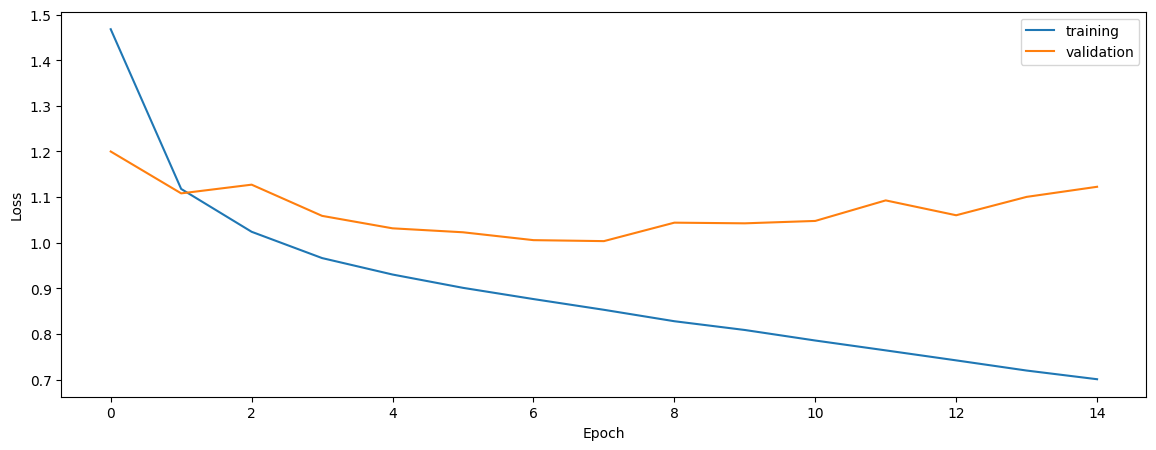

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6779605588385164
0.6168896335475423
0.6202341602588637


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.589783253479352
0.5782863597246127
0.5305614938266219


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5911475155680732
0.575310815271207
0.5384688269850294


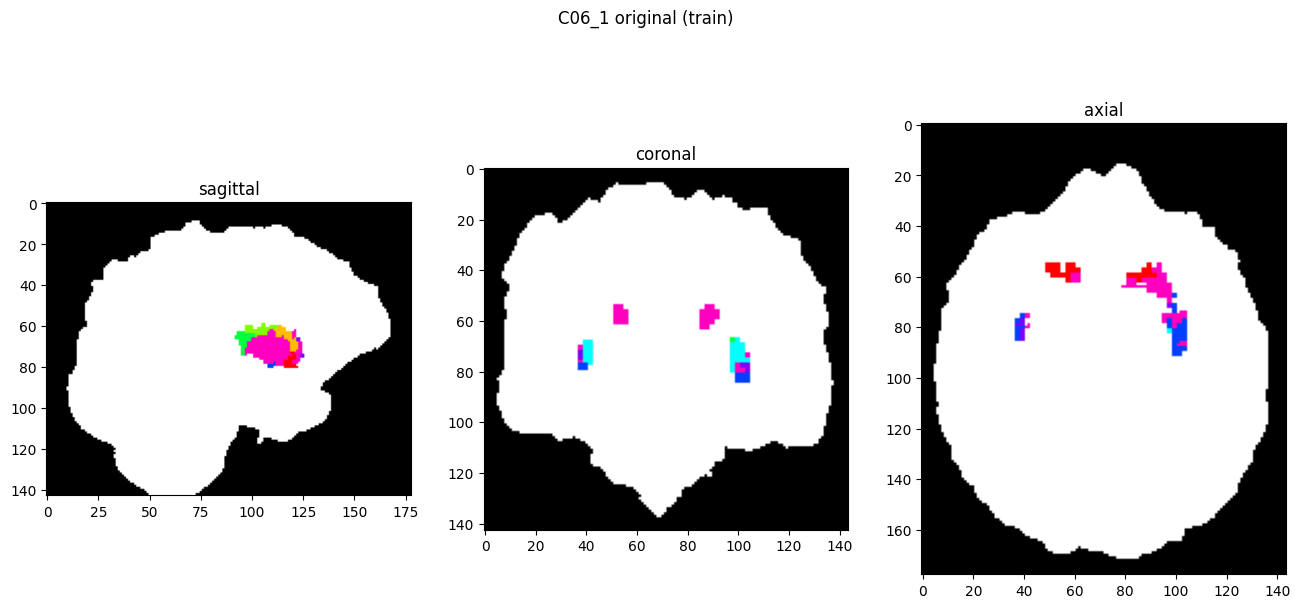

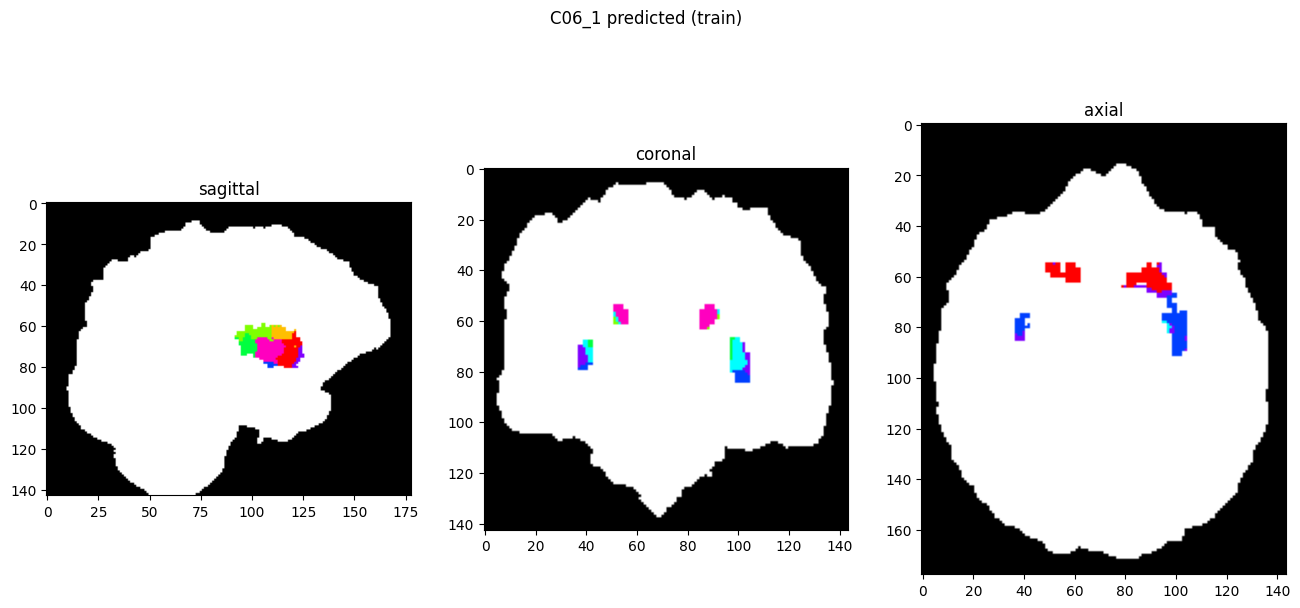

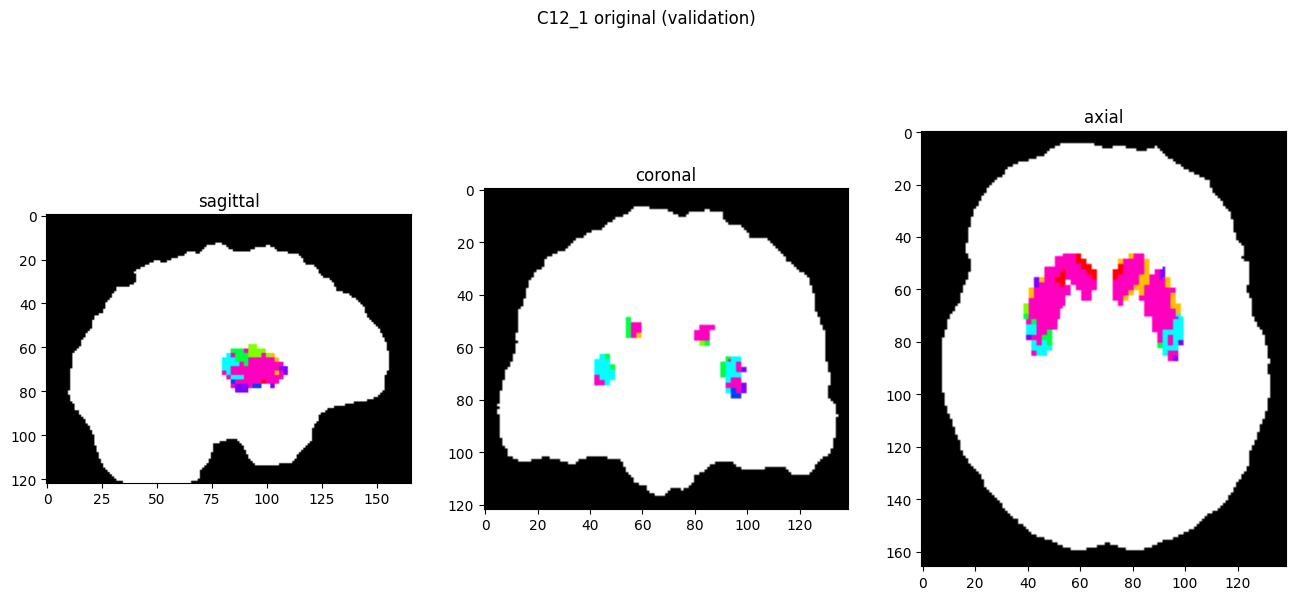

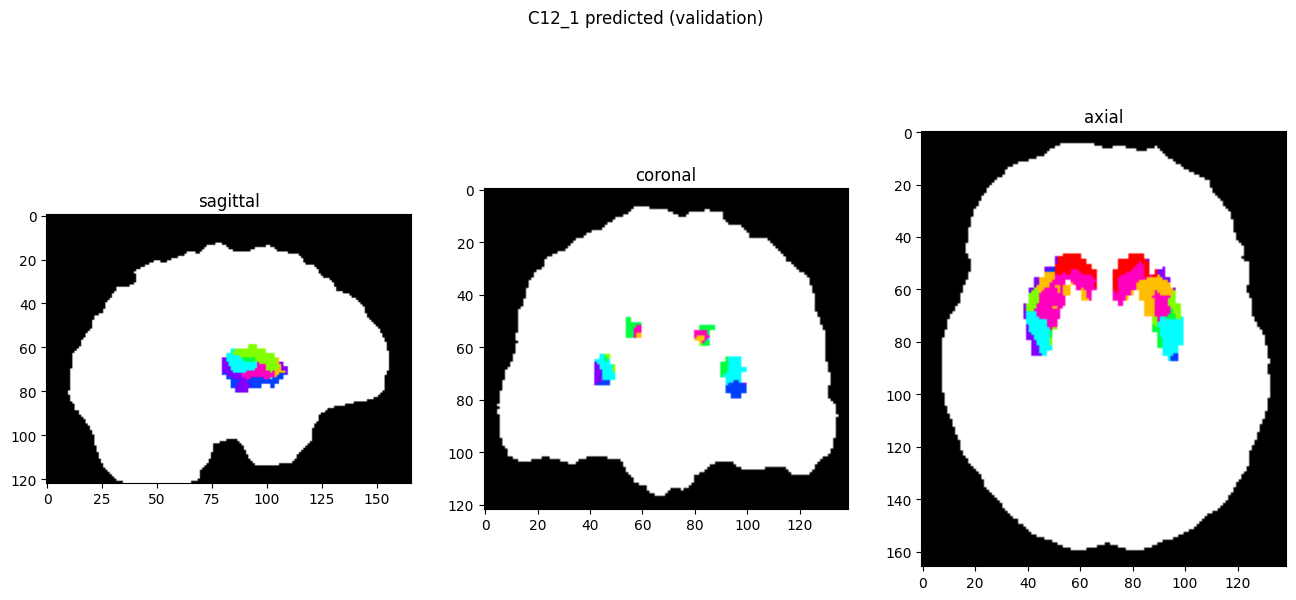

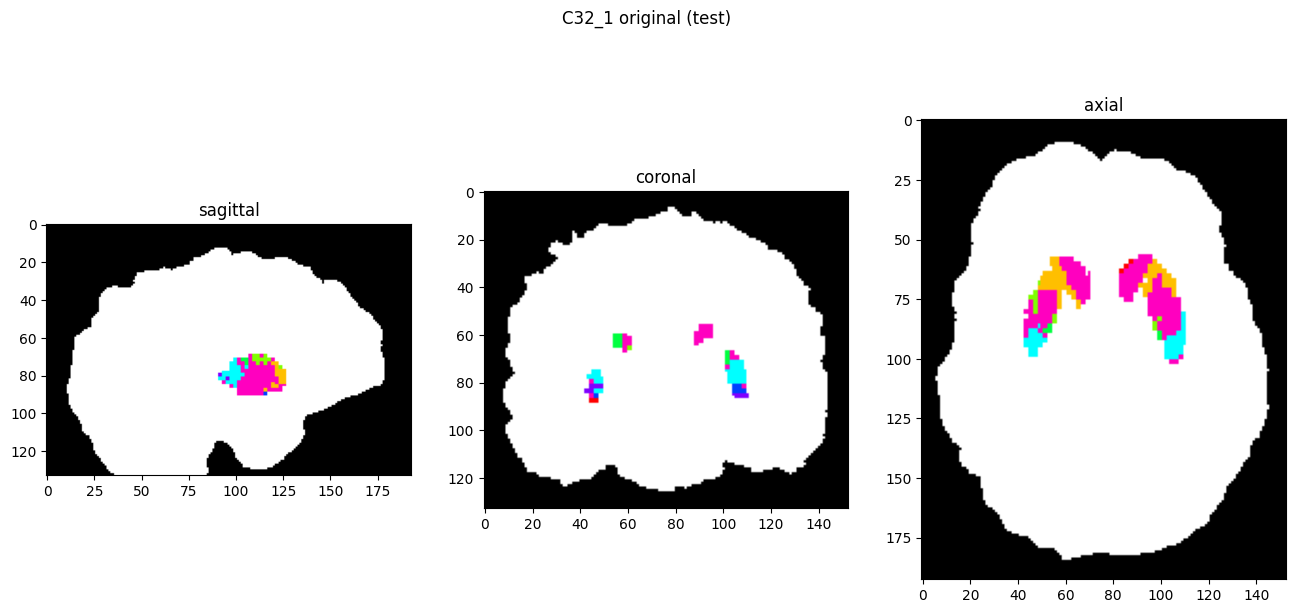

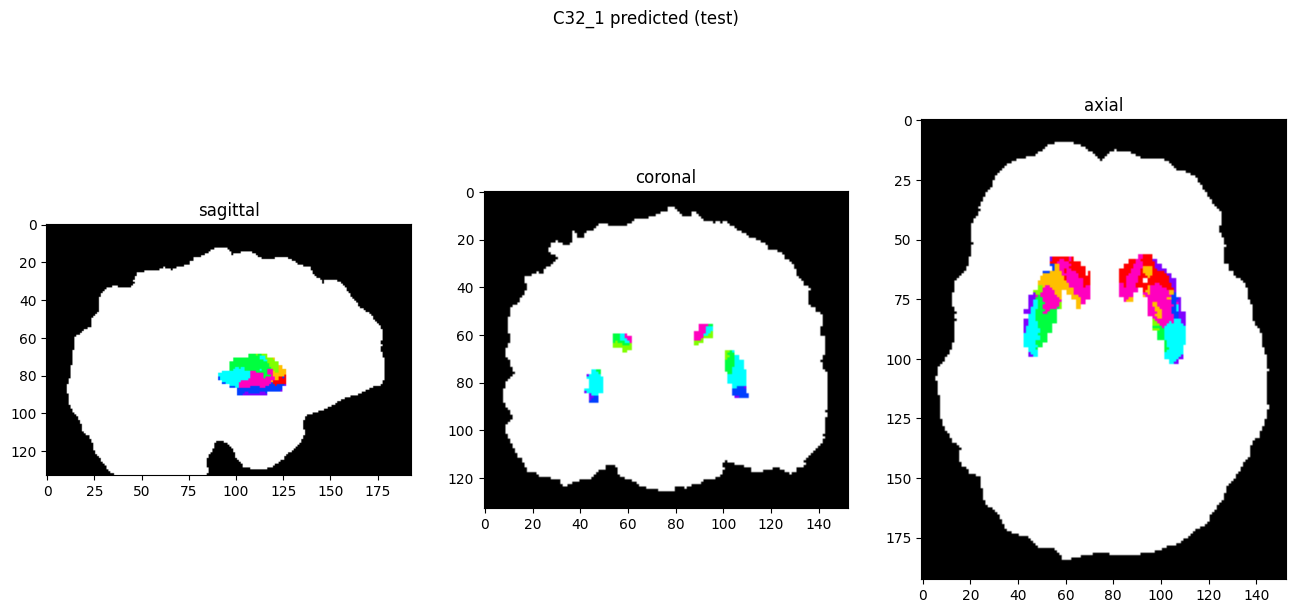

In [10]:
showResults(model, gen, threshold=0)